In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import random
import math
import time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error # compute MSE

#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
!pip install openpyxl

# Constants

In [3]:
DATA_FOLDER = "glioblastoma_data/extracted_data/cell_behaviors/videos_transcriptions_csv"

MAX_experiment_TIME = 721

# Hyper-parameters

In [4]:
DEBUG = False
VERBOSE = 0

DATA_TYPE = "sox" #"normal" #"sox"

COUNT_STARTING_CELL_FOR_INTERVALS = True
MAX_TIME_WINDOW = 721
NB_TIME_WINDOW = 5

XGB_ESTIMATORS = 1000
XGB_LEARNING_RATE = 0.05
XGB_JOBS = 4
XGB_EARLY_STOP = 5

EPOCHS = 10
BATCH_SIZE = 1
VERBOSE = 1

RANDOM_SEED = 0

In [5]:
# Set all random seed for reproductability
np.random.seed(RANDOM_SEED)

if DEBUG:
    for dirname, _, filenames in os.walk(DATA_FOLDER+"/"+DATA_TYPE):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Data Loading

In [6]:
from ast import literal_eval

# Extract all csv into a 2 level dict of dataframe: raw_data[radiation_level][experiment_id] -> dataframe
raw_data = dict()
for dirname, _, filenames in os.walk(DATA_FOLDER):
    for filename in filenames:
        filename_split = filename.split("_")
        experiment_type = filename_split[0]
        experiment_setting = experiment_type+","+filename_split[1][1:-1].replace(" ", "")
        radiation_level = int(filename_split[2].split("gy")[0])
        experiment_id = filename_split[-1][:-4]
        if radiation_level not in raw_data:
            raw_data[radiation_level] = dict()
        if experiment_setting not in raw_data[radiation_level]:
            raw_data[radiation_level][experiment_setting] = dict()  
        df = pd.read_csv(str(os.path.join(dirname, filename)),
                         converters={"input": lambda x: x.strip("[]").replace(' ',"").replace("'","").replace('"',"").replace(','," ").split(),
                                     "output": lambda x: x.strip("[]").replace(' ',"").replace("'","").replace('"',"").replace(','," ").split()})
        raw_data[radiation_level][experiment_setting][experiment_id] = df
        #print(df)
#raw_data

# Features Engineering

In [7]:
# extract original cell of each event
for radiation_level in raw_data:
    for experiment_setting in raw_data[radiation_level]:
        for experiment_id in raw_data[radiation_level][experiment_setting]:
            df = raw_data[radiation_level][experiment_setting][experiment_id]
            df["ancestor"] = ""
            df["input_age"] = None
            df["input_age"] = df["input_age"].astype(object)
            df["previous_event"] = None
            df["previous_event"] = df["previous_event"].astype(object)
            df["next_event"] = None
            df["next_event"] = df["next_event"].astype(object)
            ancestor = dict()
            start = dict()
            output_event = dict()
            input_event = dict()

            delete_df = False

            for i, row in df.iterrows():
                time_val = row["time"]
                event = row["event"]
                input = row["input"]
                output = row["output"]
                #print("Computing ancestor of ", time_val, event, input, output)
                if event == "begin":
                    cell_id = output[0]
                    ancestor[cell_id] = cell_id
                    start[cell_id] = time_val
                    output_event[cell_id] = event
                    df.at[i,'ancestor'] = cell_id
                    continue

                elif event in ["div", "fusion", "death", "out", "end"]:
                    for cell_id in input:
                        input_event[cell_id] = event
                        
                    for cell_id in output:
                        ancestor[cell_id] = ancestor[input[0]]
                        start[cell_id] = time_val
                        output_event[cell_id] = event

                    time_since_born = [time_val - start[cell] for cell in input]
                    if not COUNT_STARTING_CELL_FOR_INTERVALS:
                        for pos, cell_id in enumerate(input):
                            if cell_id == ancestor[cell_id]:
                                time_since_born[pos] = None
                    df.at[i,'input_age'] = time_since_born
                    df.at[i, 'previous_event'] = [output_event[cell] for cell in input]

                # DBG: Missing info
                if input[0] not in ancestor:
                    delete_df = True
                    break

                df.at[i,'ancestor'] =  ancestor[input[0]]
            
            for i, row in df.iterrows():
                output = row["output"]
                df.at[i, 'next_event'] = [input_event[cell] for cell in output]

            # DBG
            if delete_df:
                raw_data[radiation_level][experiment_setting].pop(experiment_id, None)
                print("Deleted exeperiement",experiment_id, " (some cell has no ancestor)")

radiation_levels = list(raw_data.keys())
print("Radiation level keys:", radiation_levels)
experiment_settings = list(raw_data[0].keys())
print("experiments setting:", experiment_settings)
first_experiment = raw_data[radiation_levels[1]][experiment_settings[0]][list(raw_data[radiation_levels[1]][experiment_settings[0]].keys())[0]]
print("Example dataframe:")
first_experiment.sort_values("time")

Radiation level keys: [4, 0, 2, 8, 10, 15]
experiments setting: ['normal,n1', 'normal,n3', 'normal,n2', 'sox,n1,ko', 'sox,n1,ct', 'sox,n2,ko', 'sox,n2,ct']
Example dataframe:


time  event       input output ancestor input_age previous_event  \
0       0  begin          []   [C1]       C1      None           None   
49      0  begin          []   [C5]       C5      None           None   
111     0  begin          []   [C8]       C8      None           None   
23      0  begin          []   [C3]       C3      None           None   
16      0  begin          []   [C2]       C2      None           None   
..    ...    ...         ...    ...      ...       ...            ...   
48    432    end  [C4.2.2.2]     []       C4      [18]          [div]   
47    432    end  [C4.2.2.1]     []       C4      [18]          [div]   
45    432    end    [C4.2.1]     []       C4     [204]          [div]   
42    432    end    [C4.1.1]     []       C4      [55]          [div]   
124   432    end  [C9.2.2.2]     []       C9      [82]          [div]   

    next_event  
0        [div]  
49       [div]  
111      [div]  
23       [div]  
16       [div]  
..         ...  
48          []  
47          []  
45          []  
42          []  
124         []  

[125 rows x 8 columns]

In [8]:
nb_radiation_level = len(raw_data.keys())
nb_experiments = len([0 for radiation_level in raw_data for experiment_setting in raw_data[radiation_level] for experiment_id in raw_data[radiation_level][experiment_setting]])
done = 0

# Extract max time for each radiation level
max_time_observed = 0
experiment_time = dict()
for radiation_level in raw_data:
    experiment_time[radiation_level] = 0
    for experiment_setting in raw_data[radiation_level]:
        for experiment_id in raw_data[radiation_level][experiment_setting]:
            max_time = raw_data[radiation_level][experiment_setting][experiment_id]["time"].max()
            if(max_time > experiment_time[radiation_level]):
                experiment_time[radiation_level] = max_time
            if(max_time > max_time_observed):
                max_time_observed = max_time

if(max_time_observed != MAX_experiment_TIME):
    print("WARNING: max time observed is different from MAX_experiment_TIME constant: ",max_time_observed," != ",MAX_experiment_TIME)

# Common radiation level normal/sox
normal_rad_levels = []
sox_rad_levels = []
for radiation_level in raw_data:
    for experiment_setting in raw_data[radiation_level]:
            if "normal" in experiment_setting:
                normal_rad_levels.append(radiation_level)
            if "sox" in experiment_setting:
                sox_rad_levels.append(radiation_level)
common_rad_levels = set([x for x in normal_rad_levels if x in sox_rad_levels])

print("Common radiation levels of normal and sox settings:",common_rad_levels)
            
# Features extraction for each cell line
data = []
for radiation_level in raw_data:
    for experiment_setting in raw_data[radiation_level]:
        for experiment_id in raw_data[radiation_level][experiment_setting]:
            df = raw_data[radiation_level][experiment_setting][experiment_id]
            
            versions = ["default"]
            
            if radiation_level in common_rad_levels:
                versions.append("max_time_432")
            for version in versions:
                # Extract cell ancestor
                if version == "max_time_432":
                    df = df[df["time"] <= 432]
                for i, row in df.iterrows():
                    time_val = row["time"]
                    event = row["event"]
                    input = row["input"]
                    output = row["output"]
                    #print("Computing ancestor of ", time_val, event, input, output)
                    if event == "begin":
                        cell_id = output[0]
                        ancestor[cell_id] = cell_id
                        continue

                    elif event in ["div", "fusion", "death"]:
                        for cell_id in output:
                            ancestor[cell_id] = ancestor[input[0]]

                for original_cell in df["ancestor"].unique():
                    cell_line_id = experiment_id+"_"+original_cell

                    # experiment duration to normalize data
                    #max_experiment_time = df["time"].max()
                    time_ratio = experiment_time[radiation_level] / MAX_experiment_TIME
                    if version == "max_time_432":
                        time_ratio = 1.0
                    lineage_death = (df[(df["ancestor"] == original_cell) & (df["event"] == "end")]["time"].count() == 0)# and (df[(df["ancestor"] == original_cell) & (df["event"] != "death") & (df["event"] != "out")]["time"].max() < df["time"].max()

                    # Regular events
                    nb_div = df[(df["ancestor"] == original_cell) & (df["event"] == "div")]["event"].count() / time_ratio
                    nb_fusion = df[(df["ancestor"] == original_cell) & (df["event"] == "fusion")]["event"].count() / time_ratio
                    nb_death = df[(df["ancestor"] == original_cell) & (df["event"] == "death")]["event"].count() / time_ratio
                    nb_end = df[(df["ancestor"] == original_cell) & (df["event"] == "end")]["event"].count() / time_ratio

                    # Population
                    #sum_div_outputs = len([j for i in df[(df["ancestor"] == original_cell) & (df["event"] == "div")]["output"] for j in i]) / time_ratio
                    #sum_fusion_inputs = len([j for i in df[(df["ancestor"] == original_cell) & (df["event"] == "fusion")]["input"] for j in i]) / time_ratioabs

                    # Alterations
                    avg_div_outputs = None
                    avg_fusion_inputs = None

                    if nb_div > 0:
                        avg_div_outputs = len([j for i in df[(df["ancestor"] == original_cell) & (df["event"] == "div")]["output"] for j in i]) / nb_div
                        avg_fusion_inputs = len([j for i in df[(df["ancestor"] == original_cell) & (df["event"] == "fusion")]["input"] for j in i]) / nb_div

                    # Event time interval
                    avg_div_interval = None
                    all_div_input_age = np.array([j for i in df[(df["ancestor"] == original_cell) &
                                                                (df["event"] == "div")]["input_age"] for j in i if j is not None])
                    if len(all_div_input_age) > 0:
                        avg_div_interval = all_div_input_age.mean()

                    avg_fusion_interval = None
                    all_fusion_input_age = np.array([j for i in df[(df["ancestor"] == original_cell) &
                                                                   (df["event"] == "fusion")]["input_age"] for j in i if j is not None])
                    if len(all_fusion_input_age) > 0:
                        avg_fusion_interval = all_fusion_input_age.mean()

                    avg_death_interval = None
                    all_death_input_age = np.array([j for i in df[(df["ancestor"] == original_cell) &
                                                                  (df["event"] == "death")]["input_age"] for j in i if j is not None])
                    if len(all_death_input_age) > 0:
                        avg_death_interval = all_death_input_age.mean()

                    sum_input_age = 0
                    all_event_input_age = np.array([j for i in df[(df["ancestor"] == original_cell)]["input_age"] if i is not None for j in i if j is not None])
                    if len(all_event_input_age) > 0:
                        sum_input_age = all_event_input_age.sum() / time_ratio

                    # Special events
                    nb_simultaneous_event = len([i for i in all_event_input_age if i == 0]) / time_ratio

                    all_fusion_event =  np.array(df[(df["ancestor"] == original_cell) & (df["event"] == "fusion")]["input"])
                    all_inter_lineage_fusion = []
                    for fusion in all_fusion_event:
                        for i in fusion:
                            for j in fusion:
                                if ancestor[i] != ancestor[j]:
                                    all_inter_lineage_fusion.append(fusion)
                    nb_fusion_inter_lineage = len(all_inter_lineage_fusion) / time_ratio

                    #if len(all_inter_lineage_fusion):
                        #print(all_inter_lineage_fusion)

                    # first div
                    first_div_time = None
                    all_div_time = np.array(df[(df["ancestor"] == original_cell) & (df["event"] == "div")]["time"])
                    if len(all_div_time) > 0:
                        first_div_time = all_div_time.min()

                    # Time windowed events
                    nb_div_per_window = []
                    nb_fusion_per_window = []
                    nb_non_dichotomic_division_per_window = []
                    nb_anormal_division_per_window = []
                    nb_death_per_window = []
                    lineage_dead_at_window = []
                    begin_time = 0
                    time_window = MAX_TIME_WINDOW/NB_TIME_WINDOW
                    for i in range(0,NB_TIME_WINDOW):
                        end_time = begin_time + time_window
                        # Divisions
                        all_div_in_time_window = df[(df["ancestor"] == original_cell) & 
                                                    (df["event"] == "div") & 
                                                    (df["time"] >= begin_time) & 
                                                    (df["time"] < end_time)]
                        nb_div_per_window.append(len(all_div_in_time_window))

                        # Fusions
                        all_fusion_in_time_window = df[(df["ancestor"] == original_cell) & 
                                                    (df["event"] == "fusion") & 
                                                    (df["time"] >= begin_time) & 
                                                    (df["time"] < end_time)]
                        nb_fusion_per_window.append(len(all_fusion_in_time_window))

                        # Non dichotomic divisions
                        all_non_dichotomic_division_in_time_window = df[((df["ancestor"] == original_cell) & 
                                                    (df["time"] >= begin_time) & 
                                                    (df["time"] < end_time)) &
                                                    (df["event"] == "div") &
                                                    (df["output"].apply(lambda x: len(x) > 2))]
                        nb_non_dichotomic_division_per_window.append(len(all_non_dichotomic_division_in_time_window))

                        # Anormal divisions
                        all_anormal_division_in_time_window = df[((df["ancestor"] == original_cell) & 
                                                    (df["time"] >= begin_time) & 
                                                    (df["time"] < end_time)) &
                                                    (df["event"] == "div")
                                                                &
                                                    ((df["output"].apply(lambda x: len(x) > 2))
                                                                |
                                                    (df["next_event"].apply(lambda x: "fusion" in x)))]
                        nb_anormal_division_per_window.append(len(all_anormal_division_in_time_window))

                        # Deaths
                        all_death_in_time_window = df[(df["ancestor"] == original_cell) & 
                                                    (df["event"] == "death") &
                                                    (df["time"] >= begin_time) & 
                                                    (df["time"] < end_time)]
                        nb_death_per_window.append(len(all_death_in_time_window))

                        #if len(all_div_in_time_window) > 0:
                        #    print(i,"(",begin_time,"to",end_time,")",all_div_in_time_window)
                        if (begin_time > df["time"].max()):
                            lineage_dead_at_window.append(lineage_dead_at_window[-1])
                        else:
                            last_event_in_time_window = df[(df["ancestor"] == original_cell) & (df["event"] != "death") & (df["event"] != "out")]["time"].max() < end_time
                            end_event_exist = df[(df["ancestor"] == original_cell) & (df["event"] == "end")]["time"].count() > 0
                            if (last_event_in_time_window and not end_event_exist):
                                lineage_dead_at_window.append(True)
                            else:
                                lineage_dead_at_window.append(False)

                        begin_time = end_time

                    # summary of windowed event
                    nb_non_dichotomic_division = sum(nb_non_dichotomic_division_per_window)
                    nb_anormal_division = sum(nb_anormal_division_per_window)

                    # Event before death
                    all_death_event = df[(df["ancestor"] == original_cell) & (df["event"] == "death")]
                    nb_death_after_begin = 0
                    nb_death_after_fusion = 0
                    nb_death_after_normal_div = 0
                    nb_death_after_anormal_div = 0

                    for row in all_death_event.iterrows():
                        cell_id = row[1]["input"]
                        #print(cell_id)
                        cell_creation_event = df[(df["ancestor"] == original_cell) & (pd.DataFrame(df.output.tolist()).isin(cell_id).any(1).values)].reset_index(drop=True).to_dict()
                        #print(cell_creation_event)
                        if(cell_creation_event["event"][0] == "begin"):
                            nb_death_after_begin += 1 / time_ratio
                        if(cell_creation_event["event"][0] == "div" and len(cell_creation_event["output"][0]) == 2):
                            nb_death_after_normal_div += 1 / time_ratio
                        if(cell_creation_event["event"][0] == "div" and len(cell_creation_event["output"][0]) > 2):
                            nb_death_after_anormal_div += 1 / time_ratio
                        if(cell_creation_event["event"][0] == "fusion"):
                            nb_death_after_fusion += 1 / time_ratio


                    data_row = [cell_line_id, 
                                 radiation_level,
                                 experiment_setting,
                                 lineage_death,
                                 nb_div, 
                                 nb_fusion, 
                                 nb_death, 
                                 nb_end, 
                                 avg_div_outputs, 
                                 avg_fusion_inputs, 
                                 avg_div_interval,
                                 avg_fusion_interval,
                                 avg_death_interval,
                                 sum_input_age,
                                 nb_simultaneous_event,
                                 nb_fusion_inter_lineage,
                                 nb_non_dichotomic_division,
                                 nb_anormal_division,
                                 first_div_time,
                                 nb_death_after_begin,
                                 nb_death_after_normal_div,
                                 nb_death_after_anormal_div,
                                 nb_death_after_fusion,
                                ]

                    for i in nb_div_per_window:
                        data_row.append(i)

                    for i in nb_fusion_per_window:
                        data_row.append(i)

                    for i in nb_anormal_division_per_window:
                        data_row.append(i)

                    for i in nb_non_dichotomic_division_per_window:
                        data_row.append(i)

                    for i in nb_death_per_window:
                        data_row.append(i)

                    for i in lineage_dead_at_window:
                        data_row.append(i)

                    #if DATA_TYPE == "sox":
                    data_row.append("sox" in experiment_setting and "ko" in experiment_setting)
                    data_row.append(version)

                    data.append(data_row)
                
                if version == "default":
                    done +=1
                    print(str(done)+"/"+str(nb_experiments), end="\r")
        
            #break
        #break
    #break
    
columns = ["cell_line_id", 
            "radiation_level",
            "experiment_setting",
            "lineage_death",
            "nb_div", 
            "nb_fusion", 
            "nb_death", 
            "nb_end", 
            "avg_div_outputs", 
            "avg_fusion_input",
            "avg_div_interval",
            "avg_fusion_interval",
            "avg_death_interval",
            "sum_input_age",
            "nb_simultaneous_event",
            "nb_fusion_inter_lineage",
            "nb_non_dichotomic_division",
            "nb_anormal_division",
            "first_div_time",
            "death_after_begin",
            "nb_death_after_normal_div",
            "nb_death_after_anormal_div",
            "nb_death_after_fusion",
           ]
            
for i in range(0,NB_TIME_WINDOW):
    columns.append("nb_div_in_time_window_"+str(i))
for i in range(0,NB_TIME_WINDOW):
    columns.append("nb_fusion_in_time_window_"+str(i))
for i in range(0,NB_TIME_WINDOW):
    columns.append("nb_anormal_division_in_time_window_"+str(i))
for i in range(0,NB_TIME_WINDOW):
    columns.append("nb_non_dichotomic_division_in_time_window_"+str(i))
for i in range(0,NB_TIME_WINDOW):
    columns.append("nb_death_in_time_window_"+str(i))
for i in range(0,NB_TIME_WINDOW):
    columns.append("lineage_dead_at_time_window_"+str(i))
    
#if DATA_TYPE == "sox":
columns.append("sox_ko")
columns.append("version")
    
df = pd.DataFrame(data, columns=columns)
df

Common radiation levels of normal and sox settings: {0, 4}


cell_line_id  radiation_level experiment_setting  \
0     160930.nd2u2514gyp3_C1                4          normal,n1   
1     160930.nd2u2514gyp3_C2                4          normal,n1   
2     160930.nd2u2514gyp3_C3                4          normal,n1   
3     160930.nd2u2514gyp3_C4                4          normal,n1   
4     160930.nd2u2514gyp3_C5                4          normal,n1   
...                      ...              ...                ...   
3554         2021N215GY1C_C1               15          normal,n2   
3555         2021N215GY1C_C2               15          normal,n2   
3556         2021N215GY1C_C3               15          normal,n2   
3557         2021N215GY1C_C4               15          normal,n2   
3558         2021N215GY1C_C5               15          normal,n2   

      lineage_death    nb_div  nb_fusion  nb_death    nb_end  avg_div_outputs  \
0             False  0.998615   0.998615  0.998615  0.998615         3.004161   
1              True  0.000000   0.000000  0.000000  0.000000              NaN   
2              True  0.000000   0.000000  0.998615  0.000000              NaN   
3              True  0.000000   0.000000  0.000000  0.000000              NaN   
4             False  0.998615   0.000000  0.998615  1.997230         3.004161   
...             ...       ...        ...       ...       ...              ...   
3554           True  0.000000   0.000000  1.000000  0.000000              NaN   
3555           True  0.000000   0.000000  0.000000  0.000000              NaN   
3556           True  0.000000   0.000000  1.000000  0.000000              NaN   
3557           True  0.000000   0.000000  1.000000  0.000000              NaN   
3558           True  1.000000   1.000000  1.000000  0.000000         2.000000   

      avg_fusion_input  ...  nb_death_in_time_window_2  \
0             2.002774  ...                          0   
1                  NaN  ...                          0   
2                  NaN  ...                          0   
3                  NaN  ...                          0   
4             0.000000  ...                          0   
...                ...  ...                        ...   
3554               NaN  ...                          0   
3555               NaN  ...                          0   
3556               NaN  ...                          1   
3557               NaN  ...                          0   
3558          2.000000  ...                          1   

      nb_death_in_time_window_3  nb_death_in_time_window_4  \
0                             0                          1   
1                             0                          0   
2                             0                          1   
3                             0                          0   
4                             1                          0   
...                         ...                        ...   
3554                          1                          0   
3555                          0                          0   
3556                          0                          0   
3557                          1                          0   
3558                          0                          0   

      lineage_dead_at_time_window_0  lineage_dead_at_time_window_1  \
0                             False                          False   
1                              True                           True   
2                              True                           True   
3                              True                           True   
4                             False                          False   
...                             ...                            ...   
3554                           True                           True   
3555                           True                           True   
3556                           True                           True   
3557                           True                           True   
3558          

# EDA

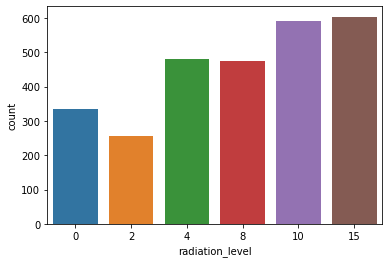

In [9]:
ax = sns.countplot(x="radiation_level", data=df[df["version"] == "default"])

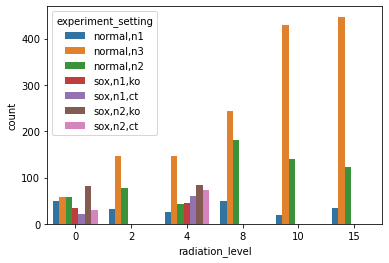

In [10]:
ax = sns.countplot(x="radiation_level", hue="experiment_setting", data=df[df["version"] == "default"])

## Survival curve

In [11]:
survival_curves = dict()

for data_type in ["normal", "sox"]:
    df_copy = df[df["version"] == "default"].copy()
    df_sum = df_copy.groupby(["radiation_level", "experiment_setting"]).sum()
    df_sum = df_sum.reset_index()
    df_count = df_copy.groupby(["radiation_level", "experiment_setting"]).count()
    df_count = df_count.reset_index()
    df_result = df_count[["radiation_level","experiment_setting"]].copy()
    df_result["starting_cells"] = df_count["lineage_death"]
    df_result["lineage_death"] = df_sum["lineage_death"]
    for i in range(0,NB_TIME_WINDOW):
        df_result["lineage_dead_at_time_window_"+str(i)] = df_sum["lineage_dead_at_time_window_"+str(i)]
        df_result["survival_ratio_at_time_window_"+str(i)] = (df_result["starting_cells"] - df_result["lineage_dead_at_time_window_"+str(i)]) / df_result["starting_cells"]

    if data_type == "sox":
        df_result = df_result[df_result["experiment_setting"].str.contains("sox")]
        df_result["sox_ko"] = df_result['experiment_setting'].str.contains("ko")

    if data_type == "normal":
        df_result = df_result[df_result["experiment_setting"].str.contains("normal")]
        df_result_avg = df_result.groupby("radiation_level").mean()
        df_result_avg["experiment_setting"] = "AVG"
        df_result_avg = df_result_avg.reset_index()

    if data_type == "sox":
        df_result_avg = df_result.groupby(["radiation_level","sox_ko"]).mean()
        df_result_avg = df_result_avg.reset_index()
        df_result_avg["experiment_setting"] = df_result_avg["sox_ko"]
        df_result_avg["experiment_setting"] = df_result_avg["experiment_setting"].apply(lambda x: "AVG ko" if x else "AVG ct")
    df_result = df_result.append(df_result_avg)

    df_result = df_result[["radiation_level", 
                           "experiment_setting", 
                           "starting_cells", 
                           "lineage_dead_at_time_window_0", 
                           "lineage_dead_at_time_window_1", 
                           "lineage_dead_at_time_window_2", 
                           "lineage_dead_at_time_window_3", 
                           "lineage_dead_at_time_window_4",
                           "survival_ratio_at_time_window_0", 
                           "survival_ratio_at_time_window_1", 
                           "survival_ratio_at_time_window_2", 
                           "survival_ratio_at_time_window_3", 
                           "survival_ratio_at_time_window_4"]]
    survival_curves[data_type] = df_result
    display(df_result.head())
    #df_sum
    #df_result_avg

radiation_level experiment_setting  starting_cells  \
0                0          normal,n1            50.0   
1                0          normal,n2            58.0   
2                0          normal,n3            59.0   
7                2          normal,n1            32.0   
8                2          normal,n2            78.0   

   lineage_dead_at_time_window_0  lineage_dead_at_time_window_1  \
0                            5.0                            5.0   
1                            3.0                            4.0   
2                           11.0                           12.0   
7                            5.0                            7.0   
8                            8.0                            9.0   

   lineage_dead_at_time_window_2  lineage_dead_at_time_window_3  \
0                            5.0                            5.0   
1                            4.0                            4.0   
2                           13.0                           13.0   
7                            8.0                            8.0   
8                            9.0                            9.0   

   lineage_dead_at_time_window_4  survival_ratio_at_time_window_0  \
0                            5.0                         0.900000   
1                            4.0                         0.948276   
2                           13.0                         0.813559   
7                            8.0                         0.843750   
8                            9.0                         0.897436   

   survival_ratio_at_time_window_1  survival_ratio_at_time_window_2  \
0                         0.900000                         0.900000   
1                         0.931034                         0.931034   
2                         0.796610                         0.779661   
7                         0.781250                         0.750000   
8                         0.884615                         0.884615   

   survival_ratio_at_time_window_3  survival_ratio_at_time_window_4  
0                         0.900000                         0.900000  
1                         0.931034                         0.931034  
2                         0.779661                         0.779661  
7                         0.750000                         0.750000  
8                         0.884615                         0.884615

radiation_level experiment_setting  starting_cells  \
3                 0          sox,n1,ct            21.0   
4                 0          sox,n1,ko            35.0   
5                 0          sox,n2,ct            31.0   
6                 0          sox,n2,ko            82.0   
13                4          sox,n1,ct            61.0   

    lineage_dead_at_time_window_0  lineage_dead_at_time_window_1  \
3                             0.0                            0.0   
4                            10.0                           10.0   
5                             4.0                            4.0   
6                            14.0                           20.0   
13                           15.0                           18.0   

    lineage_dead_at_time_window_2  lineage_dead_at_time_window_3  \
3                             1.0                            1.0   
4                            10.0                           12.0   
5                             4.0                            5.0   
6                            20.0                           20.0   
13                           23.0                           23.0   

    lineage_dead_at_time_window_4  survival_ratio_at_time_window_0  \
3                             1.0                         1.000000   
4                            12.0                         0.714286   
5                             5.0                         0.870968   
6                            20.0                         0.829268   
13                           23.0                         0.754098   

    survival_ratio_at_time_window_1  survival_ratio_at_time_window_2  \
3                          1.000000                         0.952381   
4                          0.714286                         0.714286   
5                          0.870968                         0.870968   
6                          0.756098                         0.756098   
13                         0.704918                         0.622951   

    survival_ratio_at_time_window_3  survival_ratio_at_time_window_4  
3                          0.952381                         0.952381  
4                          0.657143                         0.657143  
5                          0.838710                         0.838710  
6                          0.756098                         0.756098  
13                         0.622951                         0.622951

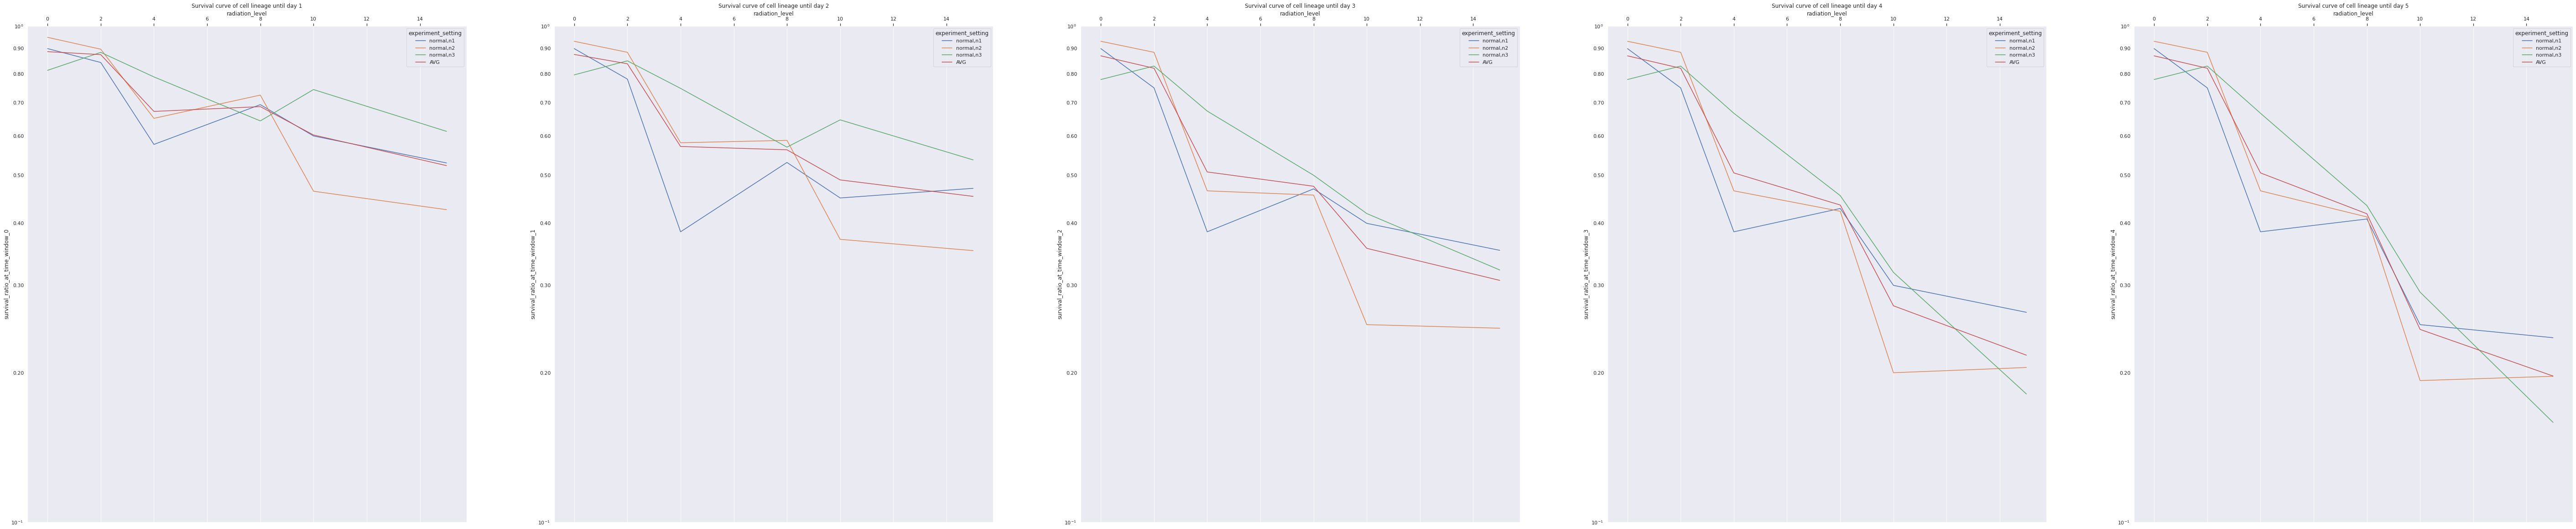

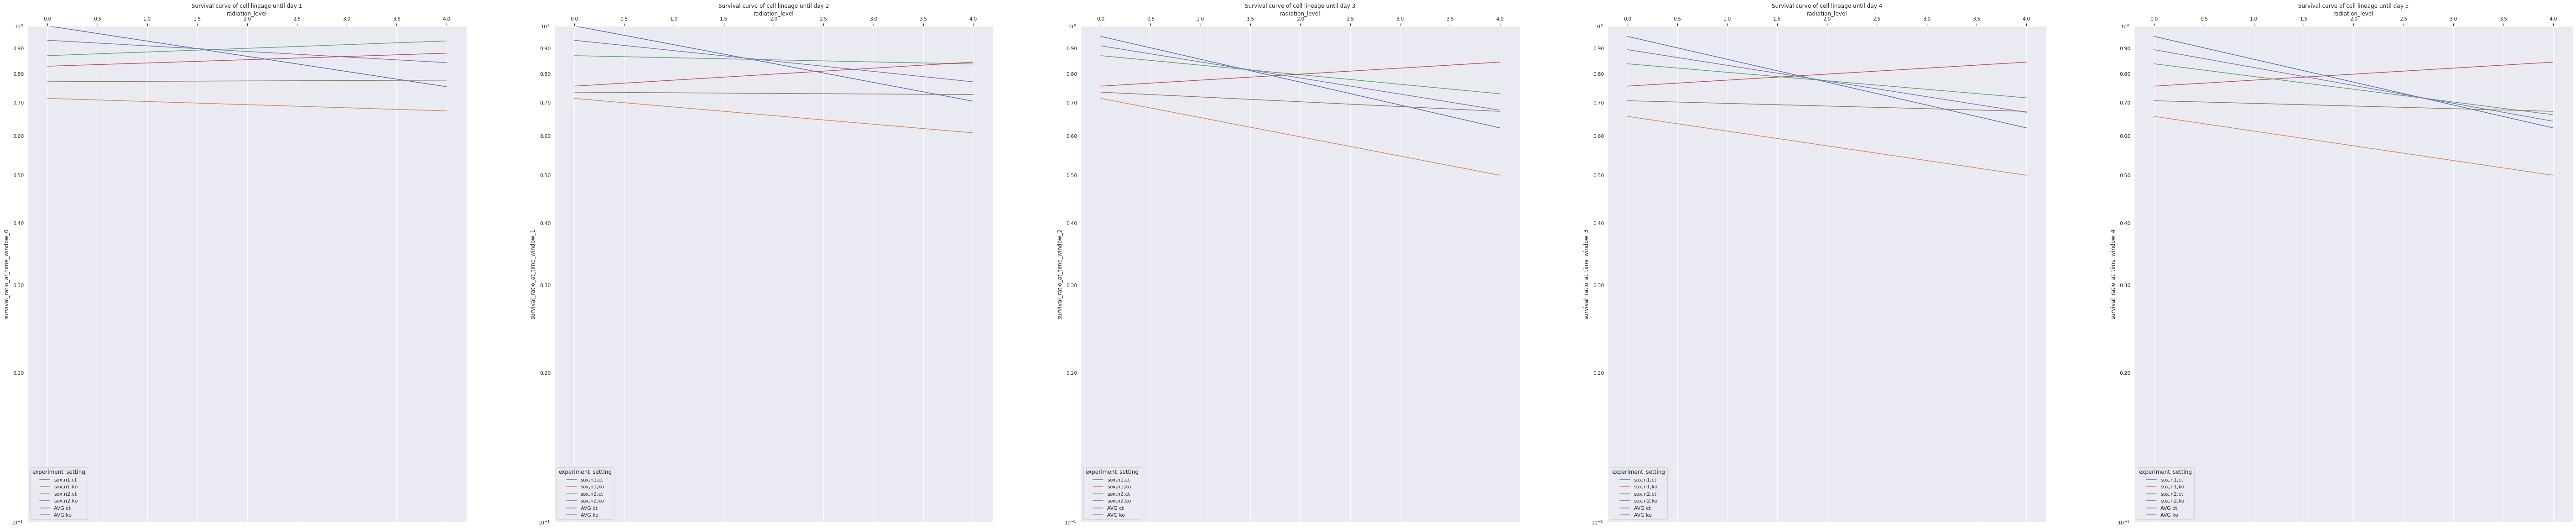

In [12]:
import seaborn as sns
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")

for data_type in ["normal", "sox"]:
    df_result = survival_curves[data_type]
    f, axs = plt.subplots(1,NB_TIME_WINDOW,figsize=(100,20))
    for i in range(0,NB_TIME_WINDOW):
        # Plot the responses for different events and regions
        plt.subplot(1,NB_TIME_WINDOW,i+1)
        ax = sns.lineplot(x="radiation_level", y="survival_ratio_at_time_window_"+str(i),
                     hue="experiment_setting",# style="experiment_setting", dashes=False, palette=sns.color_palette("rocket", as_cmap=True),
                     data=df_result)
        ax.set(yscale="log")#, xscale="log")
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
        ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
        ax.set_title("Survival curve of cell lineage until day "+str(i+1))

        plt.ylim([0.1, 1])

In [13]:
df_copy = df_result.copy()
#df_copy = df_copy[["radiation_level","experiment_setting","survival_ratio_at_time_window_0"]]
#df_copy
pd.pivot_table( df_copy, index = ["experiment_setting"], columns = ["radiation_level"], values = ["survival_ratio_at_time_window_0"] )

survival_ratio_at_time_window_0          
radiation_level                                  0         4
experiment_setting                                          
AVG ct                                    0.935484  0.843265
AVG ko                                    0.771777  0.777433
sox,n1,ct                                 1.000000  0.754098
sox,n1,ko                                 0.714286  0.673913
sox,n2,ct                                 0.870968  0.932432
sox,n2,ko                                 0.829268  0.880952

In [14]:
from IPython.display import FileLink, FileLinks

for data_type in ["normal", "sox"]:
    df_copy = survival_curves[data_type].copy()
    for day in range(0,5):
        print("Extracting survival ratio for day "+str(day))
        df_output = pd.pivot_table( df_copy, index = ["experiment_setting"], columns = ["radiation_level"], values = ["survival_ratio_at_time_window_"+str(day)] )
        filename = "survival_ratio_day_"+str(day)+".xlsx"
        #df_output.columns = df_output.columns.astype(int)
        #df_output = df_output.reset_index()
        df_output = df_output.reset_index().T.reset_index().T
        df_output = df_output.iloc[1: , :]
        df_output.to_excel(filename, header=False, index=False)
        display(df_output)
    if data_type == "normal":
        !zip "normal_survival_ratio_until_day_5.zip" *.xlsx
    if data_type == "sox":
        !zip "sox_survival_ratio_until_day_5.zip" *.xlsx
    !rm *.xlsx
    display(FileLink(data_type+"_survival_ratio_until_day_5.zip"))

Extracting survival ratio for day 0


0         1         2         3         4         5  \
radiation_level                    0         2         4         8        10   
0                      AVG  0.887278   0.87518  0.672401  0.687532  0.602824   
1                normal,n1       0.9   0.84375  0.576923  0.693878       0.6   
2                normal,n2  0.948276  0.897436  0.651163  0.725275  0.464286   
3                normal,n3  0.813559  0.884354  0.789116  0.643443  0.744186   

                        6  
radiation_level        15  
0                0.522872  
1                0.529412  
2                 0.42623  
3                0.612975

Extracting survival ratio for day 1


0         1         2         3         4         5  \
radiation_level                    0         2         4         8        10   
0                      AVG  0.875882  0.838735  0.571437  0.562732  0.489313   
1                normal,n1       0.9   0.78125  0.384615  0.530612      0.45   
2                normal,n2  0.931034  0.884615  0.581395  0.587912  0.371429   
3                normal,n3   0.79661   0.85034  0.748299  0.569672  0.646512   

                        6  
radiation_level        15  
0                 0.45332  
1                0.470588  
2                0.352459  
3                0.536913

Extracting survival ratio for day 2


0         1         2         3         4         5  \
radiation_level                    0         2         4         8        10   
0                      AVG  0.870232  0.821516  0.507734  0.475144  0.356202   
1                normal,n1       0.9      0.75  0.384615  0.469388       0.4   
2                normal,n2  0.931034  0.884615  0.465116  0.456044      0.25   
3                normal,n3  0.779661  0.829932  0.673469       0.5  0.418605   

                        6  
radiation_level        15  
0                0.306997  
1                0.352941  
2                0.245902  
3                0.322148

Extracting survival ratio for day 3


0         1         2         3         4         5  \
radiation_level                    0         2         4         8        10   
0                      AVG  0.870232  0.821516  0.505466  0.435522  0.272868   
1                normal,n1       0.9      0.75  0.384615  0.428571       0.3   
2                normal,n2  0.931034  0.884615  0.465116  0.423077       0.2   
3                normal,n3  0.779661  0.829932  0.666667  0.454918  0.318605   

                        6  
radiation_level        15  
0                0.216944  
1                0.264706  
2                0.204918  
3                0.181208

Extracting survival ratio for day 4


0         1         2         3         4         5  \
radiation_level                    0         2         4         8        10   
0                      AVG  0.870232  0.821516  0.505466  0.418226  0.244518   
1                normal,n1       0.9      0.75  0.384615  0.408163      0.25   
2                normal,n2  0.931034  0.884615  0.465116  0.412088  0.192857   
3                normal,n3  0.779661  0.829932  0.666667  0.434426  0.290698   

                        6  
radiation_level        15  
0                0.196951  
1                0.235294  
2                0.196721  
3                0.158837

  adding: survival_ratio_day_0.xlsx (deflated 11%)
  adding: survival_ratio_day_1.xlsx (deflated 11%)
  adding: survival_ratio_day_2.xlsx (deflated 11%)
  adding: survival_ratio_day_3.xlsx (deflated 11%)
  adding: survival_ratio_day_4.xlsx (deflated 11%)


/home/keijuro/Bureau/epicea/normal_survival_ratio_until_day_5.zip

Extracting survival ratio for day 0


0         1         2
radiation_level                    0         4
0                   AVG ct  0.935484  0.843265
1                   AVG ko  0.771777  0.777433
2                sox,n1,ct         1  0.754098
3                sox,n1,ko  0.714286  0.673913
4                sox,n2,ct  0.870968  0.932432
5                sox,n2,ko  0.829268  0.880952

Extracting survival ratio for day 1


0         1         2
radiation_level                    0         4
0                   AVG ct  0.935484  0.771378
1                   AVG ko  0.735192  0.726967
2                sox,n1,ct         1  0.704918
3                sox,n1,ko  0.714286  0.608696
4                sox,n2,ct  0.870968  0.837838
5                sox,n2,ko  0.756098  0.845238

Extracting survival ratio for day 2


0         1         2
radiation_level                    0         4
0                   AVG ct  0.911674   0.67634
1                   AVG ko  0.735192  0.672619
2                sox,n1,ct  0.952381  0.622951
3                sox,n1,ko  0.714286       0.5
4                sox,n2,ct  0.870968   0.72973
5                sox,n2,ko  0.756098  0.845238

Extracting survival ratio for day 3


0         1         2
radiation_level                    0         4
0                   AVG ct  0.895545  0.669584
1                   AVG ko   0.70662  0.672619
2                sox,n1,ct  0.952381  0.622951
3                sox,n1,ko  0.657143       0.5
4                sox,n2,ct   0.83871  0.716216
5                sox,n2,ko  0.756098  0.845238

Extracting survival ratio for day 4


0         1         2
radiation_level                    0         4
0                   AVG ct  0.895545  0.642556
1                   AVG ko   0.70662  0.672619
2                sox,n1,ct  0.952381  0.622951
3                sox,n1,ko  0.657143       0.5
4                sox,n2,ct   0.83871  0.662162
5                sox,n2,ko  0.756098  0.845238

  adding: survival_ratio_day_0.xlsx (deflated 11%)
  adding: survival_ratio_day_1.xlsx (deflated 11%)
  adding: survival_ratio_day_2.xlsx (deflated 11%)
  adding: survival_ratio_day_3.xlsx (deflated 11%)
  adding: survival_ratio_day_4.xlsx (deflated 11%)


/home/keijuro/Bureau/epicea/sox_survival_ratio_until_day_5.zip

## Correlation matrix heatmaps

# Correlations heatmap over normal experiements

In [15]:
df_copy = df[df["version"] == "default"].copy()
df_copy = df_copy[df_copy["experiment_setting"].str.contains("normal")]
cols = []
for i in sorted(df_copy["radiation_level"].unique()):
    col_name = "radiation_"+str(i)+"gy"
    cols.append(col_name)
    df_copy[col_name] = (df["radiation_level"] == i)
    
cols.extend([i for i in df.columns.tolist() if i not in ["radiation_level","cell_line_id", "experiment_setting"]])
df_copy = df_copy[["cell_line_id", "experiment_setting", "radiation_level"]+cols]
#if DATA_TYPE == "sox":
#    df_copy["experiment_setting"] = df_copy["experiment_setting"].apply(lambda x: x.split(",")[0])
df_copy

cell_line_id experiment_setting  radiation_level  \
0     160930.nd2u2514gyp3_C1          normal,n1                4   
1     160930.nd2u2514gyp3_C2          normal,n1                4   
2     160930.nd2u2514gyp3_C3          normal,n1                4   
3     160930.nd2u2514gyp3_C4          normal,n1                4   
4     160930.nd2u2514gyp3_C5          normal,n1                4   
...                      ...                ...              ...   
3554         2021N215GY1C_C1          normal,n2               15   
3555         2021N215GY1C_C2          normal,n2               15   
3556         2021N215GY1C_C3          normal,n2               15   
3557         2021N215GY1C_C4          normal,n2               15   
3558         2021N215GY1C_C5          normal,n2               15   

      radiation_0gy  radiation_2gy  radiation_4gy  radiation_8gy  \
0             False          False           True          False   
1             False          False           True          False   
2             False          False           True          False   
3             False          False           True          False   
4             False          False           True          False   
...             ...            ...            ...            ...   
3554          False          False          False          False   
3555          False          False          False          False   
3556          False          False          False          False   
3557          False          False          False          False   
3558          False          False          False          False   

      radiation_10gy  radiation_15gy  lineage_death  ...  \
0              False           False          False  ...   
1              False           False           True  ...   
2              False           False           True  ...   
3              False           False           True  ...   
4              False           False          False  ...   
...              ...             ...            ...  ...   
3554           False            True           True  ...   
3555           False            True           True  ...   
3556           False            True           True  ...   
3557           False            True           True  ...   
3558           False            True           True  ...   

      nb_death_in_time_window_2  nb_death_in_time_window_3  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          1   
...                         ...                        ...   
3554                          0                          1   
3555                          0                          0   
3556                          1                          0   
3557                          0                          1   
3558                          1                          0   

      nb_death_in_time_window_4  lineage_dead_at_time_window_0  \
0                             1                          False   
1                             0                           True   
2                             1                           True   
3                             0                           True   
4                             0                          False   
...                         ...                            ...   
3554                          0                           True   
3555                          0                           True   
3556                          0                           True   
3557                          0                           True   
3558                          0                           True   

      lineage_dead_at_time_window_1  lineage_dead_at_time_window_2  \
0                             False                  

Heatmap of the correlation matrix of cell lineage properties for average of ['normal,n1', 'normal,n3', 'normal,n2']


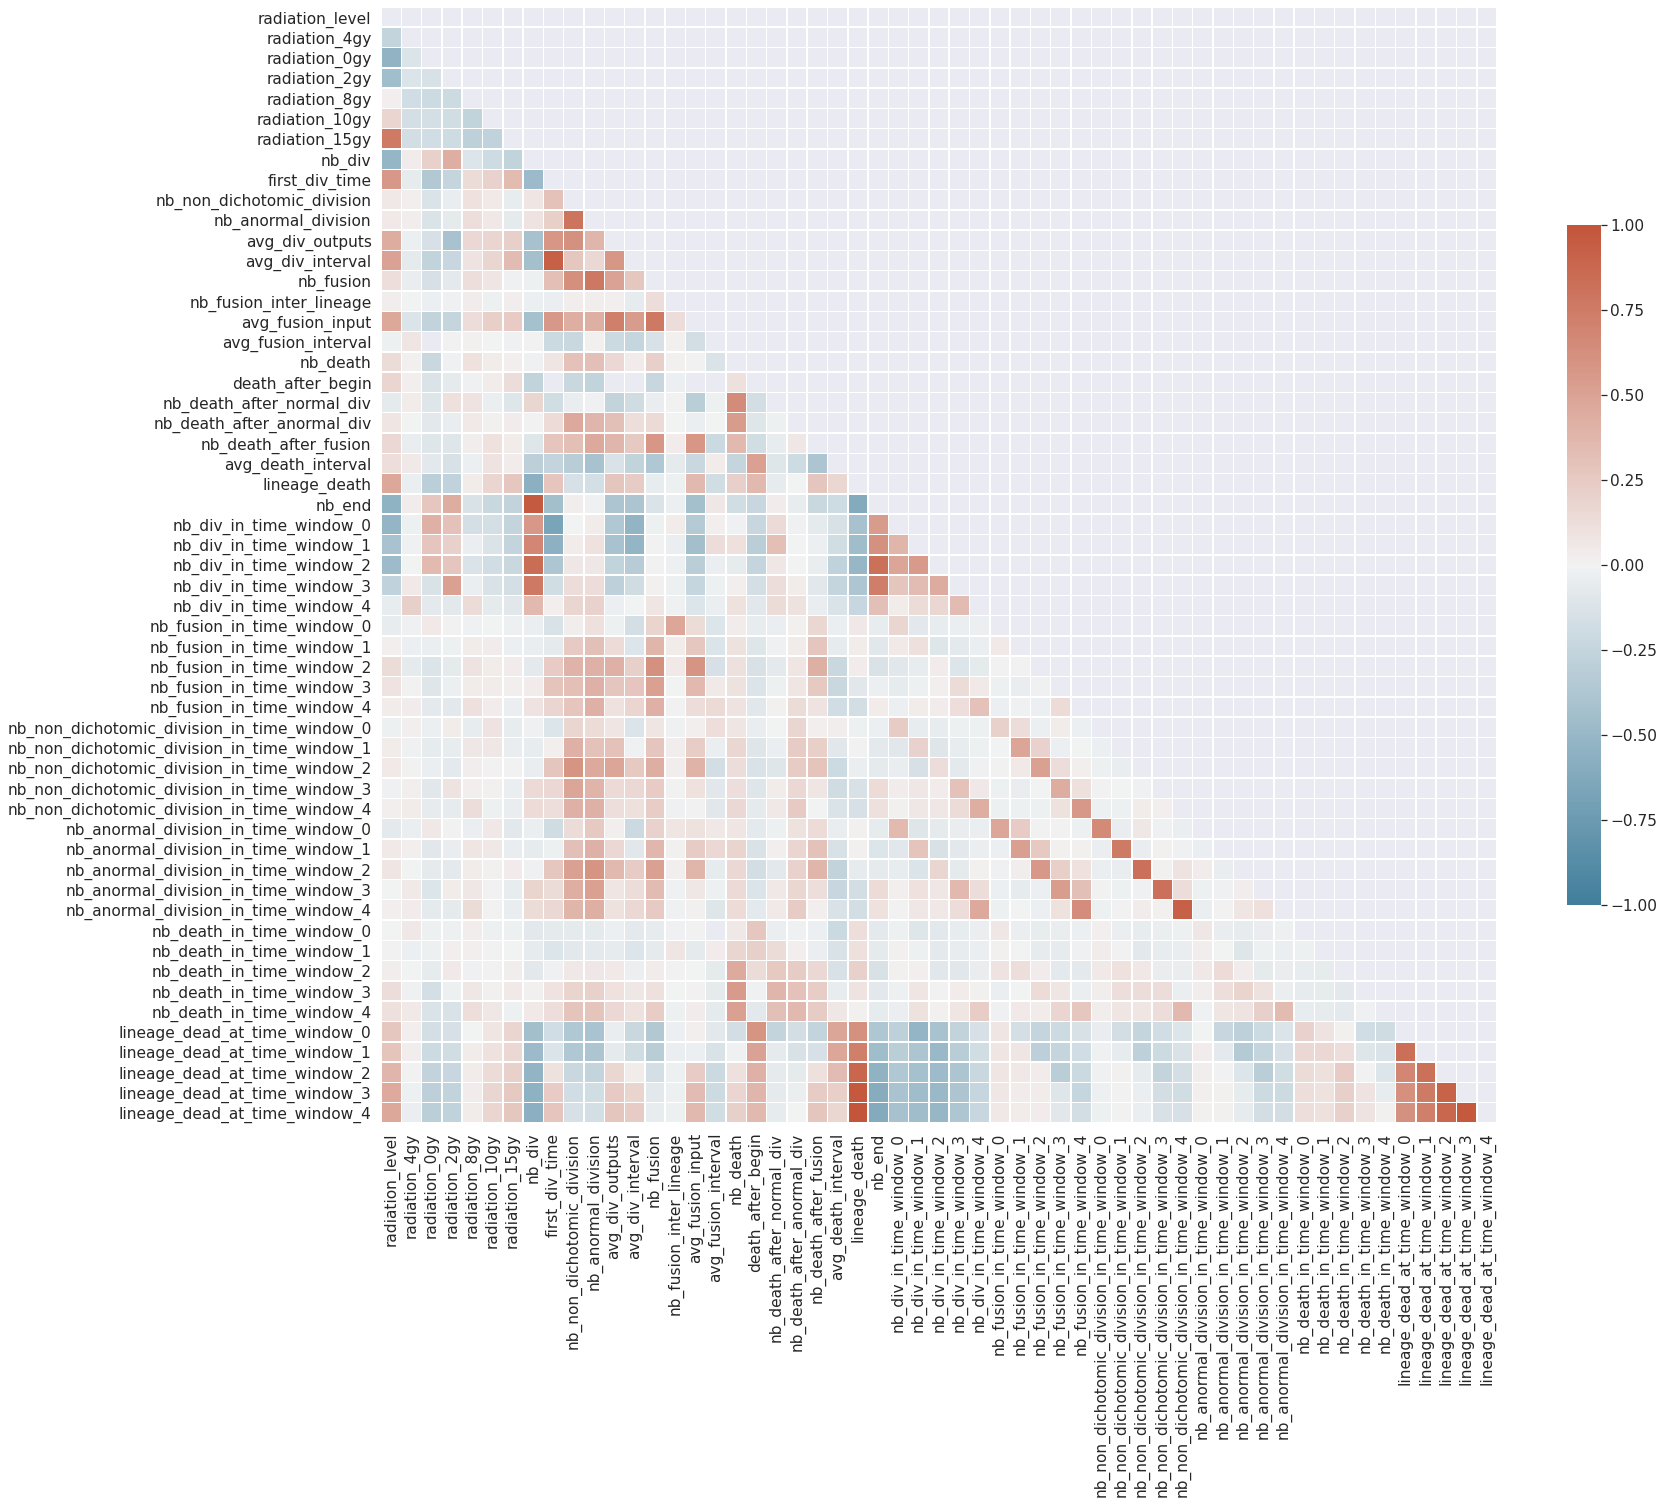

Heatmap of the correlation matrix of cell lineage properties for average of ['normal,n1', 'normal,n3', 'normal,n2']


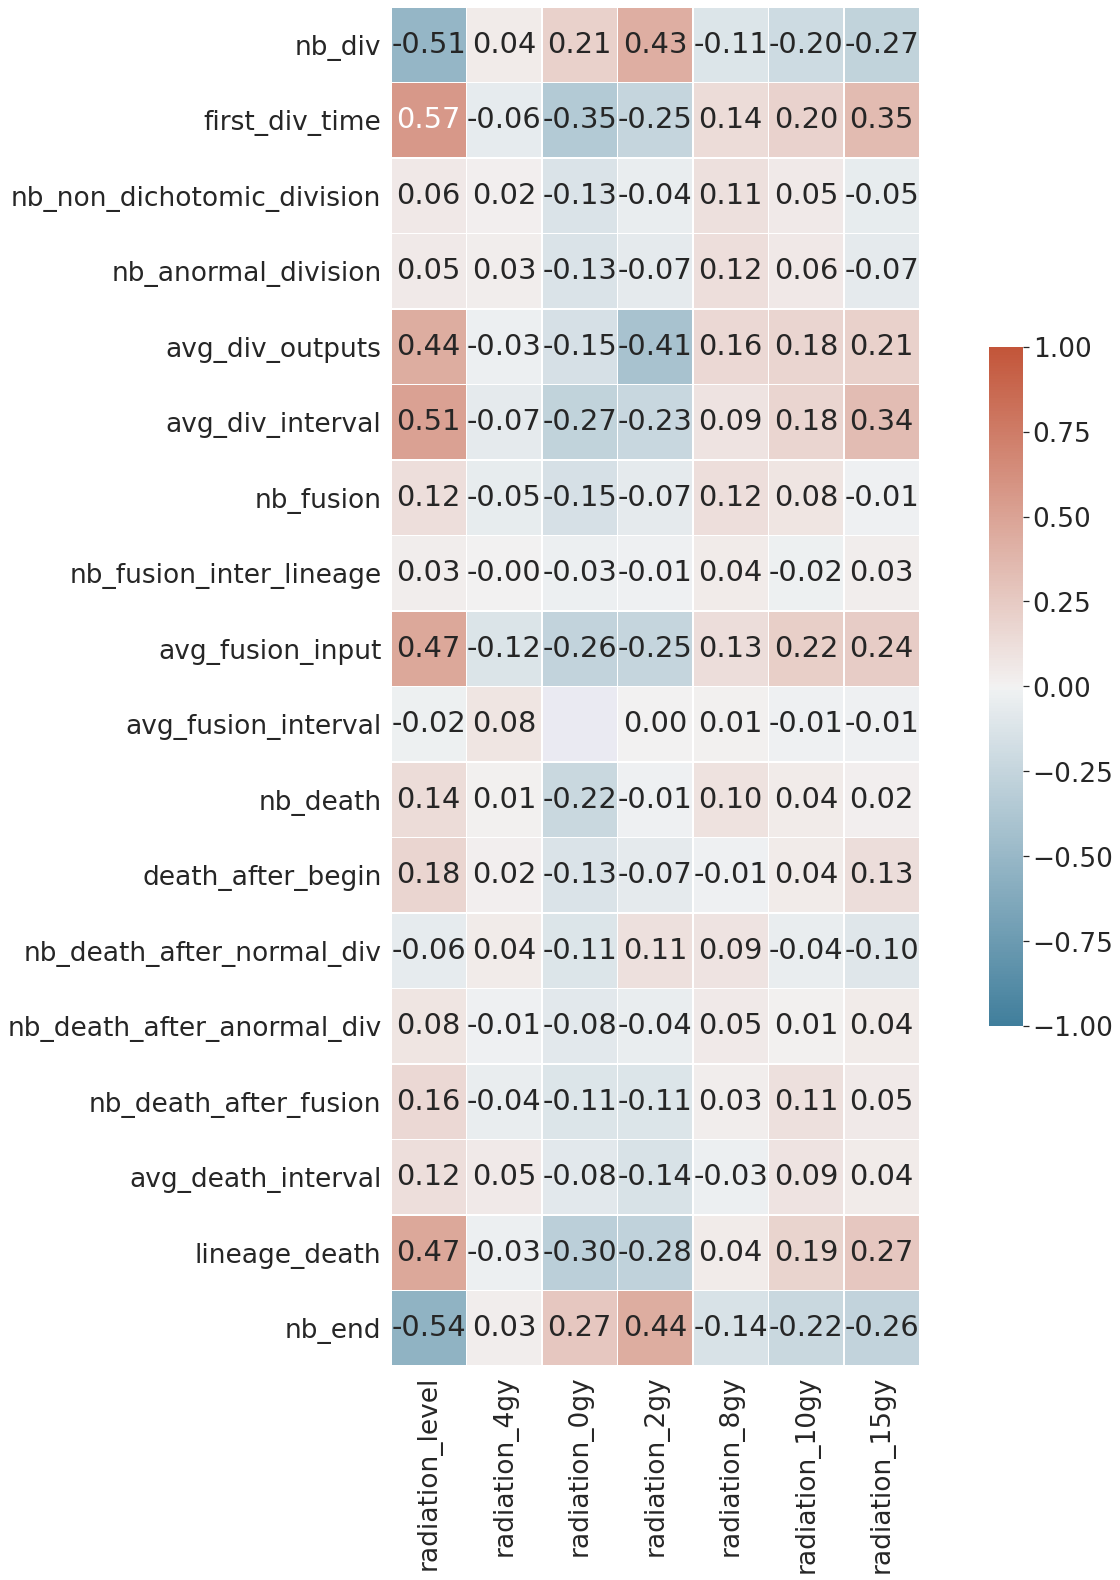

Heatmap of the correlation matrix of cell lineage properties for average of ['normal,n1', 'normal,n3', 'normal,n2']


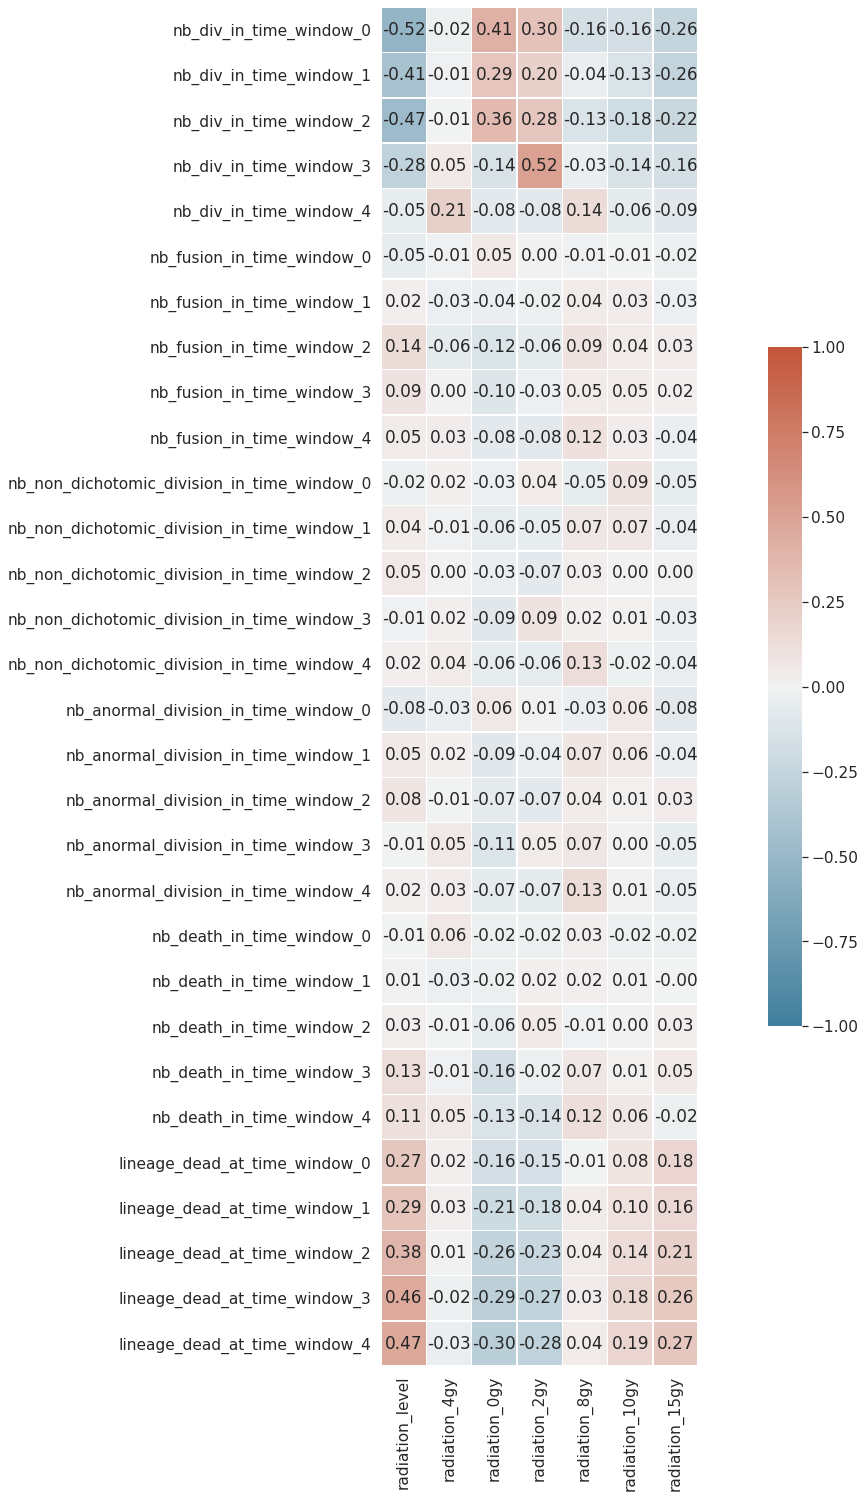

Heatmap of the correlation matrix of cell lineage properties for average of ['normal,n1', 'normal,n3', 'normal,n2']


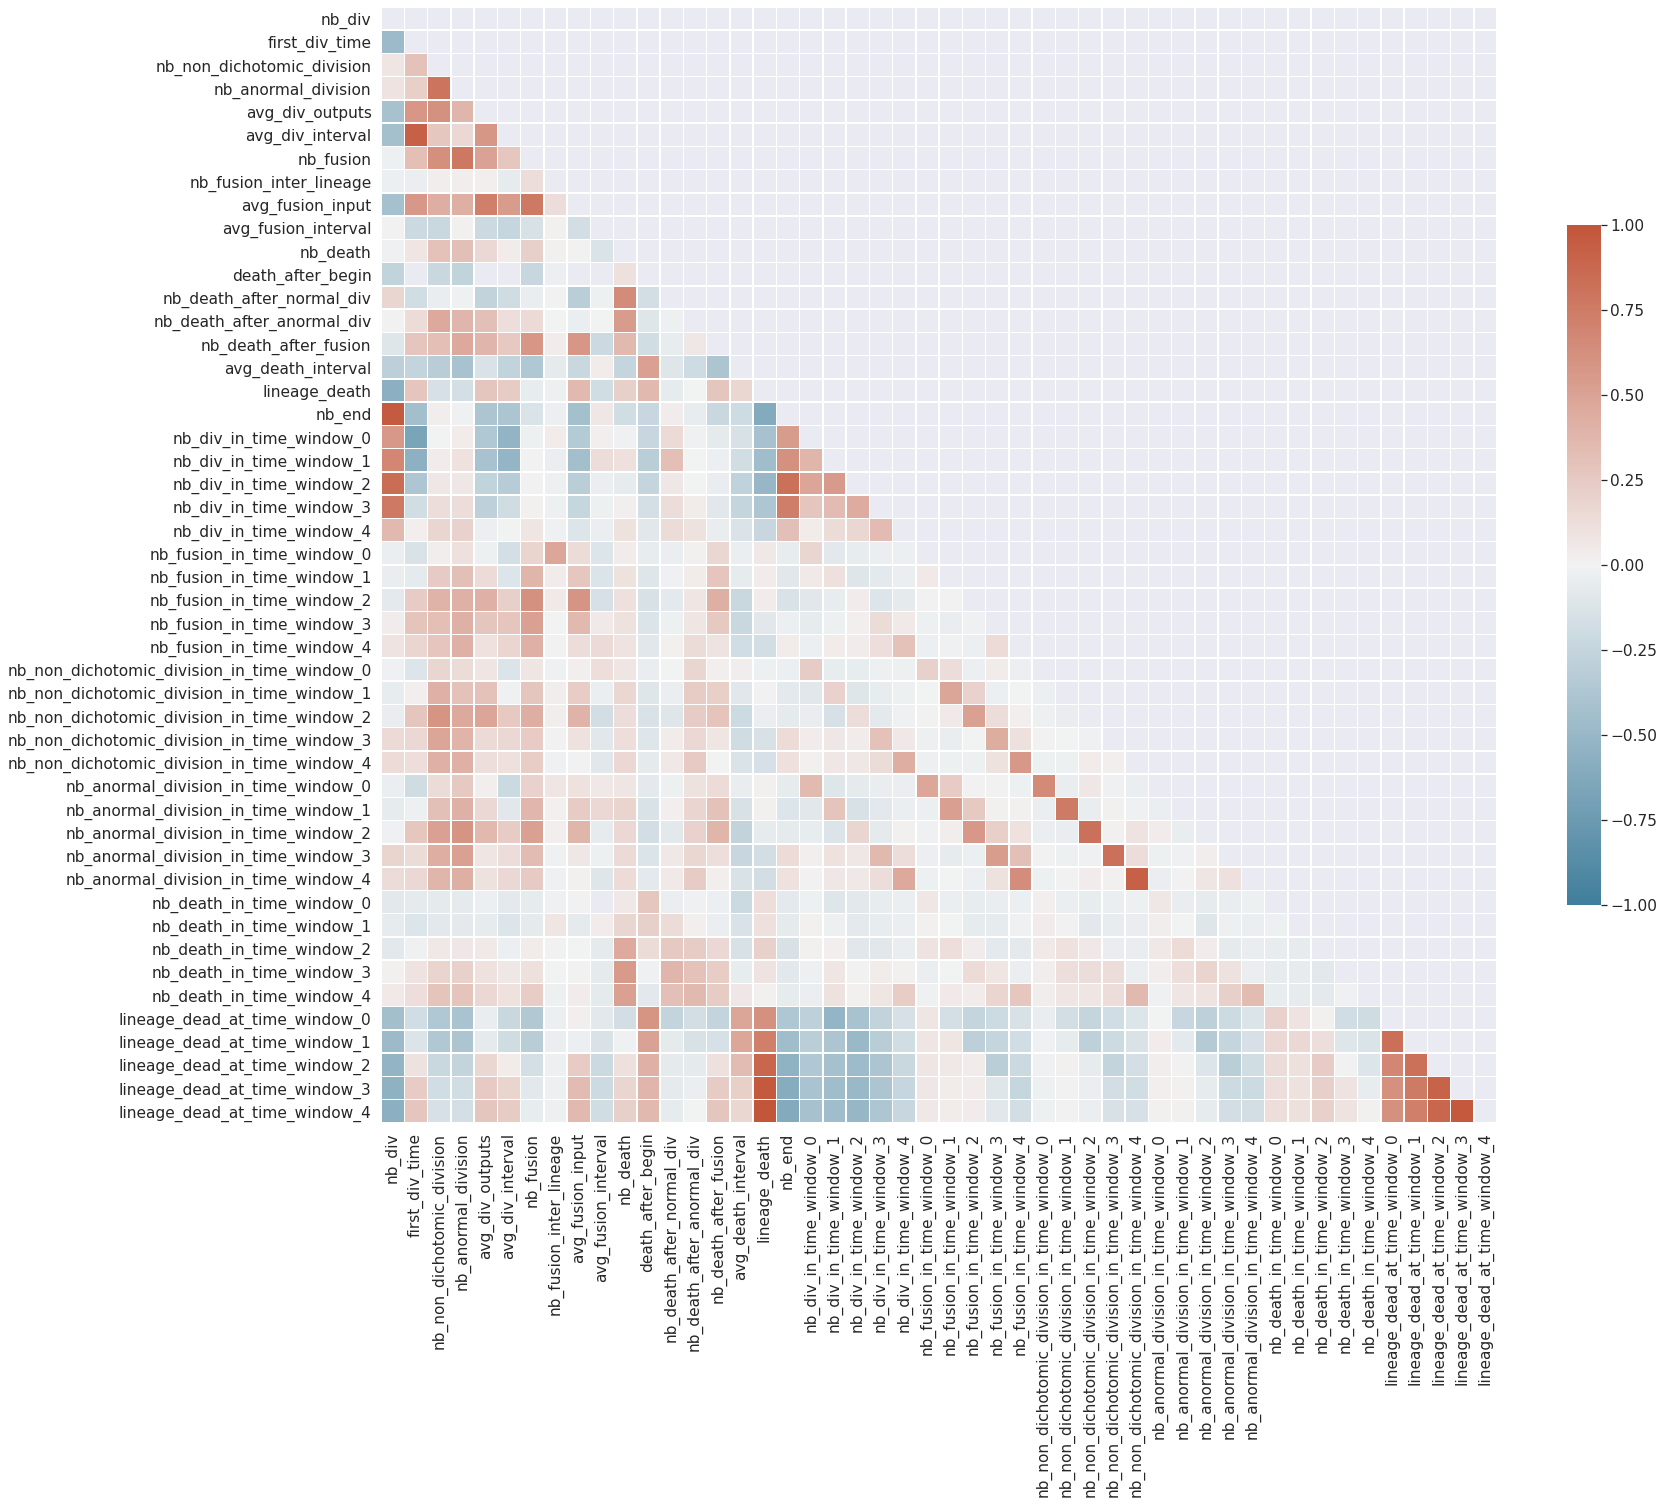

Heatmap of the correlation matrix of cell lineage properties for difference min/max of n1/n2/n3


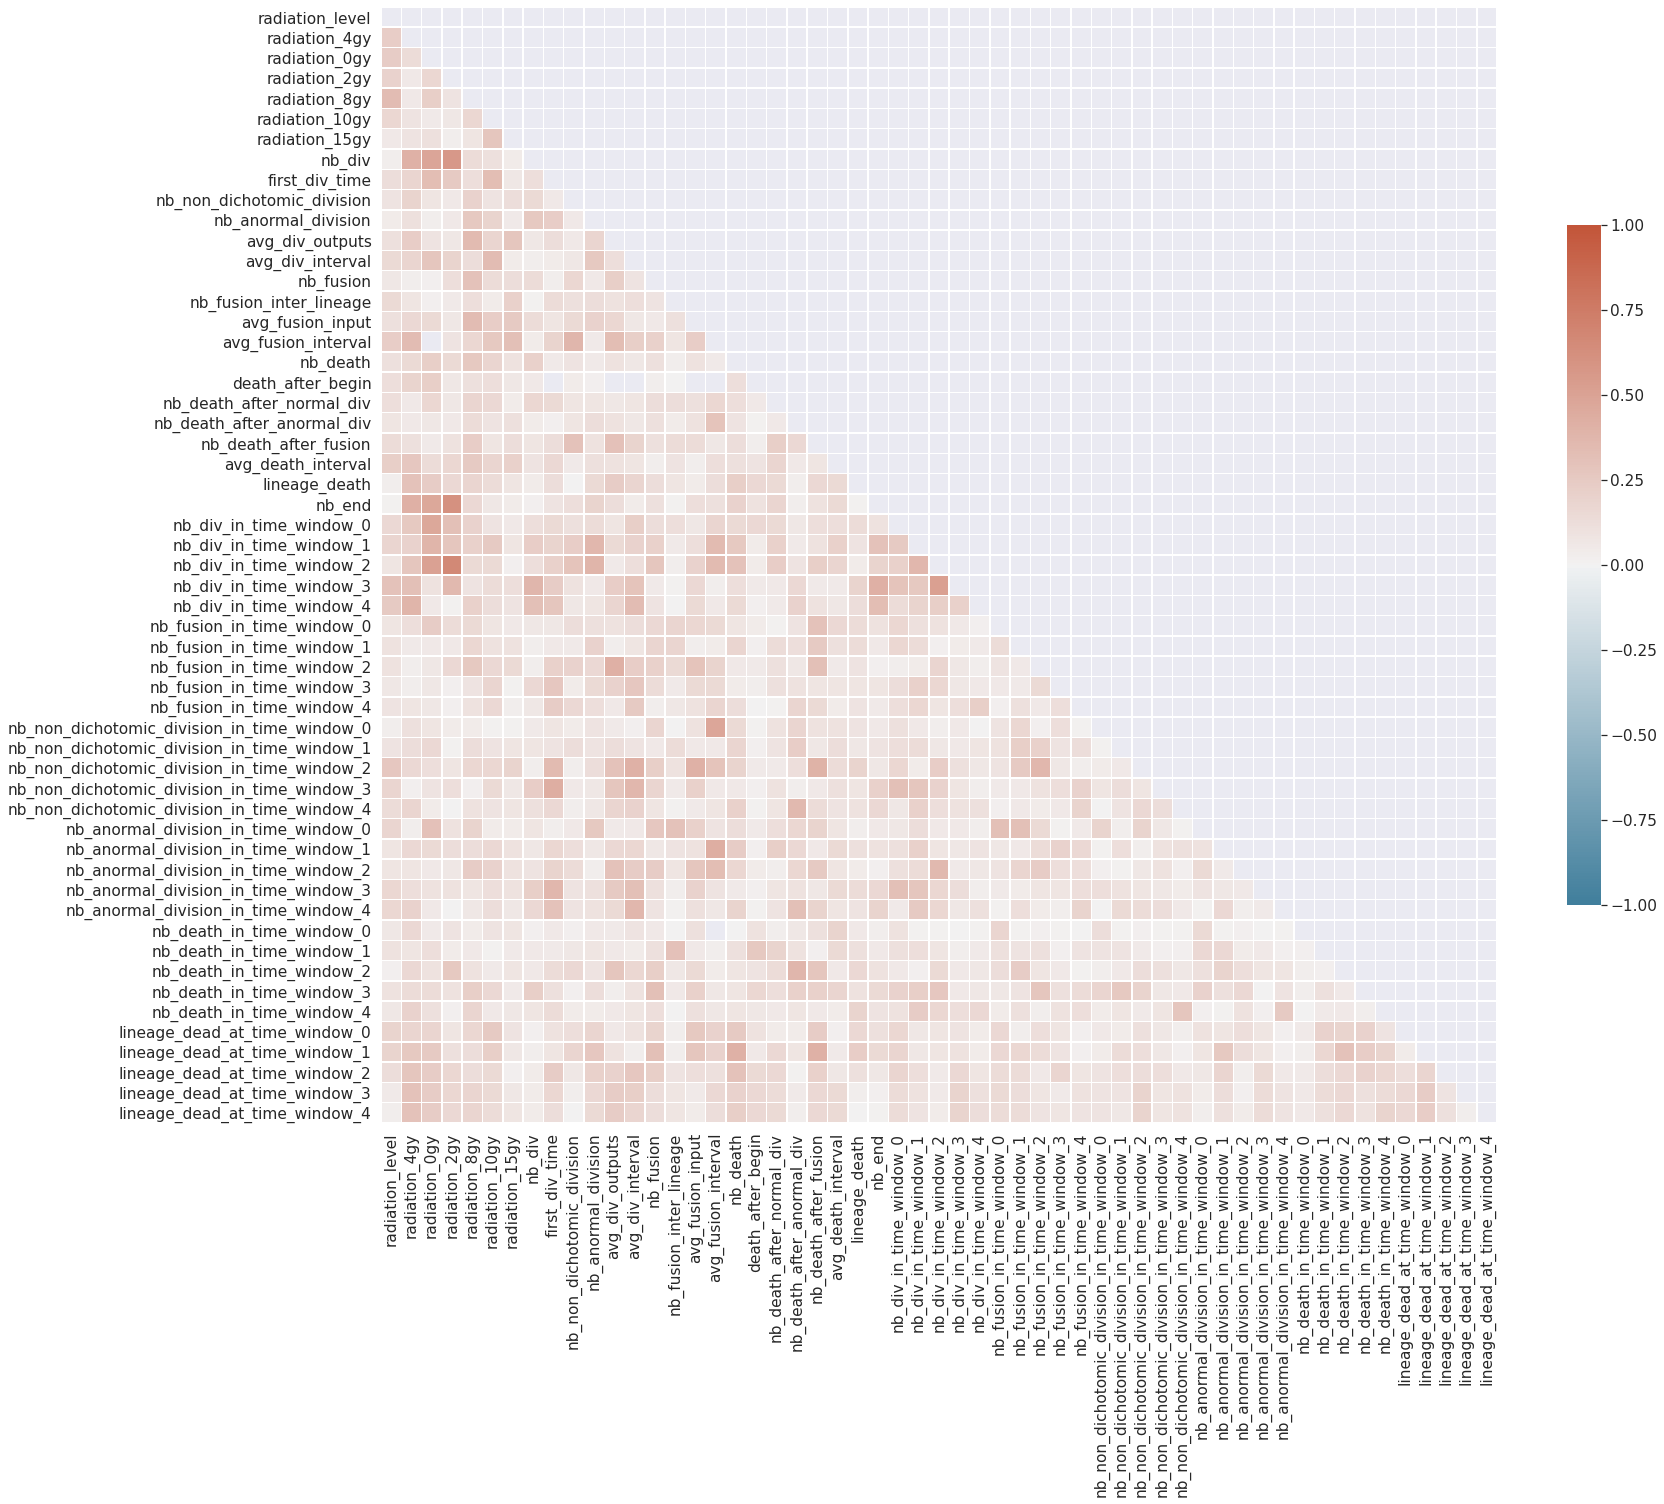

Heatmap of the correlation matrix of cell lineage properties for difference min/max of n2/n3


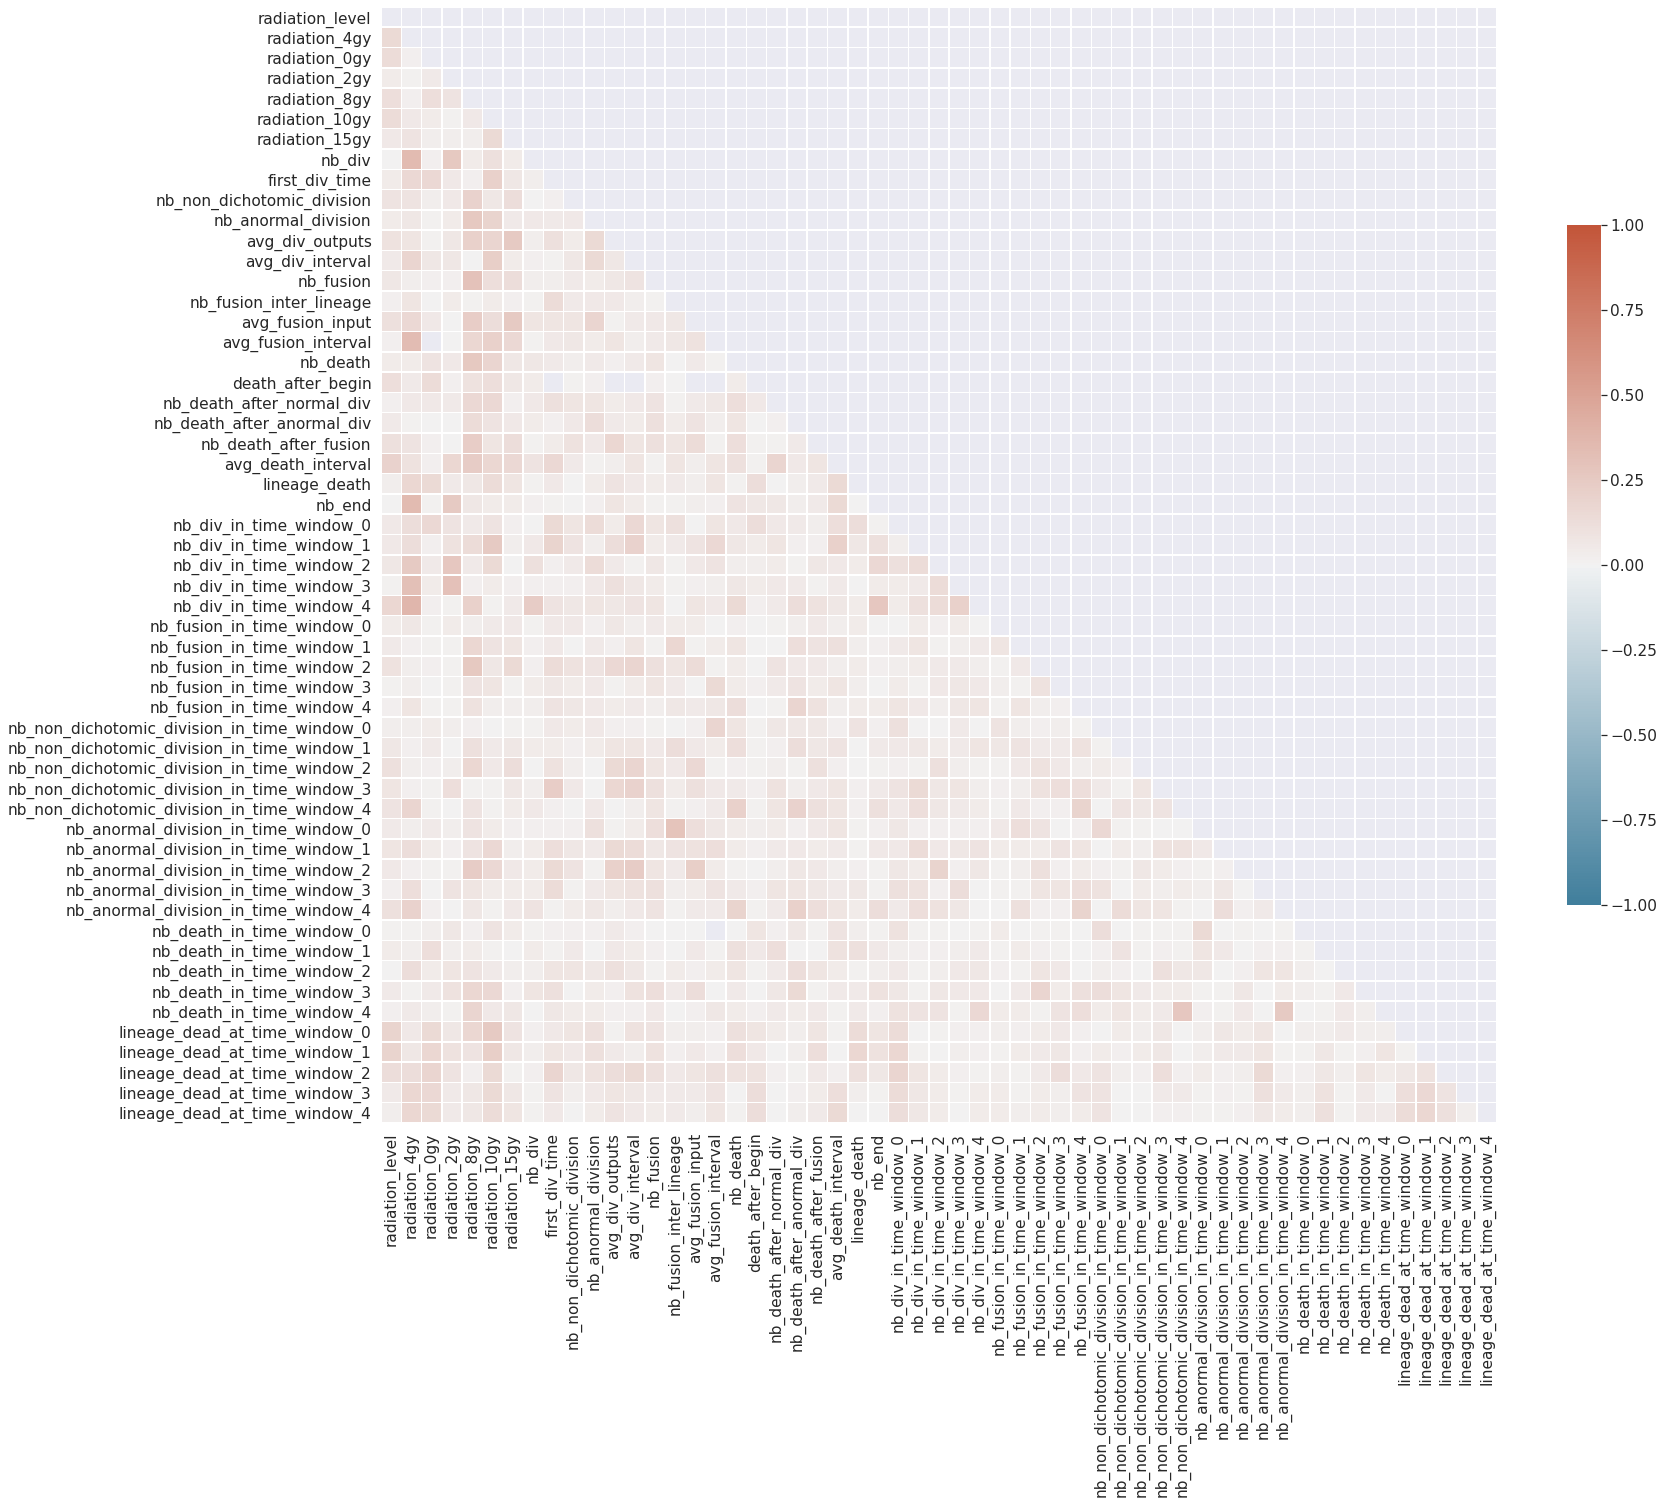

In [16]:
radiation_features = []

#if DATA_TYPE == "sox":
#    radiation_features += ["sox_ko"]

radiation_features += ["radiation_level"] + ["radiation_"+str(i)+"gy" for i in df_copy["radiation_level"].unique()]

corr_features = [
    # Div 
    "nb_div",
    "first_div_time",
    "nb_non_dichotomic_division",
    "nb_anormal_division",
    
    "avg_div_outputs", 
    "avg_div_interval",
    
    # Fusion
    "nb_fusion",
    "nb_fusion_inter_lineage",
    
    "avg_fusion_input",
    "avg_fusion_interval",
    
    # Death
    "nb_death",
    "death_after_begin",
    "nb_death_after_normal_div",
    "nb_death_after_anormal_div",
    "nb_death_after_fusion",
    
    "avg_death_interval",
    
    #"nb_simultaneous_event",
    #"sum_input_age",
     
    #"nb_div_in_time_window_0",
    #"nb_div_in_time_window_1",
    #"nb_div_in_time_window_2",
    #"nb_div_in_time_window_3",
    #"nb_div_in_time_window_4",
    
    #"nb_fusion_in_time_window_0",
    #"nb_fusion_in_time_window_1",
    #"nb_fusion_in_time_window_2",
    #"nb_fusion_in_time_window_3",
    #"nb_fusion_in_time_window_4",
    
    #"nb_non_dichotomic_division_in_time_window_0",
    #"nb_non_dichotomic_division_in_time_window_1",
    #"nb_non_dichotomic_division_in_time_window_2",
    #"nb_non_dichotomic_division_in_time_window_3",
    #"nb_non_dichotomic_division_in_time_window_4",
    
    #"nb_anormal_division_in_time_window_0",
    #"nb_anormal_division_in_time_window_1",
    #"nb_anormal_division_in_time_window_2",
    #"nb_anormal_division_in_time_window_3",
    #"nb_anormal_division_in_time_window_4",
    
    #"nb_death_in_time_window_0",
    #"nb_death_in_time_window_1",
    #"nb_death_in_time_window_2",
    #"nb_death_in_time_window_3",
    #"nb_death_in_time_window_4",
    
    "lineage_death",
    
    #"lineage_dead_at_time_window_0", 
    #"lineage_dead_at_time_window_1", 
    #"lineage_dead_at_time_window_2", 
    #"lineage_dead_at_time_window_3", 
    #"lineage_dead_at_time_window_4",
    
    "nb_end",
]

corr_features_time = [
    "nb_div_in_time_window_0",
    "nb_div_in_time_window_1",
    "nb_div_in_time_window_2",
    "nb_div_in_time_window_3",
    "nb_div_in_time_window_4",
    
    "nb_fusion_in_time_window_0",
    "nb_fusion_in_time_window_1",
    "nb_fusion_in_time_window_2",
    "nb_fusion_in_time_window_3",
    "nb_fusion_in_time_window_4",
    
    "nb_non_dichotomic_division_in_time_window_0",
    "nb_non_dichotomic_division_in_time_window_1",
    "nb_non_dichotomic_division_in_time_window_2",
    "nb_non_dichotomic_division_in_time_window_3",
    "nb_non_dichotomic_division_in_time_window_4",
    
    "nb_anormal_division_in_time_window_0",
    "nb_anormal_division_in_time_window_1",
    "nb_anormal_division_in_time_window_2",
    "nb_anormal_division_in_time_window_3",
    "nb_anormal_division_in_time_window_4",
    
    "nb_death_in_time_window_0",
    "nb_death_in_time_window_1",
    "nb_death_in_time_window_2",
    "nb_death_in_time_window_3",
    "nb_death_in_time_window_4",
    
    "lineage_dead_at_time_window_0", 
    "lineage_dead_at_time_window_1", 
    "lineage_dead_at_time_window_2", 
    "lineage_dead_at_time_window_3", 
    "lineage_dead_at_time_window_4",
]

selected_features = radiation_features + corr_features + corr_features_time

def plot_heatmap(corr, experiment_setting, triangle=False, annot=True):
    # Generate a mask for the upper triangle
    mask = None
    if triangle:
        mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(25, 25))
    
    print("Heatmap of the correlation matrix of cell lineage properties for "+experiment_setting)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=annot, fmt=".2f",
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
    plt.show()
    #ax.set_title("Heatmap of the correlation matrix of cell lineage properties for "+experiment_setting)

avg_corr = None
min_corr = None
max_corr = None
min_corr_n2_n3 = None
max_corr_n2_n3 = None

for experiment_setting in sorted(list(df_copy["experiment_setting"].unique())):
    #print(experiment_setting)
    df_ni = df_copy[df_copy["experiment_setting"] == experiment_setting]
    df_ni = df_ni[selected_features]
    #display(df_ni)
    corr = df_ni.corr().round(2)
    
    if avg_corr is None:
        avg_corr = corr.copy()
        min_corr = corr.copy()
        max_corr = corr.copy()
    else:
        avg_corr += corr
        min_corr = np.minimum(min_corr,corr)
        max_corr = np.maximum(max_corr,corr)
        
    #if DATA_TYPE == "normal":
    if "n2" in experiment_setting:
        min_corr_n2_n3 = corr
        max_corr_n2_n3 = corr

    if "n3" in experiment_setting:
        min_corr_n2_n3 = np.minimum(min_corr_n2_n3,corr)
        max_corr_n2_n3 = np.maximum(max_corr_n2_n3,corr)
        
    corr_left = corr[radiation_features][(corr.index.isin(corr_features))]
    corr_right = corr[corr_features][(corr.index.isin(corr_features))]
    
    corr_left_time = corr[radiation_features][(corr.index.isin(corr_features_time))]
    corr_right_time = corr[corr_features][(corr.index.isin(corr_features_time))]
    
    #plot_heatmap(corr, experiment_setting, True)
    #plot_heatmap(corr_left, experiment_setting)
    #plot_heatmap(corr_right, experiment_setting, True)

avg_corr /= len(list(df_copy["experiment_setting"].unique()))

corr_left = avg_corr[radiation_features][(avg_corr.index.isin(corr_features))].round(2)
#corr_right = avg_corr[corr_features][(avg_corr.index.isin(corr_features))]
corr_left_time = avg_corr[radiation_features][(avg_corr.index.isin(corr_features_time))]
#corr_right_time = avg_corr[corr_features][(avg_corr.index.isin(corr_features_time))]
corr_right = avg_corr[corr_features+corr_features_time][(avg_corr.index.isin(corr_features+corr_features_time))]
diff_corr = np.subtract(max_corr,min_corr) #np.absolute(max_corr) - np.absolute(min_corr)

#if DATA_TYPE == "normal":
diff_corr_n2_n3 = np.subtract(max_corr_n2_n3,min_corr_n2_n3) #np.absolute(max_corr) - np.absolute(min_corr)

sns.set(font_scale=1.4)

plot_heatmap(avg_corr, "average of "+ str(list(df_copy["experiment_setting"].unique())), True, False)
sns.set(font_scale=2.4)
plot_heatmap(corr_left, "average of "+str(list(df_copy["experiment_setting"].unique())), False, True)
sns.set(font_scale=1.4)
plot_heatmap(corr_left_time, "average of "+str(list(df_copy["experiment_setting"].unique())), False, True)
plot_heatmap(corr_right, "average of "+str(list(df_copy["experiment_setting"].unique())), True, False)
#plot_heatmap(corr_right_time, "average of n1/n2/n3", True, False)

plot_heatmap(diff_corr, "difference min/max of n1/n2/n3", True, False)

#if DATA_TYPE == "normal":
plot_heatmap(diff_corr_n2_n3, "difference min/max of n2/n3", True, False)

In [17]:
MIN_ABSOLUTE_CORRELATION_VALUE = 0.5

radiation_level_features = ["radiation_"+str(i)+"gy" for i in df_copy["radiation_level"].unique()]

#features = [i for i in df.columns if i not in ["cell_line_id", "experiment_setting"]]
#feature = "radiation_level"

df_output = pd.DataFrame([], columns=["feature_of_interest", "other_features", "avg_correlation", "min_max_correlation_difference"])
for index, feature in enumerate(selected_features):
    df_best_corr = avg_corr[(abs(avg_corr[feature]) >= MIN_ABSOLUTE_CORRELATION_VALUE)][[feature]]
    df_best_corr["min_correlation"] = min_corr[(abs(avg_corr[feature]) > MIN_ABSOLUTE_CORRELATION_VALUE)][feature]
    df_best_corr["max_correlation"] = max_corr[(abs(avg_corr[feature]) > MIN_ABSOLUTE_CORRELATION_VALUE)][feature]
    df_best_corr["min_max_correlation_difference"] = df_best_corr["max_correlation"] - df_best_corr["min_correlation"]
    df_best_corr["min_max_correlation_difference"] = df_best_corr["min_max_correlation_difference"].round(2).astype(str) +" ("+\
                                                     df_best_corr["min_correlation"].round(2).astype(str) +"/"+\
                                                     df_best_corr["max_correlation"].round(2).astype(str) +")"
    
    ignored_features = [feature] + radiation_level_features + ["cell_line_id", "experiment_setting"] + corr_features_time
    ignored_features += selected_features[0:index]
    
    df_best_corr = df_best_corr.reset_index().rename(columns={"index":"other_features"})
    df_best_corr = df_best_corr[~df_best_corr["other_features"].isin(ignored_features)]
    df_best_corr = df_best_corr.reindex(df_best_corr[feature].abs().sort_values(ascending=False).index)
    df_best_corr = df_best_corr.rename(columns={feature:"avg_correlation"})
    #df_output.round(2)
    df_best_corr["feature_of_interest"] = feature
    df_best_corr = df_best_corr[["feature_of_interest", "other_features", "avg_correlation", "min_max_correlation_difference"]]
    if (df_best_corr.size > 0):
        #display(df_best_corr.round(2))
        df_output = df_output.append(df_best_corr)
        
df_output = df_output.reset_index(drop=True).round(2)
pd.set_option('display.max_rows', 500)
pd.set_option('display.precision', 2)
df_output.style.hide_index()
print(df_output.to_latex(index=False))
df_output

\begin{tabular}{llrl}
\toprule
        feature\_of\_interest &              other\_features &  avg\_correlation & min\_max\_correlation\_difference \\
\midrule
            radiation\_level &              first\_div\_time &             0.57 &               0.13 (0.51/0.64) \\
            radiation\_level &                      nb\_end &            -0.54 &             0.01 (-0.55/-0.54) \\
            radiation\_level &                      nb\_div &            -0.51 &              0.03 (-0.53/-0.5) \\
            radiation\_level &            avg\_div\_interval &             0.51 &               0.15 (0.44/0.59) \\
                     nb\_div &                      nb\_end &             0.96 &               0.02 (0.95/0.97) \\
                     nb\_div &               lineage\_death &            -0.56 &             0.04 (-0.58/-0.54) \\
             first\_div\_time &            avg\_div\_interval &             0.93 &               0.04 (0.91/0.95) \\
             first\_div\_time &

feature_of_interest              other_features  avg_correlation  \
0              radiation_level              first_div_time             0.57   
1              radiation_level                      nb_end            -0.54   
2              radiation_level                      nb_div            -0.51   
3              radiation_level            avg_div_interval             0.51   
4                       nb_div                      nb_end             0.96   
5                       nb_div               lineage_death            -0.56   
6               first_div_time            avg_div_interval             0.93   
7               first_div_time             avg_div_outputs             0.58   
8               first_div_time            avg_fusion_input             0.56   
9   nb_non_dichotomic_division         nb_anormal_division             0.80   
10  nb_non_dichotomic_division                   nb_fusion             0.63   
11  nb_non_dichotomic_division             avg_div_outputs             0.61   
12         nb_anormal_division                   nb_fusion             0.78   
13             avg_div_outputs            avg_fusion_input             0.73   
14             avg_div_outputs            avg_div_interval             0.58   
15             avg_div_outputs                   nb_fusion             0.50   
16            avg_div_interval            avg_fusion_input             0.54   
17                   nb_fusion            avg_fusion_input             0.77   
18                   nb_fusion       nb_death_after_fusion             0.58   
19            avg_fusion_input       nb_death_after_fusion             0.58   
20                    nb_death   nb_death_after_normal_div             0.64   
21                    nb_death  nb_death_after_anormal_div             0.54   
22           death_after_begin          avg_death_interval             0.51   
23               lineage_death                      nb_end            -0.61   

   min_max_correlation_difference  
0                0.13 (0.51/0.64)  
1              0.01 (-0.55/-0.54)  
2               0.03 (-0.53/-0.5)  
3                0.15 (0.44/0.59)  
4                0.02 (0.95/0.97)  
5              0.04 (-0.58/-0.54)  
6                0.04 (0.91/0.95)  
7                0.13 (0.53/0.66)  
8                0.08 (0.53/0.61)  
9                0.06 (0.76/0.82)  
10                0.17 (0.53/0.7)  
11               0.06 (0.58/0.64)  
12               0.06 (0.75/0.81)  
13               0.17 (0.62/0.79)  
14               0.12 (0.52/0.64)  
15                0.22 (0.38/0.6)  
16               0.07 (0.51/0.58)  
17                0.06 (0.74/0.8)  
18               0.11 (0.53/0.64)  
19                0.14 (0.5/0.64)  
20               0.12 (0.57/0.69)  
21                0.09 (0.51/0.6)  
22               0.09 (0.48/0.57)  
23             0.01 (-0.62/-0.61)

# Correlation heatmap between normal and sox experiements

In [18]:
df_copy = df[df["version"] == "max_time_432"].copy()
common_radiation_levels = df_copy[df_copy["experiment_setting"].str.contains("sox")]["radiation_level"].unique()
df_copy = df_copy[df_copy["radiation_level"].isin(common_radiation_levels)]
cols = []
for i in sorted(df_copy["radiation_level"].unique()):
    col_name = "normal_radiation_"+str(i)+"gy"
    cols.append(col_name)
    df_copy[col_name] = (df["experiment_setting"].str.contains("normal")) & (df["radiation_level"] == i)
    
    col_name = "crispr_radiation_"+str(i)+"gy"
    cols.append(col_name)
    df_copy[col_name] = (df["experiment_setting"].str.contains("ct")) & (df["radiation_level"] == i)
    
    col_name = "sox_ko_radiation_"+str(i)+"gy"
    cols.append(col_name)
    df_copy[col_name] = (df["experiment_setting"].str.contains("ko")) & (df["radiation_level"] == i)
    
cols.extend([i for i in df_copy.columns.tolist() if i not in ["radiation_level","cell_line_id", "experiment_setting"]+cols])
df_copy = df_copy[["cell_line_id", "experiment_setting", "radiation_level"]+cols]
df_copy

cell_line_id experiment_setting  radiation_level  \
5     160930.nd2u2514gyp3_C1          normal,n1                4   
6     160930.nd2u2514gyp3_C2          normal,n1                4   
7     160930.nd2u2514gyp3_C3          normal,n1                4   
8     160930.nd2u2514gyp3_C4          normal,n1                4   
9     160930.nd2u2514gyp3_C5          normal,n1                4   
...                      ...                ...              ...   
1629    2021-n2-CT-0Gy-6A_C2          sox,n2,ct                0   
1630    2021-n2-CT-0Gy-6A_C3          sox,n2,ct                0   
1631    2021-n2-CT-0Gy-6A_C4          sox,n2,ct                0   
1632    2021-n2-CT-0Gy-6A_C5          sox,n2,ct                0   
1633    2021-n2-CT-0Gy-6A_C6          sox,n2,ct                0   

      normal_radiation_0gy  crispr_radiation_0gy  sox_ko_radiation_0gy  \
5                    False                 False                 False   
6                    False                 False                 False   
7                    False                 False                 False   
8                    False                 False                 False   
9                    False                 False                 False   
...                    ...                   ...                   ...   
1629                 False                  True                 False   
1630                 False                  True                 False   
1631                 False                  True                 False   
1632                 False                  True                 False   
1633                 False                  True                 False   

      normal_radiation_4gy  crispr_radiation_4gy  sox_ko_radiation_4gy  \
5                     True                 False                 False   
6                     True                 False                 False   
7                     True                 False                 False   
8                     True                 False                 False   
9                     True                 False                 False   
...                    ...                   ...                   ...   
1629                 False                 False                 False   
1630                 False                 False                 False   
1631                 False                 False                 False   
1632                 False                 False                 False   
1633                 False                 False                 False   

      lineage_death  ...  nb_death_in_time_window_2  \
5              True  ...                          0   
6              True  ...                          0   
7              True  ...                          0   
8              True  ...                          0   
9              True  ...                          0   
...             ...  ...                        ...   
1629           True  ...                          0   
1630           True  ...                          0   
1631           True  ...                          0   
1632           True  ...                          0   
1633           True  ...                          0   

      nb_death_in_time_window_3  nb_death_in_time_window_4  \
5                             0                          0   
6                             0                          0   
7                             0                          0   
8                             0                          0   
9                             0                          0   
...                         ...                        ...   
1629                          0                          0   
1630                          0                          0   
1631                          0                          0   
1632                          0                          0   
1633                          0                          0   

      lineage_d

sox_ko  radiation_level  normal_radiation_4gy  crispr_radiation_4gy  \
5      False                4                  True                 False   
6      False                4                  True                 False   
7      False                4                  True                 False   
8      False                4                  True                 False   
9      False                4                  True                 False   
...      ...              ...                   ...                   ...   
1403   False                0                 False                 False   
1404   False                0                 False                 False   
1405   False                0                 False                 False   
1406   False                0                 False                 False   
1407   False                0                 False                 False   

      sox_ko_radiation_4gy  normal_radiation_0gy  crispr_radiation_0gy  \
5                    False                 False                 False   
6                    False                 False                 False   
7                    False                 False                 False   
8                    False                 False                 False   
9                    False                 False                 False   
...                    ...                   ...                   ...   
1403                 False                 False                  True   
1404                 False                 False                  True   
1405                 False                 False                  True   
1406                 False                 False                  True   
1407                 False                 False                  True   

      sox_ko_radiation_0gy  nb_div  first_div_time  ...  \
5                    False     0.0             NaN  ...   
6                    False     0.0             NaN  ...   
7                    False     0.0             NaN  ...   
8                    False     0.0             NaN  ...   
9                    False     1.0           242.0  ...   
...                    ...     ...             ...  ...   
1403                 False     3.0           184.0  ...   
1404                 False     4.0            15.0  ...   
1405                 False     1.0           361.0  ...   
1406                 False     1.0           340.0  ...   
1407                 False     3.0           221.0  ...   

      nb_death_in_time_window_0  nb_death_in_time_window_1  \
5                             0                          0   
6                             0                          0   
7                             0                          0   
8                             0                          0   
9                             0                          0   
...                         ...                        ...   
1403                          0                          0   
1404                          0                          0   
1405                          0                          0   
1406                          0                          0   
1407                          0                          0   

      nb_death_in_time_window_2  nb_death_in_time_window_3  \
5                             0                          0   
6                             0                          0   
7                             0                          0   
8                             0                          0   
9                             0                          0   
...                         ...                        ...   
1403                          0                          0   
1404                          0                          0   
1405                          0                          0   
1406                          0                          0   
1407                          0                         

sox_ko  radiation_level  normal_radiation_4gy  crispr_radiation_4gy  \
5      False                4                  True                 False   
6      False                4                  True                 False   
7      False                4                  True                 False   
8      False                4                  True                 False   
9      False                4                  True                 False   
...      ...              ...                   ...                   ...   
1629   False                0                 False                 False   
1630   False                0                 False                 False   
1631   False                0                 False                 False   
1632   False                0                 False                 False   
1633   False                0                 False                 False   

      sox_ko_radiation_4gy  normal_radiation_0gy  crispr_radiation_0gy  \
5                    False                 False                 False   
6                    False                 False                 False   
7                    False                 False                 False   
8                    False                 False                 False   
9                    False                 False                 False   
...                    ...                   ...                   ...   
1629                 False                 False                  True   
1630                 False                 False                  True   
1631                 False                 False                  True   
1632                 False                 False                  True   
1633                 False                 False                  True   

      sox_ko_radiation_0gy  nb_div  first_div_time  ...  \
5                    False     0.0             NaN  ...   
6                    False     0.0             NaN  ...   
7                    False     0.0             NaN  ...   
8                    False     0.0             NaN  ...   
9                    False     1.0           242.0  ...   
...                    ...     ...             ...  ...   
1629                 False     7.0            66.0  ...   
1630                 False     3.0            49.0  ...   
1631                 False     6.0            63.0  ...   
1632                 False     7.0           100.0  ...   
1633                 False     0.0             NaN  ...   

      nb_death_in_time_window_0  nb_death_in_time_window_1  \
5                             0                          0   
6                             0                          0   
7                             0                          0   
8                             0                          0   
9                             0                          0   
...                         ...                        ...   
1629                          0                          0   
1630                          1                          0   
1631                          0                          0   
1632                          0                          0   
1633                          0                          0   

      nb_death_in_time_window_2  nb_death_in_time_window_3  \
5                             0                          0   
6                             0                          0   
7                             0                          0   
8                             0                          0   
9                             0                          0   
...                         ...                        ...   
1629                          0                          0   
1630                          0                          0   
1631                          0                          0   
1632                          0                          0   
1633                          0                         

Heatmap of the correlation matrix of cell lineage properties for average of ['n1', 'n2']


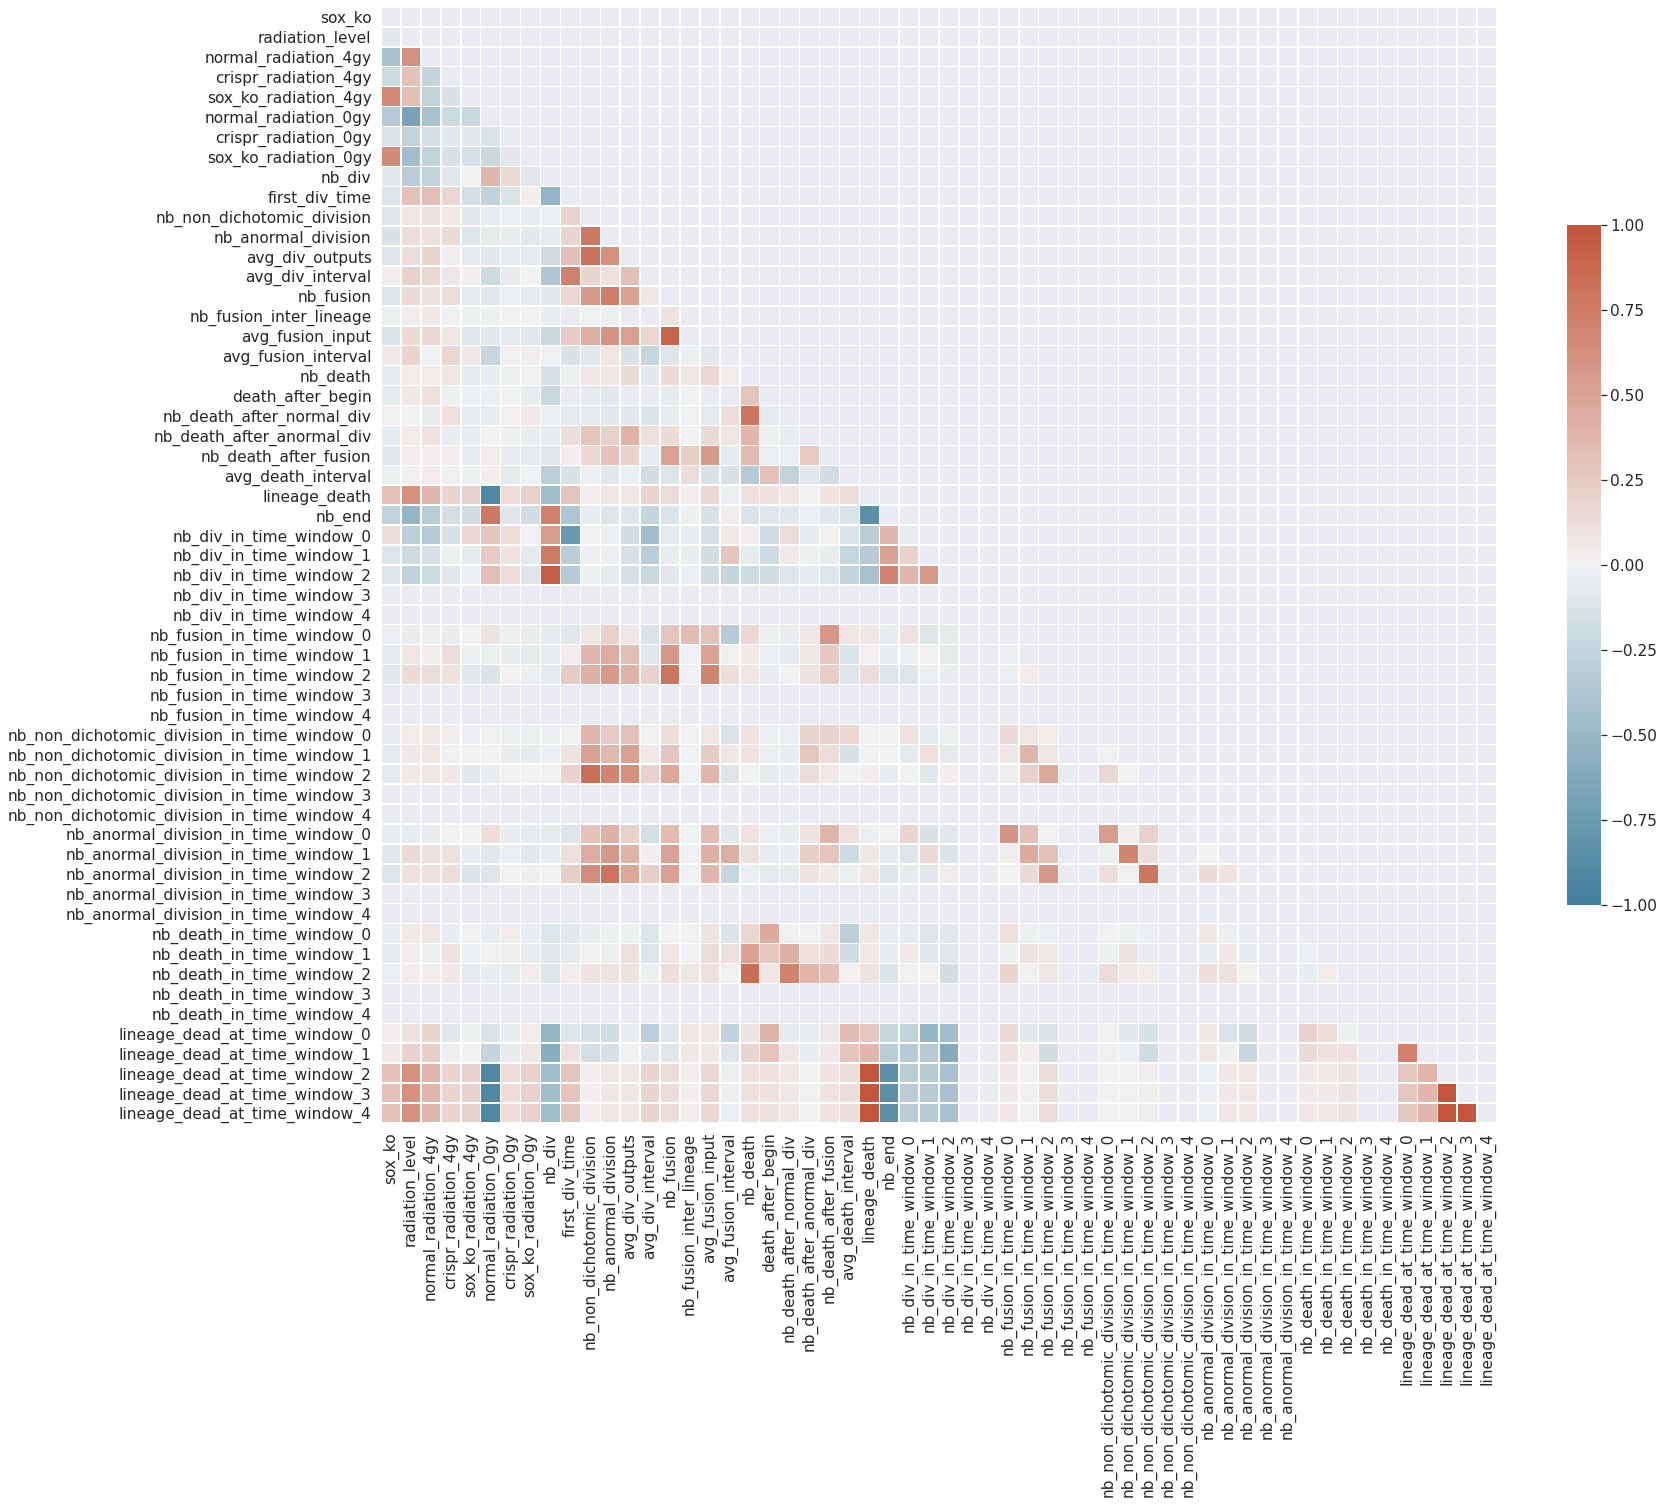

Heatmap of the correlation matrix of cell lineage properties for average of ['n1', 'n2']


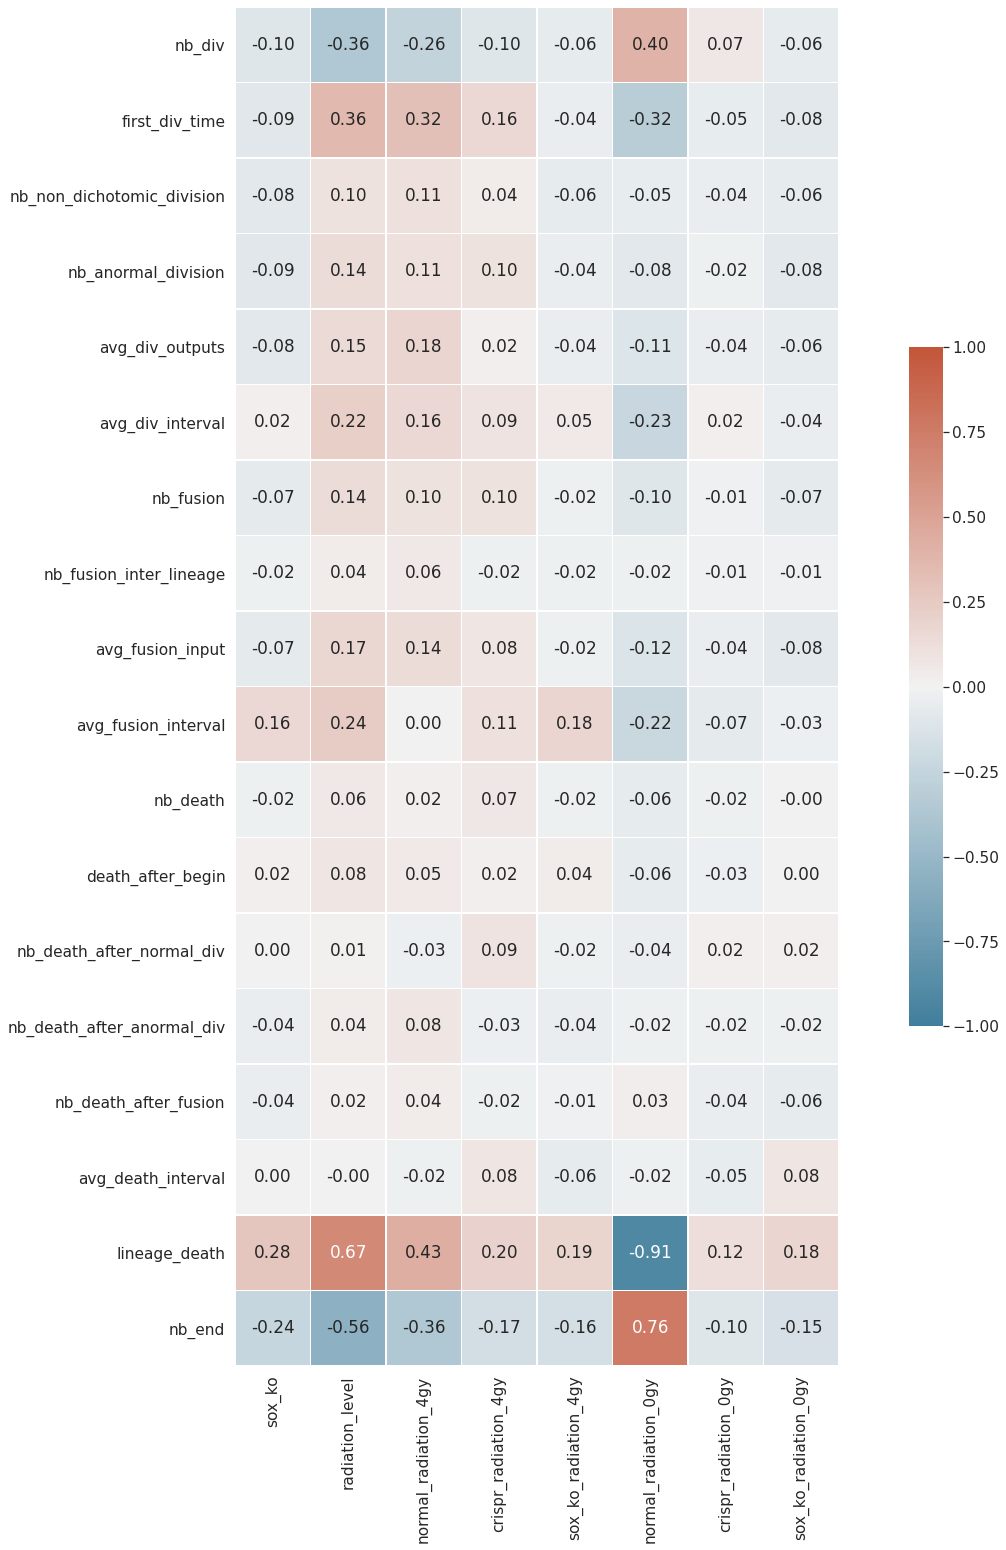

Heatmap of the correlation matrix of cell lineage properties for average of ['n1', 'n2']


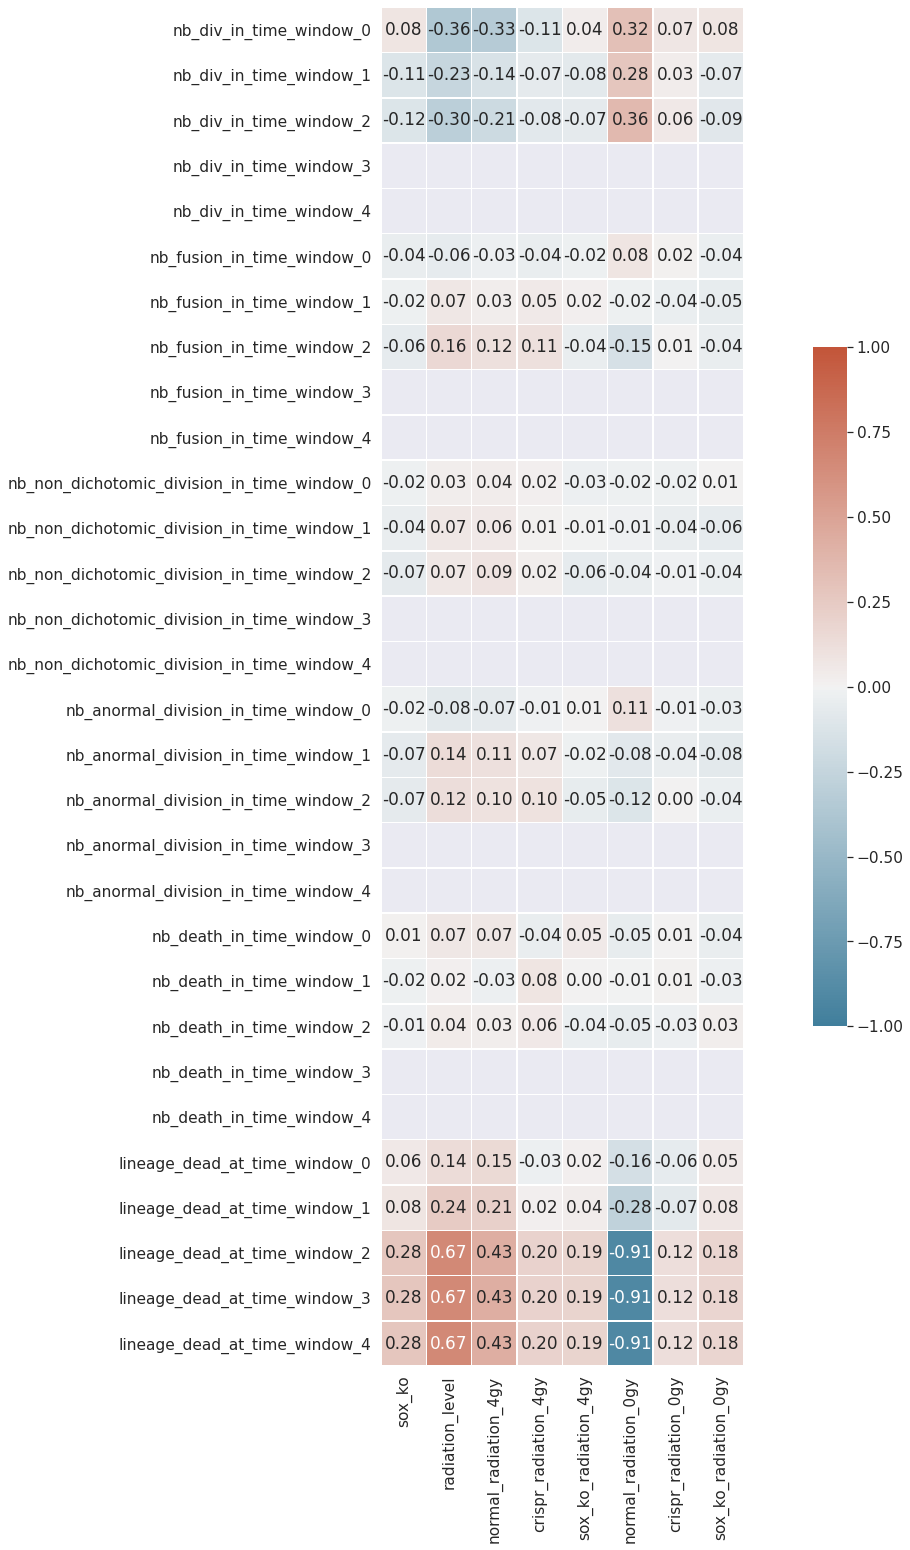

Heatmap of the correlation matrix of cell lineage properties for average of ['n1', 'n2']


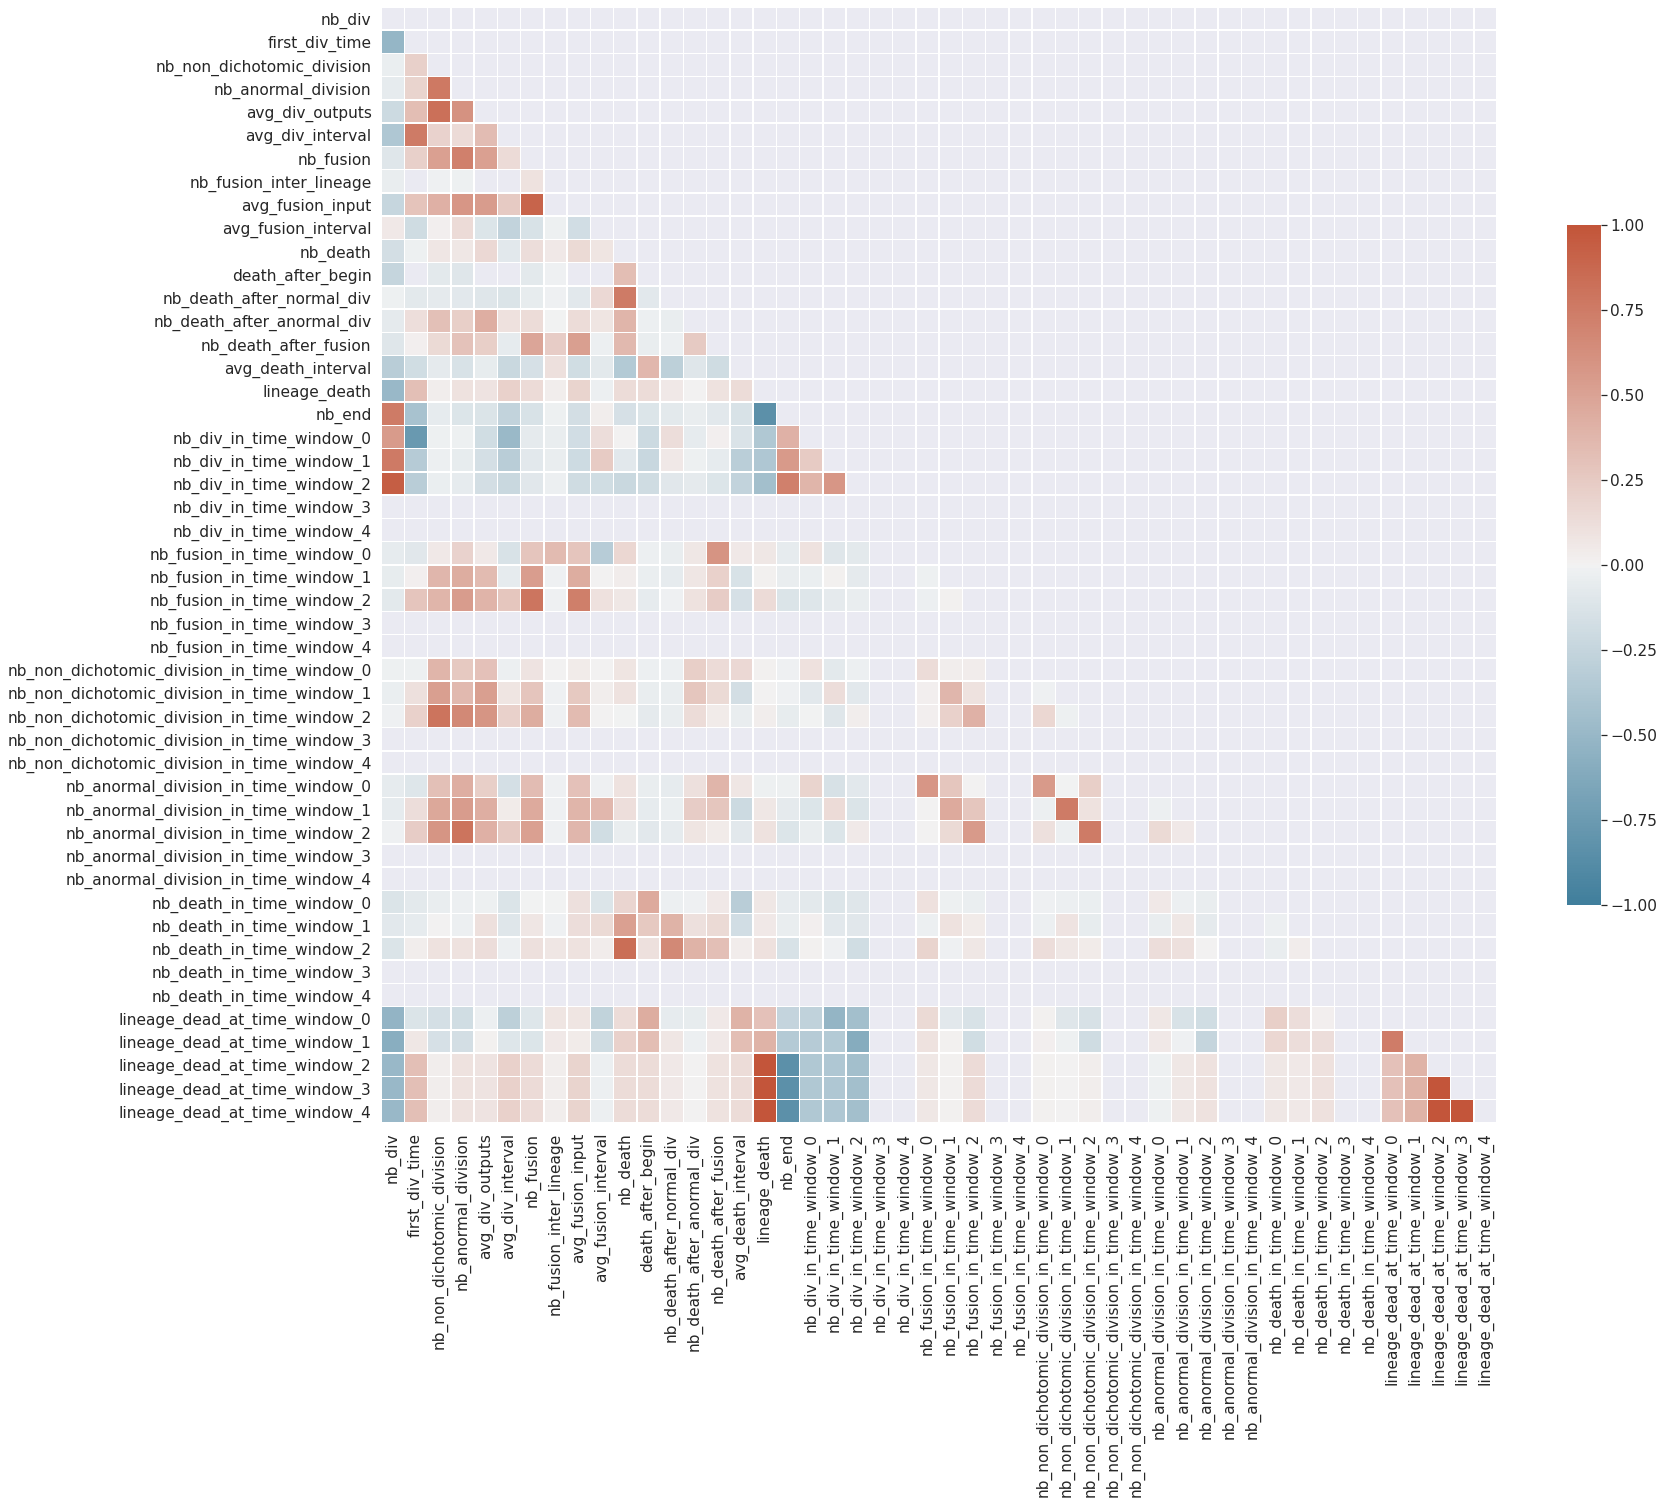

Heatmap of the correlation matrix of cell lineage properties for difference min/max of sox for ['n1', 'n2']


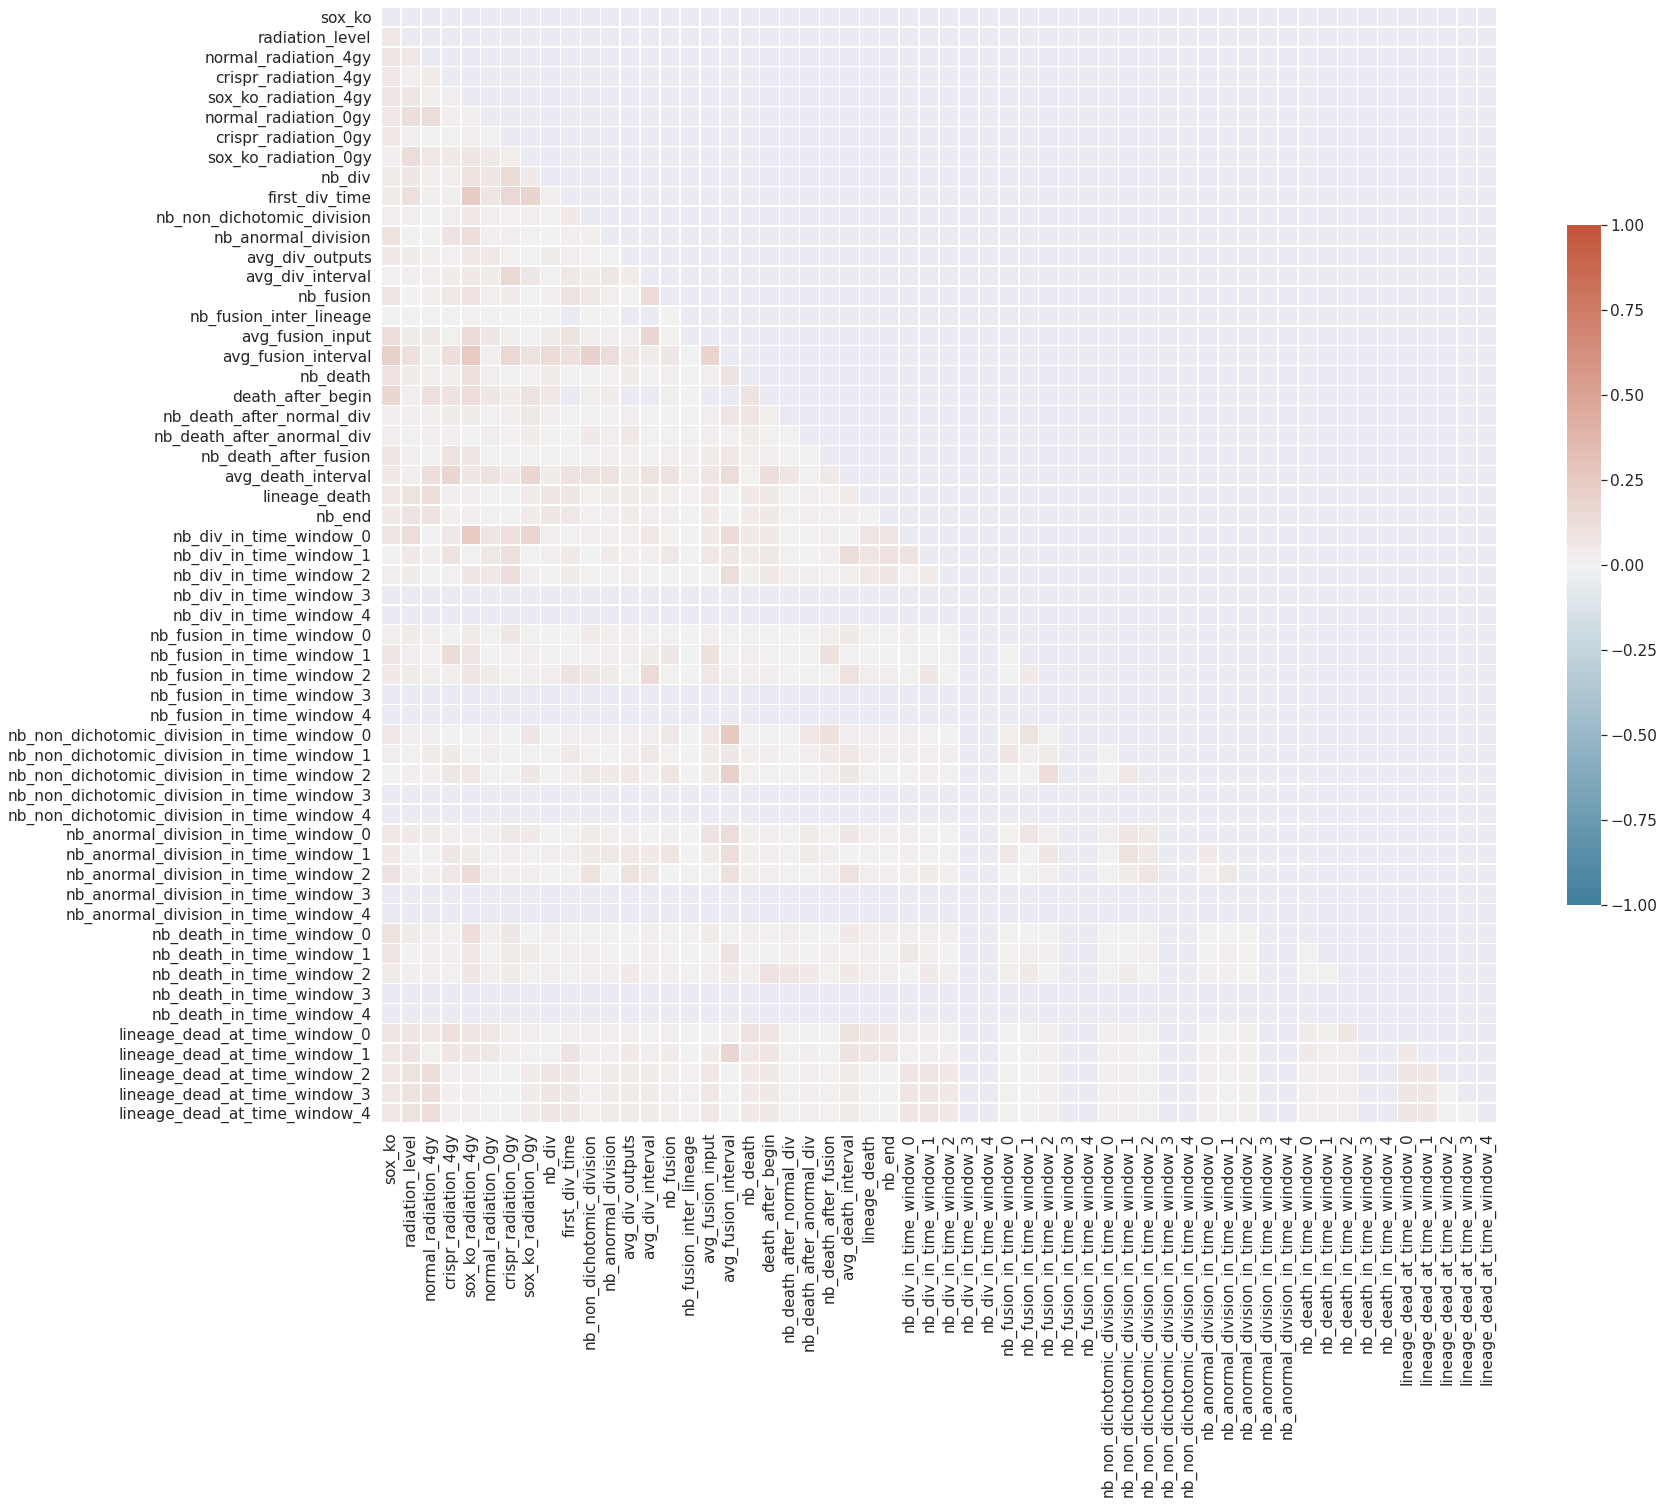

In [19]:
radiation_features = ["sox_ko"] + \
                    ["radiation_level"] + \
                    [exp_type+"_radiation_"+str(i)+"gy" for i in df_copy["radiation_level"].unique() for exp_type in ["normal", "crispr", "sox_ko"]]
corr_features = [
    # Div 
    "nb_div",
    "first_div_time",
    "nb_non_dichotomic_division",
    "nb_anormal_division",
    
    "avg_div_outputs", 
    "avg_div_interval",
    
    # Fusion
    "nb_fusion",
    "nb_fusion_inter_lineage",
    
    "avg_fusion_input",
    "avg_fusion_interval",
    
    # Death
    "nb_death",
    "death_after_begin",
    "nb_death_after_normal_div",
    "nb_death_after_anormal_div",
    "nb_death_after_fusion",
    
    "avg_death_interval",
    
    #"nb_simultaneous_event",
    #"sum_input_age",
     
    #"nb_div_in_time_window_0",
    #"nb_div_in_time_window_1",
    #"nb_div_in_time_window_2",
    #"nb_div_in_time_window_3",
    #"nb_div_in_time_window_4",
    
    #"nb_fusion_in_time_window_0",
    #"nb_fusion_in_time_window_1",
    #"nb_fusion_in_time_window_2",
    #"nb_fusion_in_time_window_3",
    #"nb_fusion_in_time_window_4",
    
    #"nb_non_dichotomic_division_in_time_window_0",
    #"nb_non_dichotomic_division_in_time_window_1",
    #"nb_non_dichotomic_division_in_time_window_2",
    #"nb_non_dichotomic_division_in_time_window_3",
    #"nb_non_dichotomic_division_in_time_window_4",
    
    #"nb_anormal_division_in_time_window_0",
    #"nb_anormal_division_in_time_window_1",
    #"nb_anormal_division_in_time_window_2",
    #"nb_anormal_division_in_time_window_3",
    #"nb_anormal_division_in_time_window_4",
    
    #"nb_death_in_time_window_0",
    #"nb_death_in_time_window_1",
    #"nb_death_in_time_window_2",
    #"nb_death_in_time_window_3",
    #"nb_death_in_time_window_4",
    
    "lineage_death",
    
    #"lineage_dead_at_time_window_0", 
    #"lineage_dead_at_time_window_1", 
    #"lineage_dead_at_time_window_2", 
    #"lineage_dead_at_time_window_3", 
    #"lineage_dead_at_time_window_4",
    
    "nb_end",
]

corr_features_time = [
    "nb_div_in_time_window_0",
    "nb_div_in_time_window_1",
    "nb_div_in_time_window_2",
    "nb_div_in_time_window_3",
    "nb_div_in_time_window_4",
    
    "nb_fusion_in_time_window_0",
    "nb_fusion_in_time_window_1",
    "nb_fusion_in_time_window_2",
    "nb_fusion_in_time_window_3",
    "nb_fusion_in_time_window_4",
    
    "nb_non_dichotomic_division_in_time_window_0",
    "nb_non_dichotomic_division_in_time_window_1",
    "nb_non_dichotomic_division_in_time_window_2",
    "nb_non_dichotomic_division_in_time_window_3",
    "nb_non_dichotomic_division_in_time_window_4",
    
    "nb_anormal_division_in_time_window_0",
    "nb_anormal_division_in_time_window_1",
    "nb_anormal_division_in_time_window_2",
    "nb_anormal_division_in_time_window_3",
    "nb_anormal_division_in_time_window_4",
    
    "nb_death_in_time_window_0",
    "nb_death_in_time_window_1",
    "nb_death_in_time_window_2",
    "nb_death_in_time_window_3",
    "nb_death_in_time_window_4",
    
    "lineage_dead_at_time_window_0", 
    "lineage_dead_at_time_window_1", 
    "lineage_dead_at_time_window_2", 
    "lineage_dead_at_time_window_3", 
    "lineage_dead_at_time_window_4",
]

selected_features = radiation_features + corr_features + corr_features_time

def plot_heatmap(corr, experiment_setting, triangle=False, annot=True):
    # Generate a mask for the upper triangle
    mask = None
    if triangle:
        mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(25, 25))
    
    print("Heatmap of the correlation matrix of cell lineage properties for "+experiment_setting)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=annot, fmt=".2f",
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
    plt.show()
    #ax.set_title("Heatmap of the correlation matrix of cell lineage properties for "+experiment_setting)

####
avg_corr = None
min_corr = None
max_corr = None
min_corr_n2_n3 = None
max_corr_n2_n3 = None

settings = ["n1","n2"]
for experiement_group in settings:
    #print(experiment_setting)
    df_ni = df_copy[(~df_copy["experiment_setting"].str.contains("sox")) | (df_copy["experiment_setting"].str.contains(experiement_group))]
    df_ni = df_ni[selected_features]
    display(df_ni)
    corr = df_ni.corr().round(2)
    
    if avg_corr is None:
        avg_corr = corr.copy()
        min_corr = corr.copy()
        max_corr = corr.copy()
    else:
        avg_corr += corr
        min_corr = np.minimum(min_corr,corr)
        max_corr = np.maximum(max_corr,corr)

avg_corr /= len(settings)

corr_left = avg_corr[radiation_features][(avg_corr.index.isin(corr_features))].round(2)
corr_left_time = avg_corr[radiation_features][(avg_corr.index.isin(corr_features_time))]
corr_right = avg_corr[corr_features+corr_features_time][(avg_corr.index.isin(corr_features+corr_features_time))]
diff_corr = np.subtract(max_corr,min_corr)

sns.set(font_scale=1.4)

plot_heatmap(corr, "average of "+ str(settings), True, False)
plot_heatmap(corr_left, "average of "+str(settings), False, True)
plot_heatmap(corr_left_time, "average of "+str(settings), False, True)
plot_heatmap(corr_right, "average of "+str(settings), True, False)
#plot_heatmap(corr_right_time, "average of n1/n2/n3", True, False)

plot_heatmap(diff_corr, "difference min/max of sox for "+str(settings), True, False)

### Extract importants correlations

In [20]:
MIN_ABSOLUTE_CORRELATION_VALUE = 0.3

radiation_level_features = [exp_type+"_radiation_"+str(i)+"gy" for i in df_copy["radiation_level"].unique() for exp_type in ["normal", "crispr", "sox_ko"]]

#features = [i for i in df.columns if i not in ["cell_line_id", "experiment_setting"]]
#feature = "radiation_level"
        
df_output = pd.DataFrame([], columns=["feature_of_interest", "other_features", "avg_correlation", "min_max_correlation_difference"])
for index, feature in enumerate(selected_features):
    df_best_corr = avg_corr[(abs(avg_corr[feature]) >= MIN_ABSOLUTE_CORRELATION_VALUE)][[feature]]
    df_best_corr["min_correlation"] = min_corr[(abs(avg_corr[feature]) > MIN_ABSOLUTE_CORRELATION_VALUE)][feature]
    df_best_corr["max_correlation"] = max_corr[(abs(avg_corr[feature]) > MIN_ABSOLUTE_CORRELATION_VALUE)][feature]
    df_best_corr["min_max_correlation_difference"] = df_best_corr["max_correlation"] - df_best_corr["min_correlation"]
    df_best_corr["min_max_correlation_difference"] = df_best_corr["min_max_correlation_difference"].round(2).astype(str) +" ("+\
                                                     df_best_corr["min_correlation"].round(2).astype(str) +"/"+\
                                                     df_best_corr["max_correlation"].round(2).astype(str) +")"
    
    ignored_features = [feature] + radiation_level_features + ["cell_line_id", "experiment_setting"] + corr_features_time
    ignored_features += selected_features[0:index]
    
    df_best_corr = df_best_corr.reset_index().rename(columns={"index":"other_features"})
    df_best_corr = df_best_corr[~df_best_corr["other_features"].isin(ignored_features)]
    df_best_corr = df_best_corr.reindex(df_best_corr[feature].abs().sort_values(ascending=False).index)
    df_best_corr = df_best_corr.rename(columns={feature:"avg_correlation"})
    #df_output.round(2)
    df_best_corr["feature_of_interest"] = feature
    df_best_corr = df_best_corr[["feature_of_interest", "other_features", "avg_correlation", "min_max_correlation_difference"]]
    if (df_best_corr.size > 0):
        #display(df_best_corr.round(2))
        df_output = df_output.append(df_best_corr)
        
df_output = df_output.reset_index(drop=True).round(2)
pd.set_option('display.max_rows', 500)
pd.set_option('display.precision', 2)
df_output.style.hide_index()
print(df_output.to_latex(index=False))
df_output

\begin{tabular}{llrl}
\toprule
        feature\_of\_interest &              other\_features &  avg\_correlation & min\_max\_correlation\_difference \\
\midrule
            radiation\_level &               lineage\_death &             0.67 &                0.1 (0.62/0.72) \\
            radiation\_level &                      nb\_end &            -0.56 &             0.09 (-0.61/-0.52) \\
            radiation\_level &              first\_div\_time &             0.36 &                0.11 (0.3/0.41) \\
            radiation\_level &                      nb\_div &            -0.36 &             0.07 (-0.39/-0.32) \\
       normal\_radiation\_4gy &               lineage\_death &             0.43 &               0.12 (0.37/0.49) \\
       normal\_radiation\_4gy &                      nb\_end &            -0.36 &             0.09 (-0.41/-0.32) \\
       normal\_radiation\_4gy &              first\_div\_time &             0.32 &                0.03 (0.3/0.33) \\
       normal\_radiation\_0gy 

feature_of_interest              other_features  avg_correlation  \
0              radiation_level               lineage_death             0.67   
1              radiation_level                      nb_end            -0.56   
2              radiation_level              first_div_time             0.36   
3              radiation_level                      nb_div            -0.36   
4         normal_radiation_4gy               lineage_death             0.43   
5         normal_radiation_4gy                      nb_end            -0.36   
6         normal_radiation_4gy              first_div_time             0.32   
7         normal_radiation_0gy               lineage_death            -0.91   
8         normal_radiation_0gy                      nb_end             0.76   
9         normal_radiation_0gy                      nb_div             0.40   
10        normal_radiation_0gy              first_div_time            -0.32   
11                      nb_div                      nb_end             0.76   
12                      nb_div              first_div_time            -0.51   
13                      nb_div               lineage_death            -0.50   
14                      nb_div            avg_div_interval            -0.38   
15                      nb_div          avg_death_interval            -0.32   
16              first_div_time            avg_div_interval             0.75   
17              first_div_time                      nb_end            -0.41   
18              first_div_time             avg_div_outputs             0.34   
19              first_div_time               lineage_death             0.32   
20  nb_non_dichotomic_division             avg_div_outputs             0.82   
21  nb_non_dichotomic_division         nb_anormal_division             0.77   
22  nb_non_dichotomic_division                   nb_fusion             0.52   
23  nb_non_dichotomic_division            avg_fusion_input             0.42   
24  nb_non_dichotomic_division  nb_death_after_anormal_div             0.32   
25         nb_anormal_division                   nb_fusion             0.72   
26         nb_anormal_division             avg_div_outputs             0.60   
27         nb_anormal_division            avg_fusion_input             0.58   
28         nb_anormal_division       nb_death_after_fusion             0.30   
29             avg_div_outputs            avg_fusion_input             0.55   
30             avg_div_outputs                   nb_fusion             0.52   
31             avg_div_outputs  nb_death_after_anormal_div             0.43   
32             avg_div_outputs            avg_div_interval             0.34   
33                   nb_fusion            avg_fusion_input             0.90   
34                   nb_fusion       nb_death_after_fusion             0.48   
35            avg_fusion_input       nb_death_after_fusion             0.53   
36                    nb_death   nb_death_after_normal_div             0.75   
37                    nb_death  nb_death_after_anormal_div             0.39   
38                    nb_death       nb_death_after_fusion             0.36   
39                    nb_death          avg_death_interval            -0.34   
40                    nb_death           death_after_begin             0.34   
41           death_after_begin          avg_death_interval             0.37   
42               lineage_death                      nb_end            -0.84   

   min_max_correlation_difference  
0                 0.1 (0.62/0.72)  
1              0.09 (-0.61/-0.52)  
2                 0.11 (0.3/0.41)  
3              0.07 (-0.39/-0.32)  
4                0.12 (0.37/0.49)  
5              0.09 (-0.41/-0.32)  
6                 0.03 (0.3/0.33)  
7               0.0 (-0.91/-0.91)  
8                0.01 (0.76/0.77)  
9                0.07 (0.37/0.44)  
10             0.08 (-0.36/-0.28)  
11               0.07 (0.72/0.79)  
12              0.02 (-0.52/-0.5)  
13             0.07 (-0.53/-0.

In [21]:
!mkdir crispr_distributions

Ploting nb_div
Ploting first_div_time
Ploting nb_non_dichotomic_division


/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Ploting nb_anormal_division


/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Ploting avg_div_outputs
Ploting avg_div_interval
Ploting nb_fusion


/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Ploting nb_fusion_inter_lineage


/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 34.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Ploting avg_fusion_input
Ploting avg_fusion_interval
Ploting nb_death


/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Ploting death_after_begin


/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 28.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Ploting nb_death_after_normal_div


/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 24.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Ploting nb_death_after_anormal_div


/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Ploting nb_death_after_fusion


/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Ploting avg_death_interval
Ploting nb_end


/home/keijuro/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 34.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


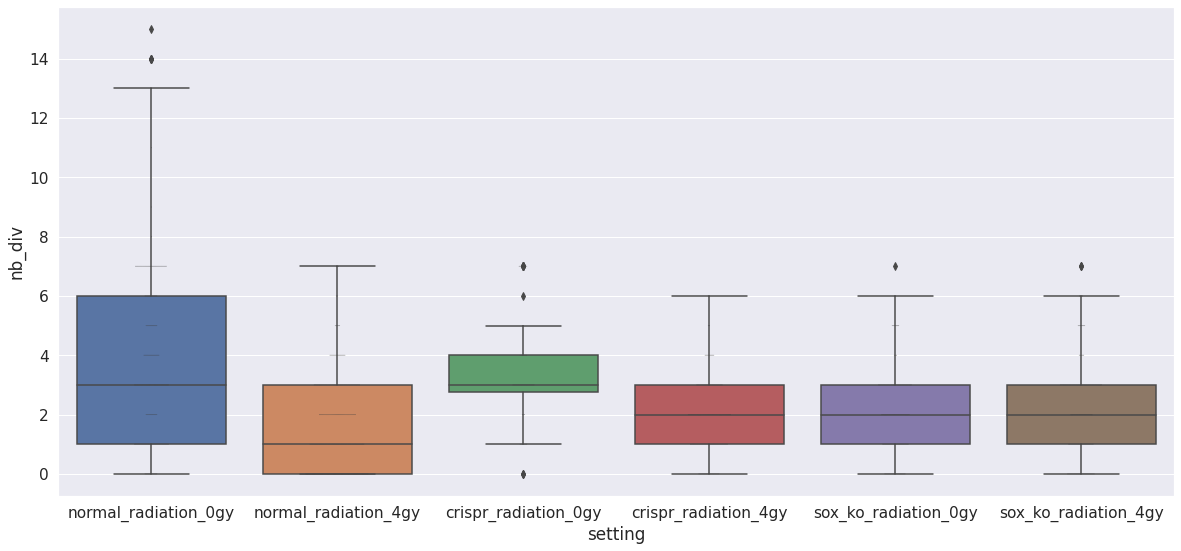

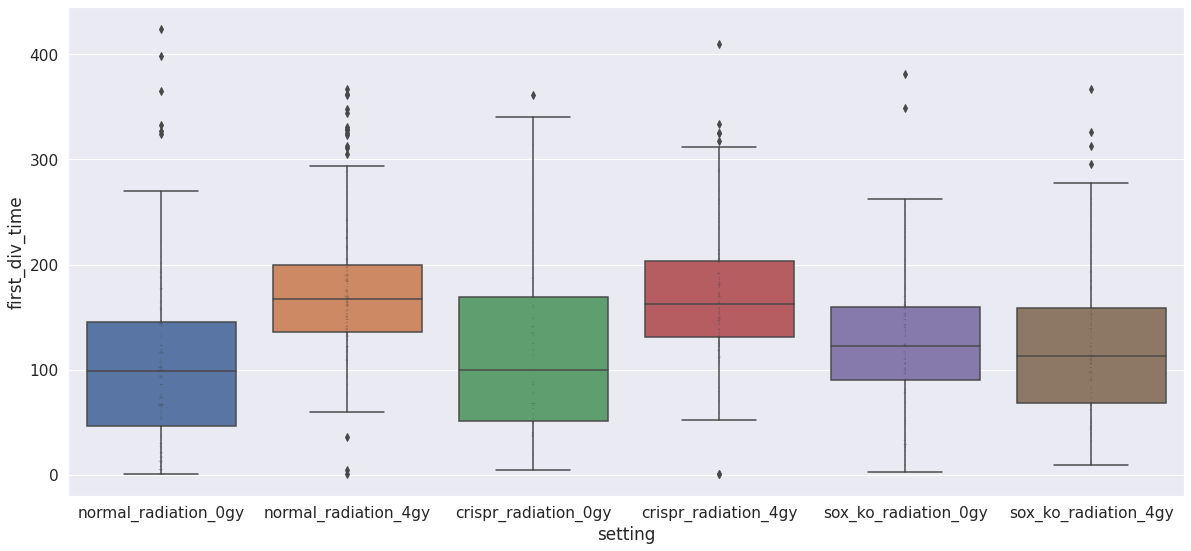

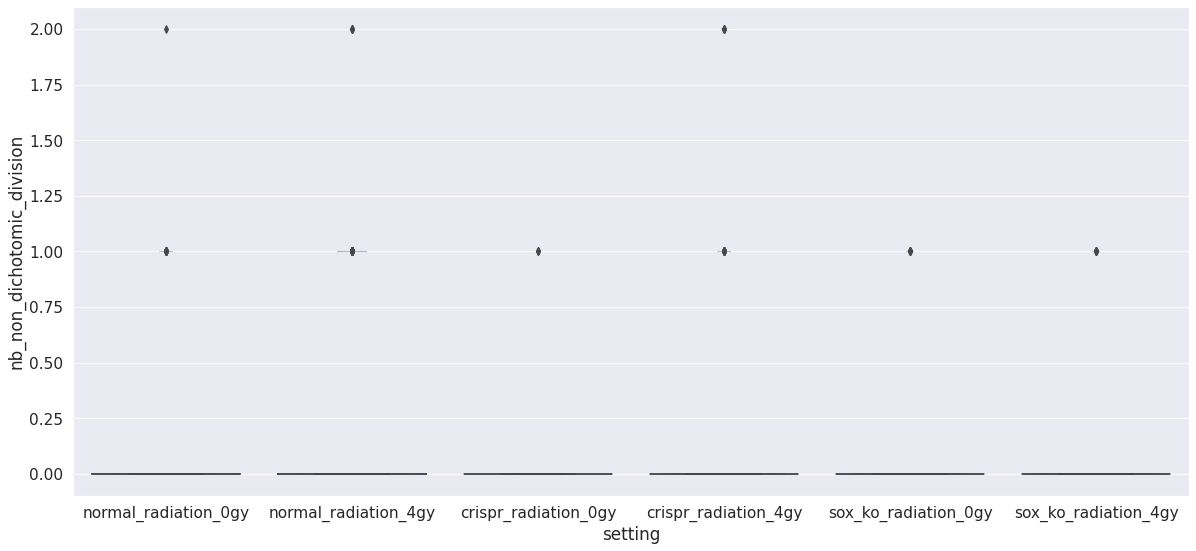

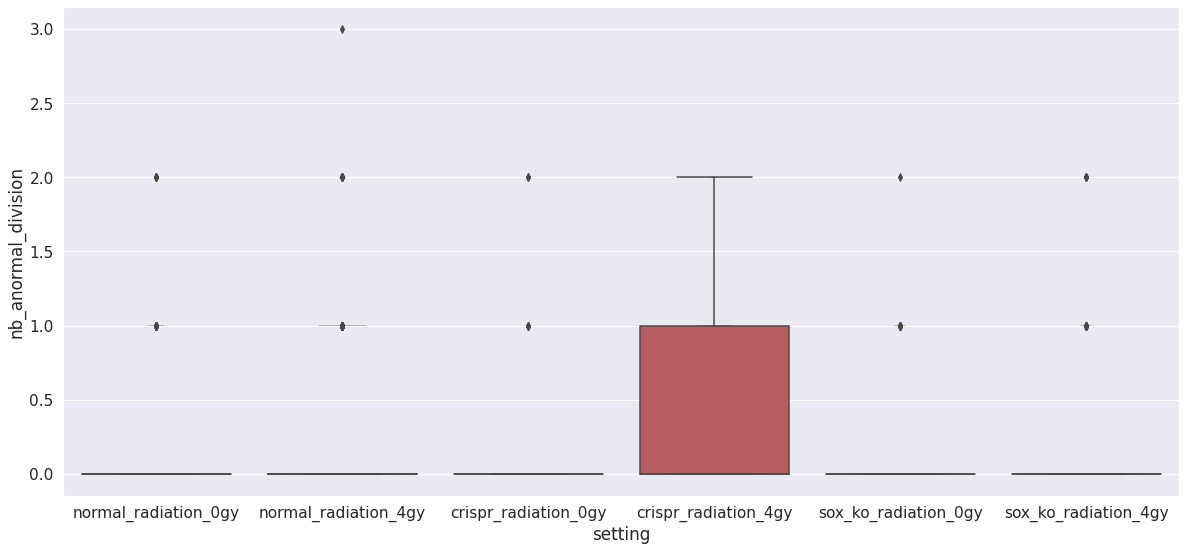

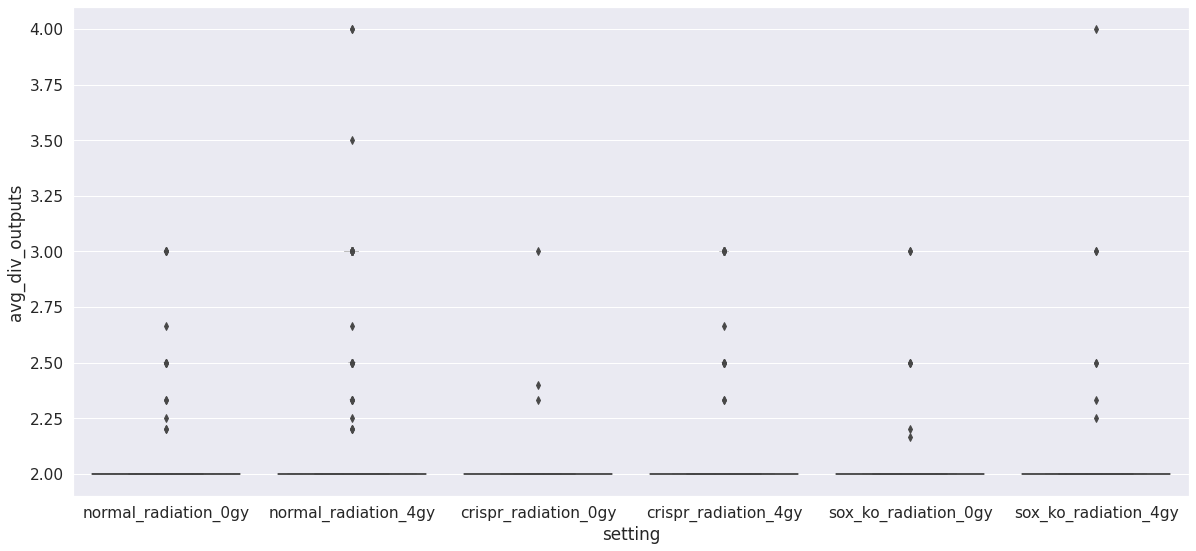

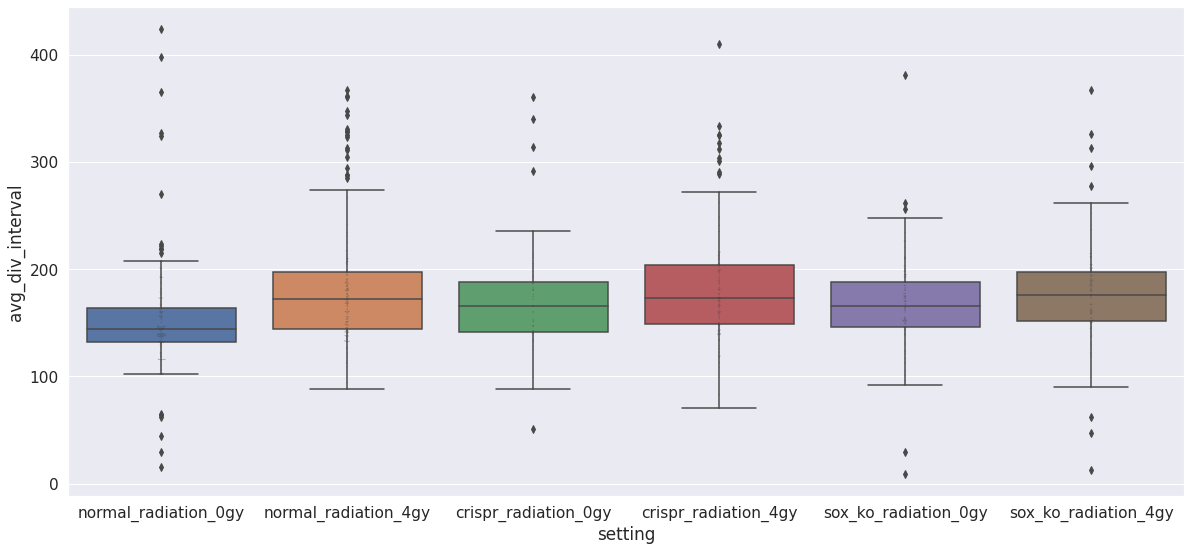

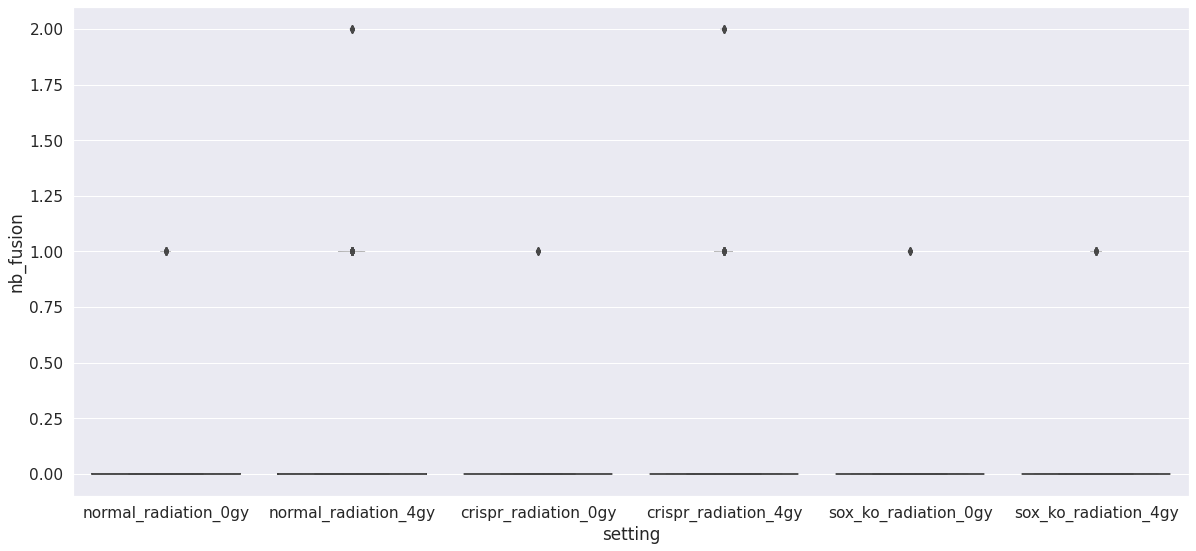

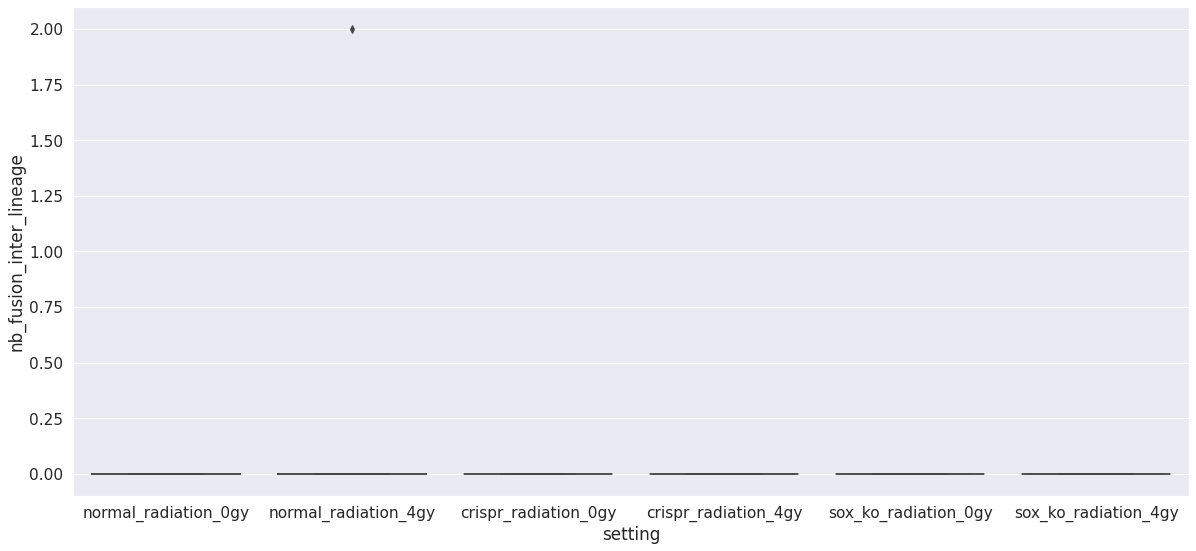

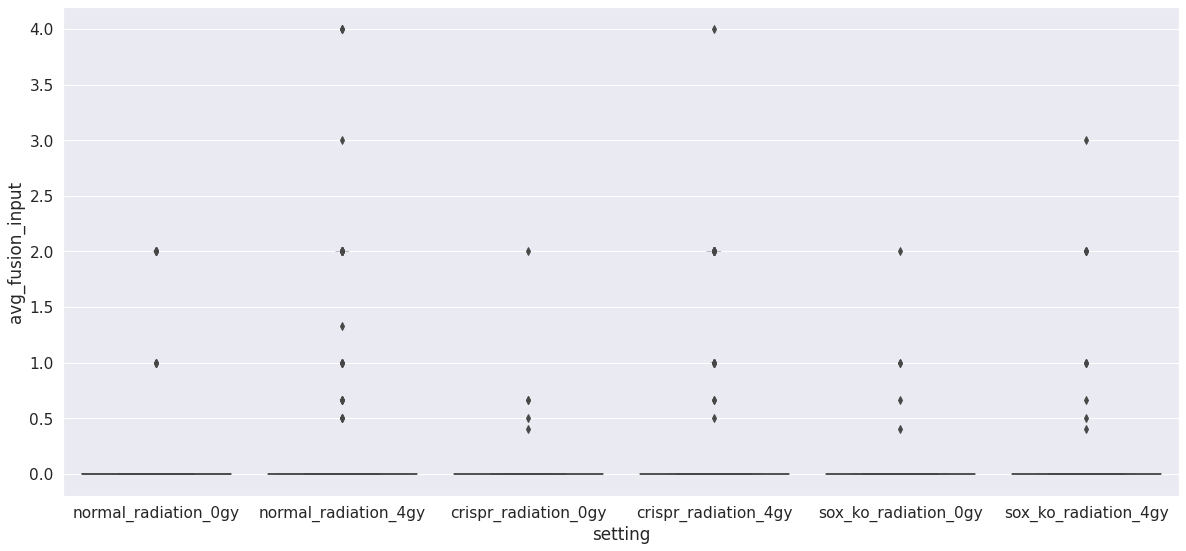

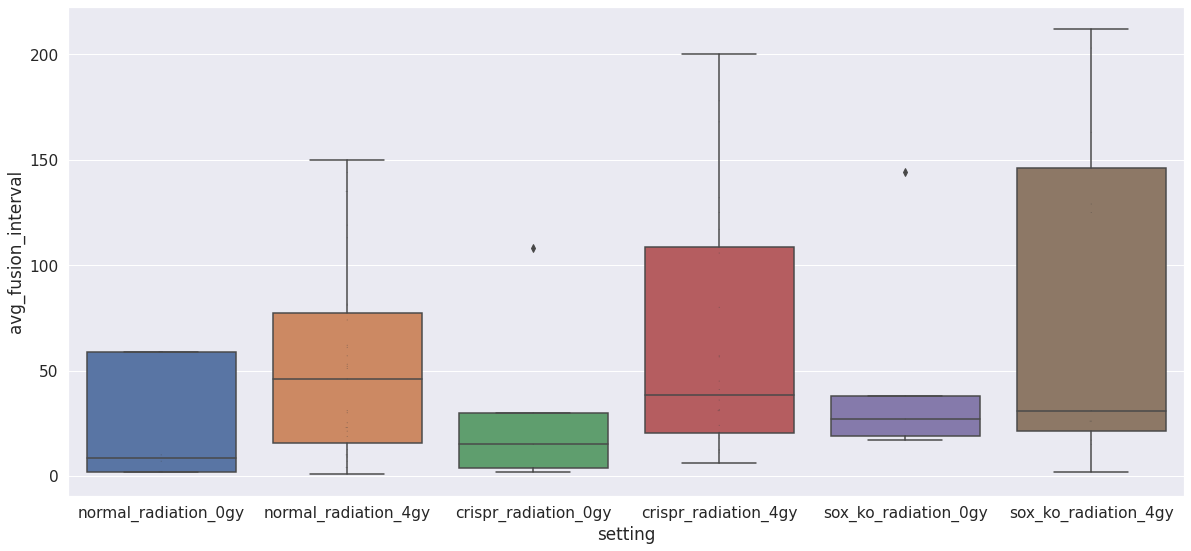

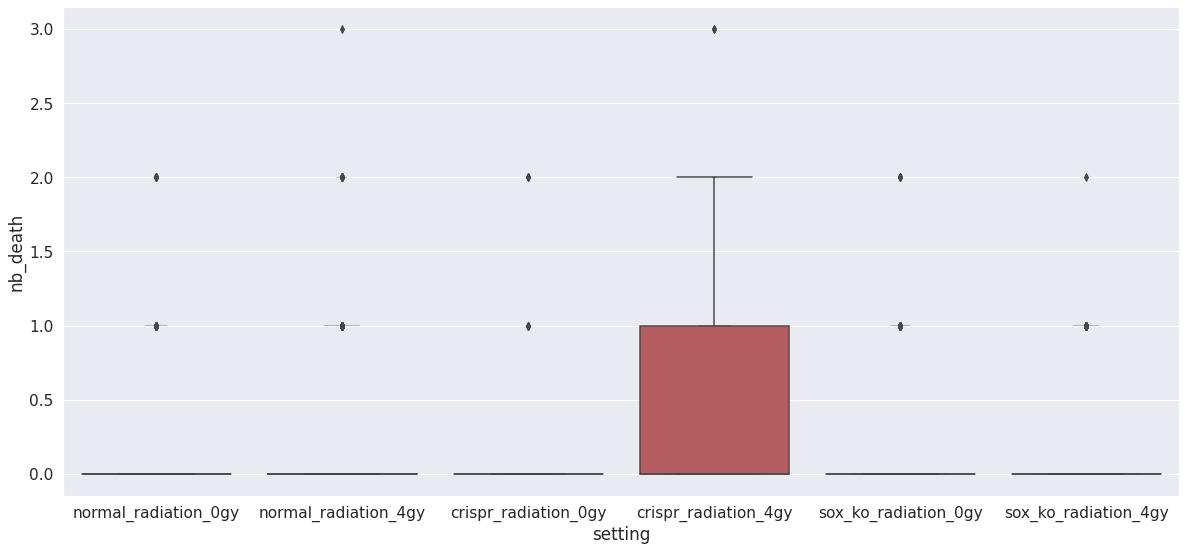

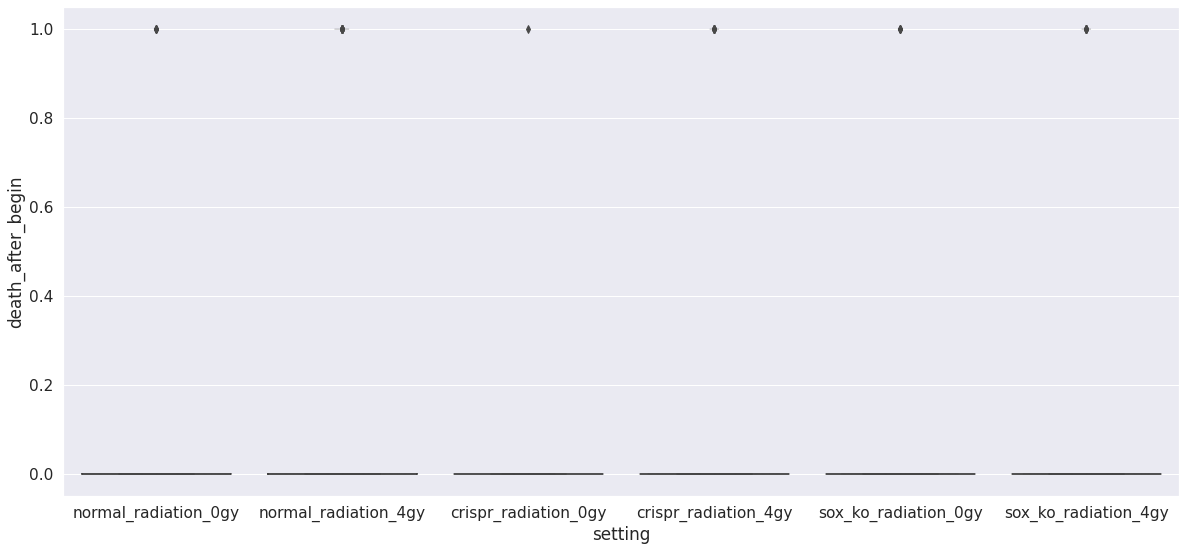

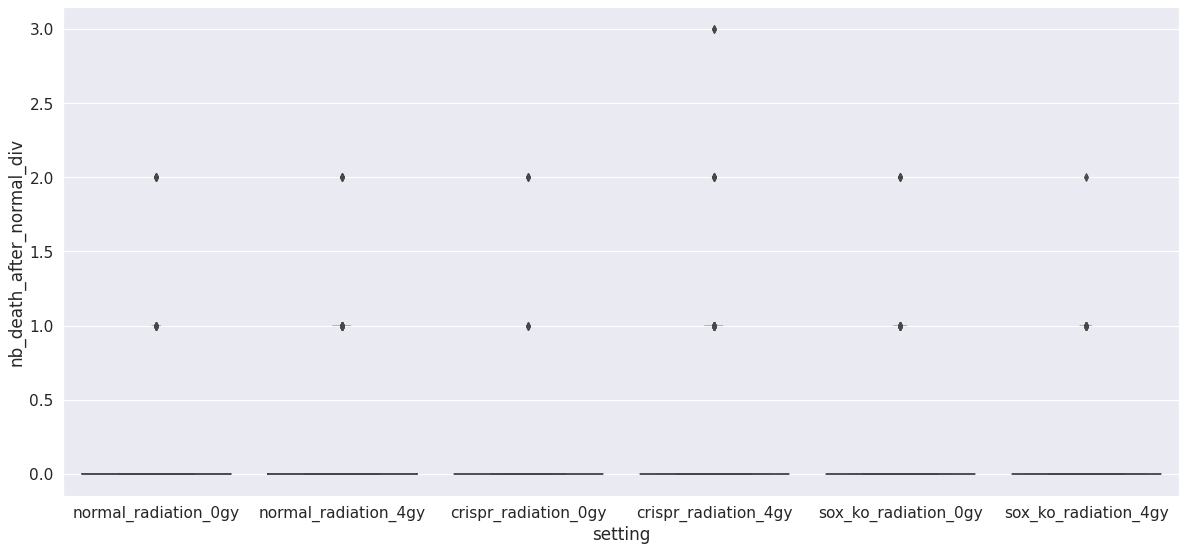

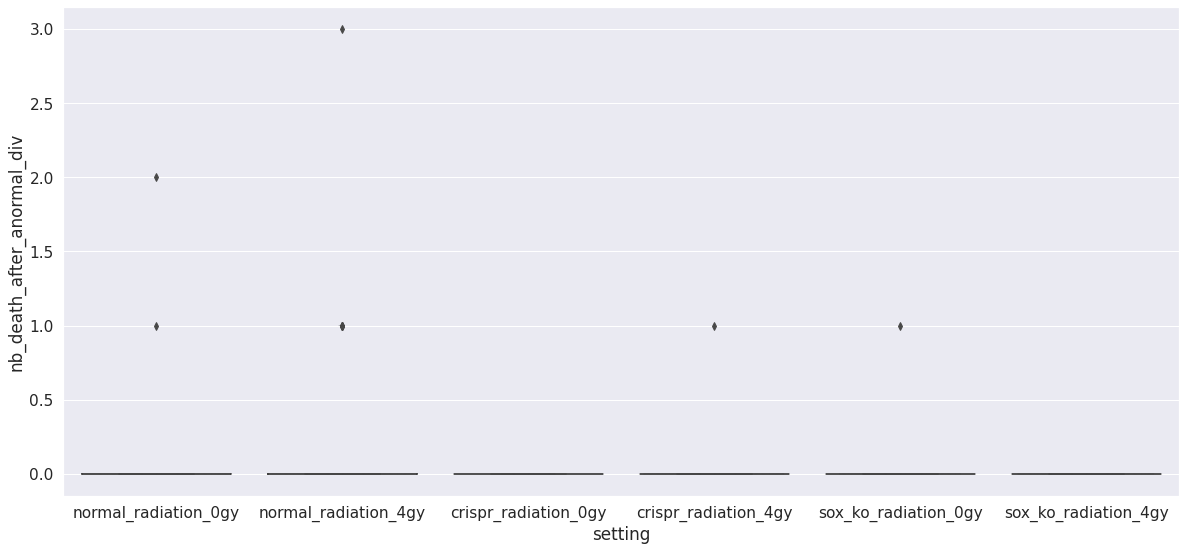

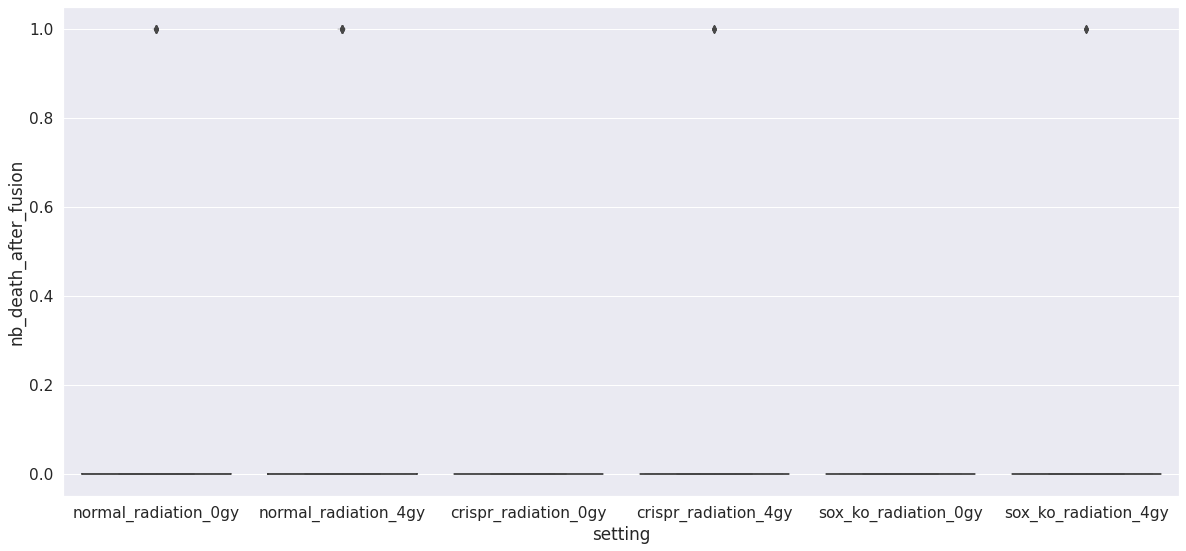

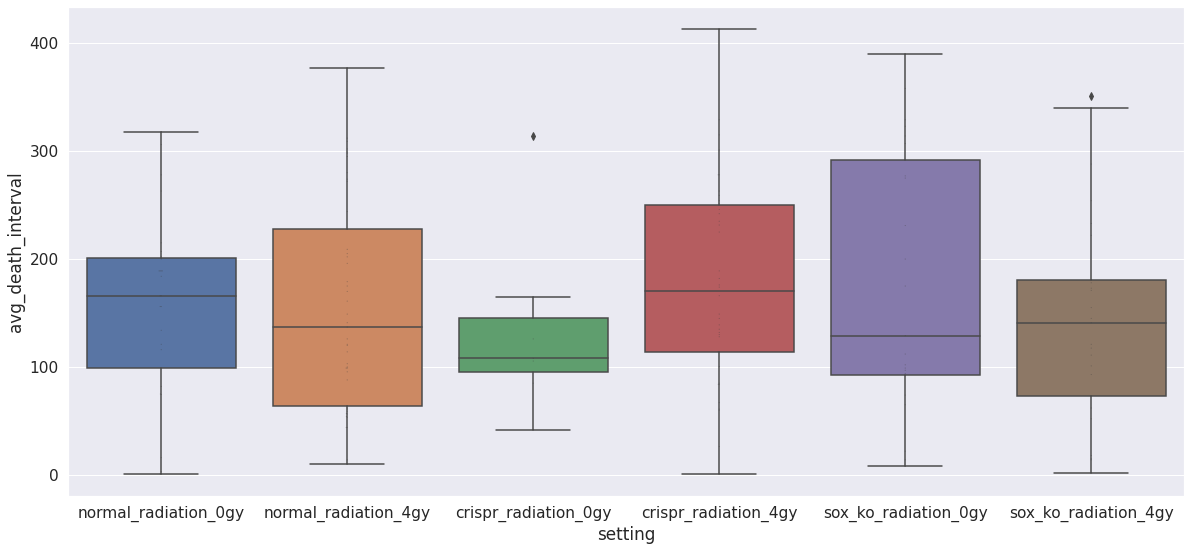

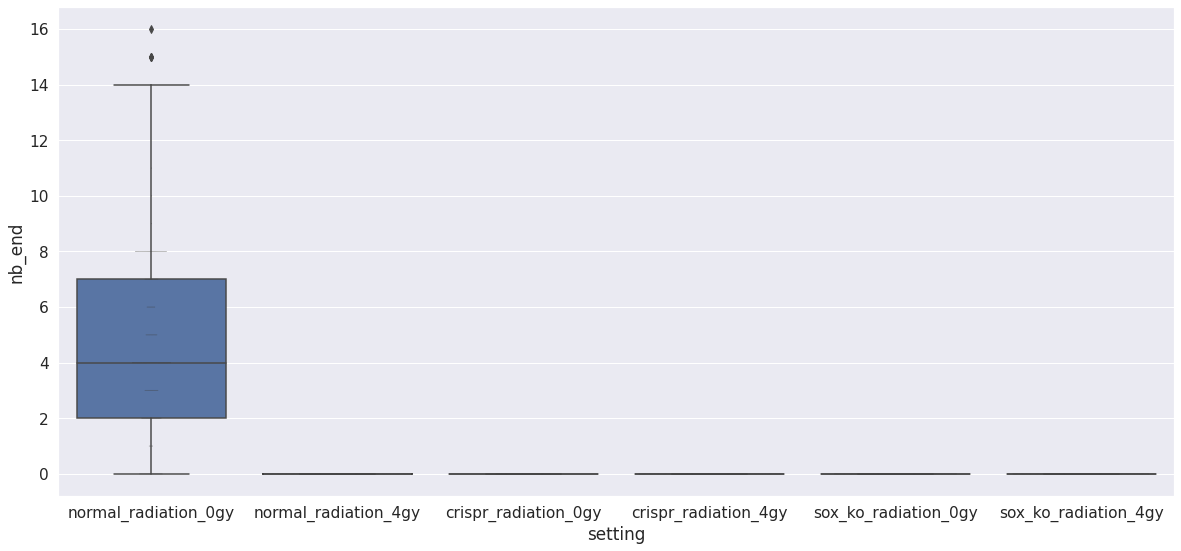

In [22]:
df_cat_plot = df_copy.copy()
setting_columns = ["normal_radiation_0gy", "normal_radiation_4gy", "crispr_radiation_0gy", "crispr_radiation_4gy", "sox_ko_radiation_0gy", "sox_ko_radiation_4gy"]
df_cat_plot[setting_columns] = df_cat_plot[setting_columns].apply(lambda s: [s.name if s.name in setting_columns and v == True else "" for v in s])
df_cat_plot["setting"] = df_cat_plot["normal_radiation_0gy"] + df_cat_plot["crispr_radiation_0gy"] + df_cat_plot["sox_ko_radiation_0gy"] + df_cat_plot["normal_radiation_4gy"] + df_cat_plot["crispr_radiation_4gy"] + df_cat_plot["sox_ko_radiation_4gy"]
df_cat_plot

for col in corr_features:
    if (df_cat_plot[col].dtype == np.float64 or df_cat_plot[col].dtype == np.int64):
        print("Ploting "+col)
        f, ax = plt.subplots(figsize=(20, 9))
        ax = sns.boxplot(x="setting", y=col, data=df_cat_plot, order=setting_columns)
        ax = sns.swarmplot(x="setting", y=col, data=df_cat_plot, order=setting_columns, color=".25", alpha=0.5, size=1.0)
        plt.savefig("crispr_distributions/[normal_crispr_sox]_distribution_"+col+".svg")

In [23]:
#!ls crispr_distributions
!zip "crispr_distributions.zip" crispr_distributions/*.svg
display(FileLink("crispr_distributions.zip"))

  adding: crispr_distributions/[normal_crispr_sox]_distribution_avg_death_interval.svg (deflated 87%)
  adding: crispr_distributions/[normal_crispr_sox]_distribution_avg_div_interval.svg (deflated 91%)
  adding: crispr_distributions/[normal_crispr_sox]_distribution_avg_div_outputs.svg (deflated 93%)
  adding: crispr_distributions/[normal_crispr_sox]_distribution_avg_fusion_input.svg (deflated 93%)
  adding: crispr_distributions/[normal_crispr_sox]_distribution_avg_fusion_interval.svg (deflated 85%)
  adding: crispr_distributions/[normal_crispr_sox]_distribution_death_after_begin.svg (deflated 93%)
  adding: crispr_distributions/[normal_crispr_sox]_distribution_first_div_time.svg (deflated 92%)
  adding: crispr_distributions/[normal_crispr_sox]_distribution_nb_anormal_division.svg (deflated 93%)
  adding: crispr_distributions/[normal_crispr_sox]_distribution_nb_death_after_anormal_div.svg (deflated 93%)
  adding: crispr_distributions/[normal_crispr_sox]_distribution_nb_death_after_fusio

/home/keijuro/Bureau/epicea/crispr_distributions.zip

# Correlation of sox experiment only

In [24]:
df_copy = df[df["version"] == "default"].copy()
df_copy = df_copy[df_copy["experiment_setting"].str.contains("sox")]
cols = []

for i in sorted(df_copy["radiation_level"].unique()):
    col_name = "radiation_"+str(i)+"gy"
    cols.append(col_name)
    df_copy[col_name] = (df["radiation_level"] == i)
    
    col_name = "crispr_radiation_"+str(i)+"gy"
    cols.append(col_name)
    df_copy[col_name] = (df["experiment_setting"].str.contains("ct")) & (df["radiation_level"] == i)
    
    col_name = "sox_ko_radiation_"+str(i)+"gy"
    cols.append(col_name)
    df_copy[col_name] = (df["experiment_setting"].str.contains("ko")) & (df["radiation_level"] == i)
    
cols.extend([i for i in df_copy.columns.tolist() if i not in ["radiation_level","cell_line_id", "experiment_setting"]+cols])
df_copy = df_copy[["cell_line_id", "experiment_setting", "radiation_level"]+cols]
df_copy.head()

cell_line_id experiment_setting  radiation_level  \
432  20210305u251.nd2crisprsox24GYp1_C1          sox,n1,ko                4   
433  20210305u251.nd2crisprsox24GYp1_C2          sox,n1,ko                4   
434  20210305u251.nd2crisprsox24GYp1_C3          sox,n1,ko                4   
435  20210305u251.nd2crisprsox24GYp1_C4          sox,n1,ko                4   
436  20210305u251.nd2crisprsox24GYp1_C5          sox,n1,ko                4   

     radiation_0gy  crispr_radiation_0gy  sox_ko_radiation_0gy  radiation_4gy  \
432          False                 False                 False           True   
433          False                 False                 False           True   
434          False                 False                 False           True   
435          False                 False                 False           True   
436          False                 False                 False           True   

     crispr_radiation_4gy  sox_ko_radiation_4gy  lineage_death  ...  \
432                 False                  True          False  ...   
433                 False                  True          False  ...   
434                 False                  True           True  ...   
435                 False                  True          False  ...   
436                 False                  True           True  ...   

     nb_death_in_time_window_2  nb_death_in_time_window_3  \
432                          0                          0   
433                          0                          0   
434                          0                          0   
435                          0                          0   
436                          0                          0   

     nb_death_in_time_window_4  lineage_dead_at_time_window_0  \
432                          0                          False   
433                          0                          False   
434                          0                           True   
435                          0                          False   
436                          0                           True   

     lineage_dead_at_time_window_1  lineage_dead_at_time_window_2  \
432                          False                          False   
433                          False                          False   
434                           True                           True   
435                          False                          False   
436                           True                           True   

     lineage_dead_at_time_window_3  lineage_dead_at_time_window_4  sox_ko  \
432                          False                          False    True   
433                          False                          False    True   
434                           True                           True    True   
435                          False                          False    True   
436                           True                           True    True   

     version  
432  default  
433  default  
434  default  
435  default  
436  default  

[5 rows x 61 columns]

Heatmap of the correlation matrix of cell lineage properties for average of ['n1', 'n2']


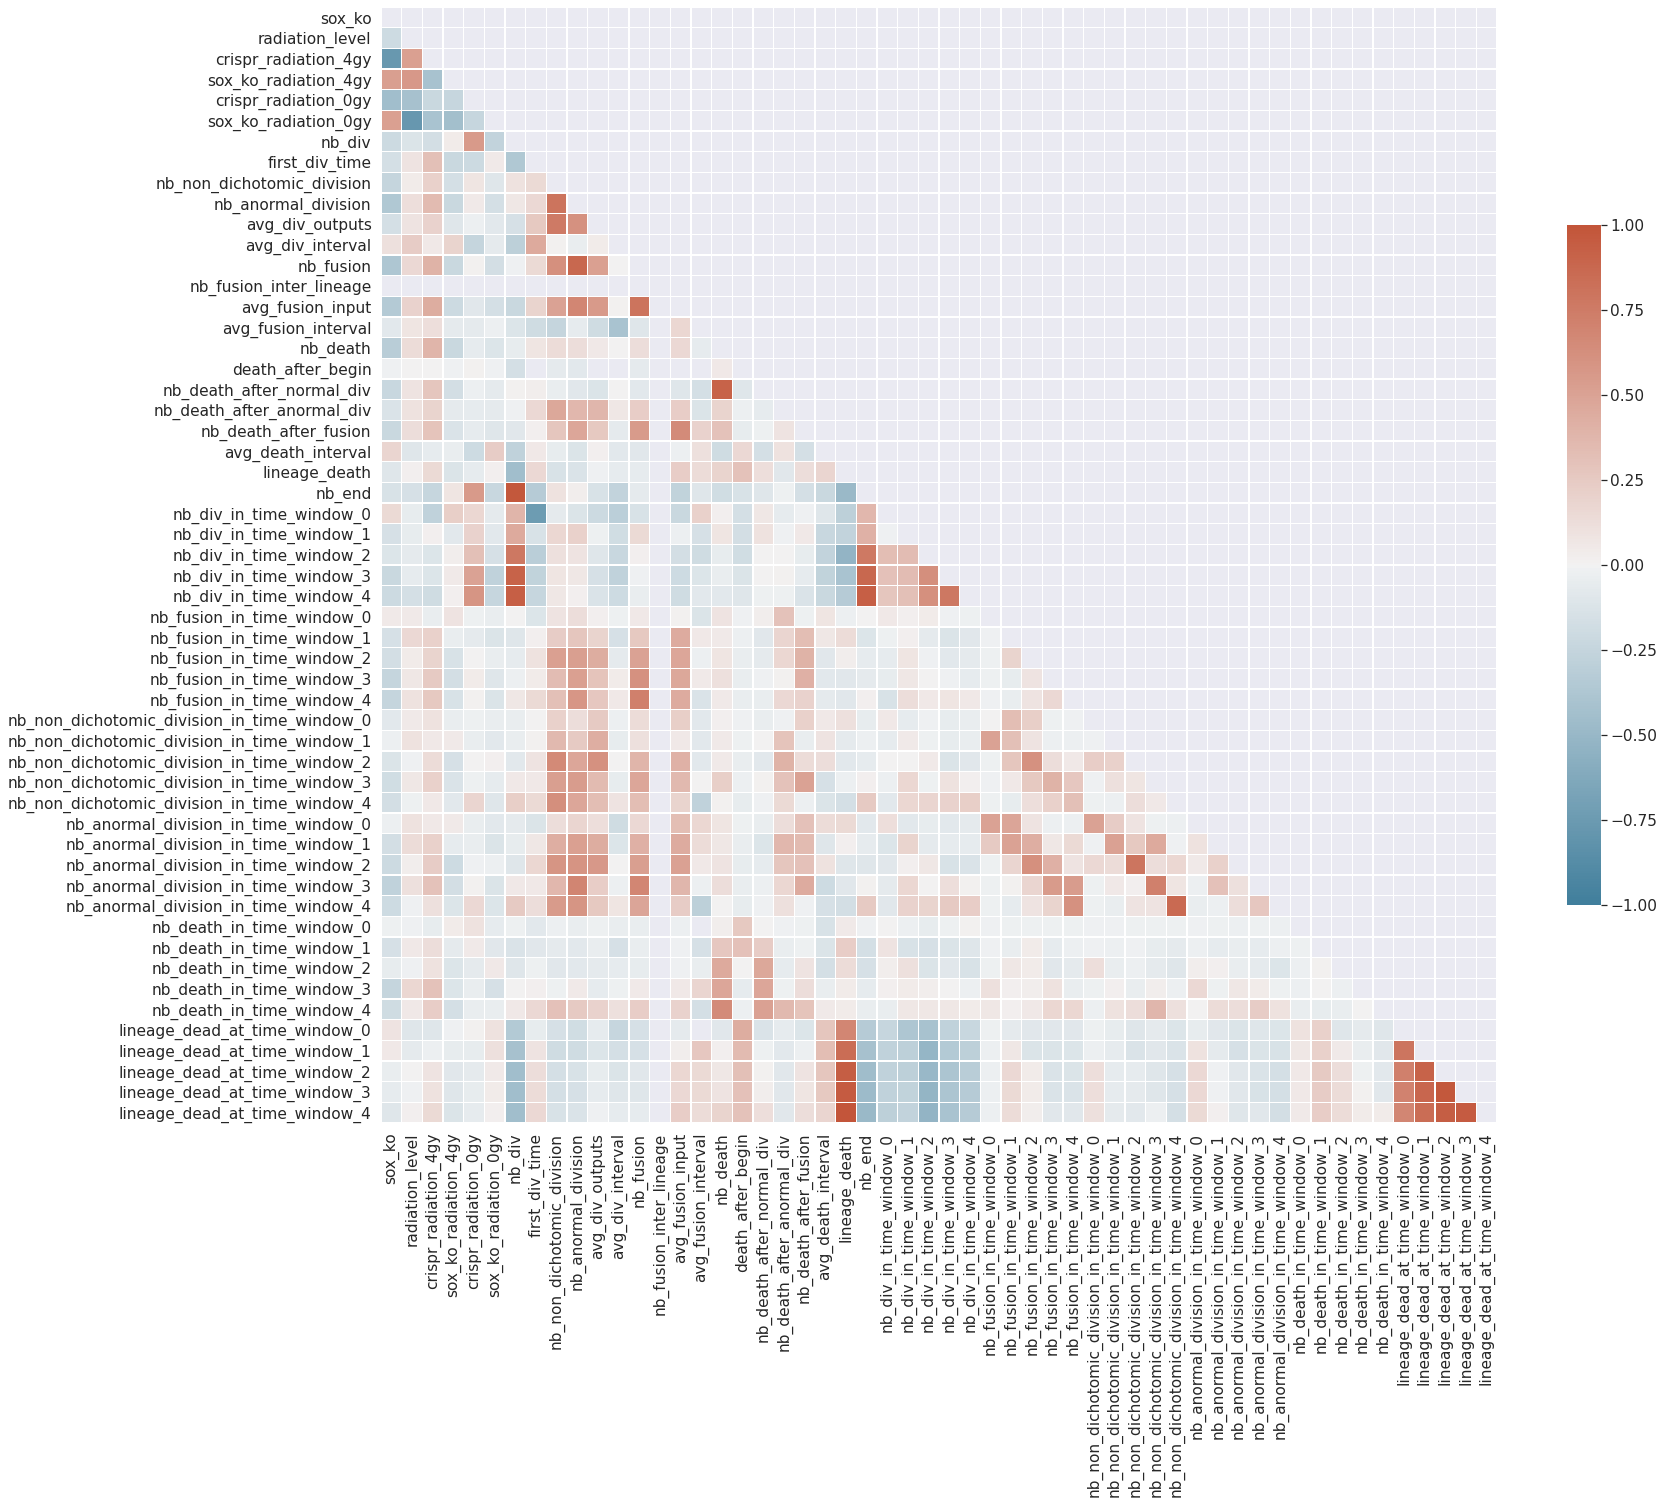

Heatmap of the correlation matrix of cell lineage properties for average of ['n1', 'n2']


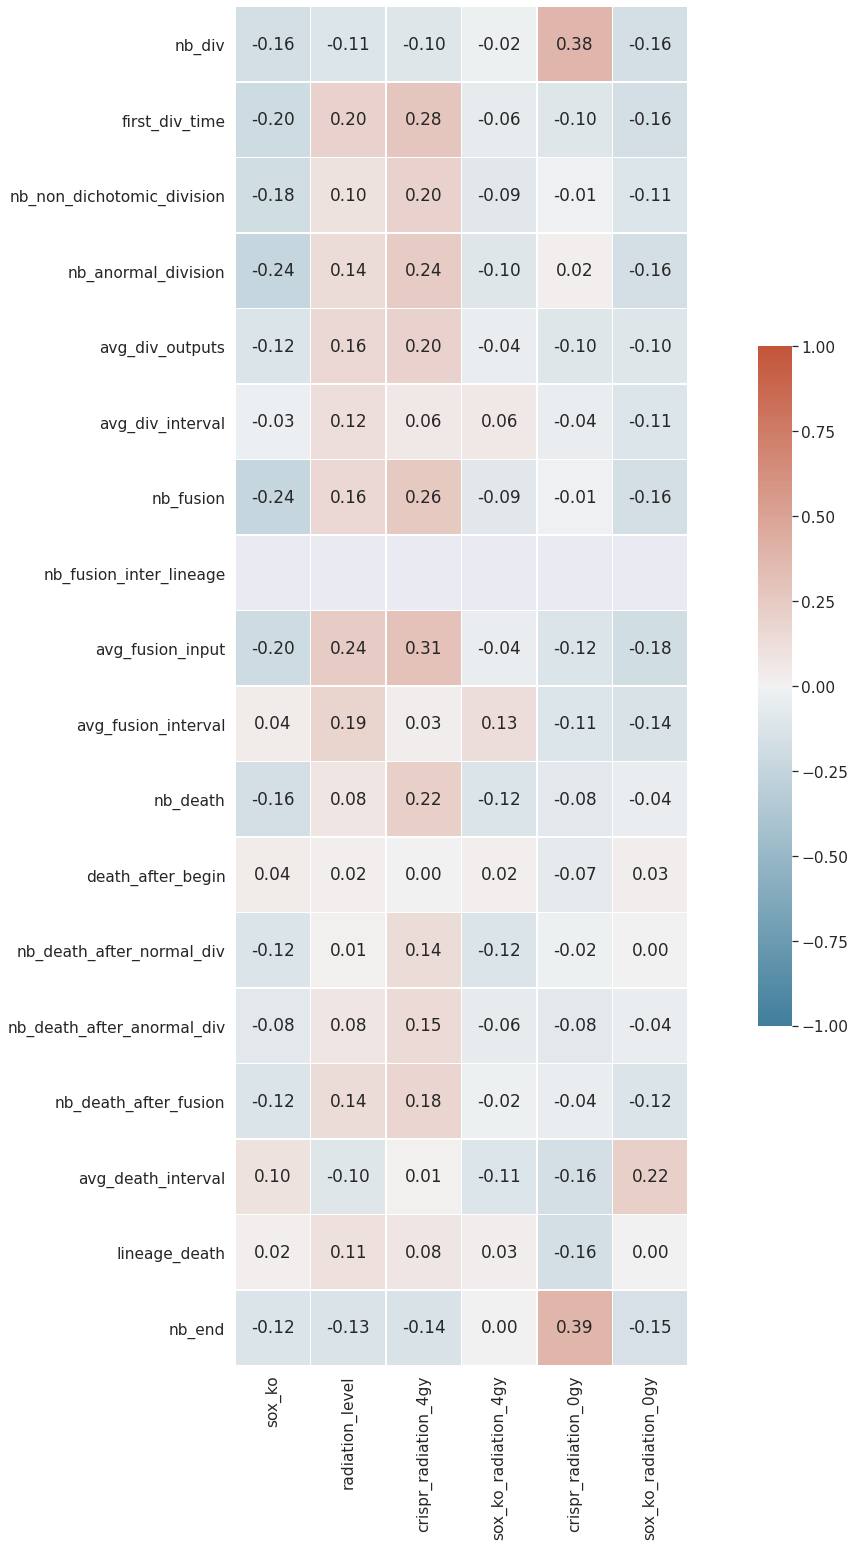

Heatmap of the correlation matrix of cell lineage properties for average of ['n1', 'n2']


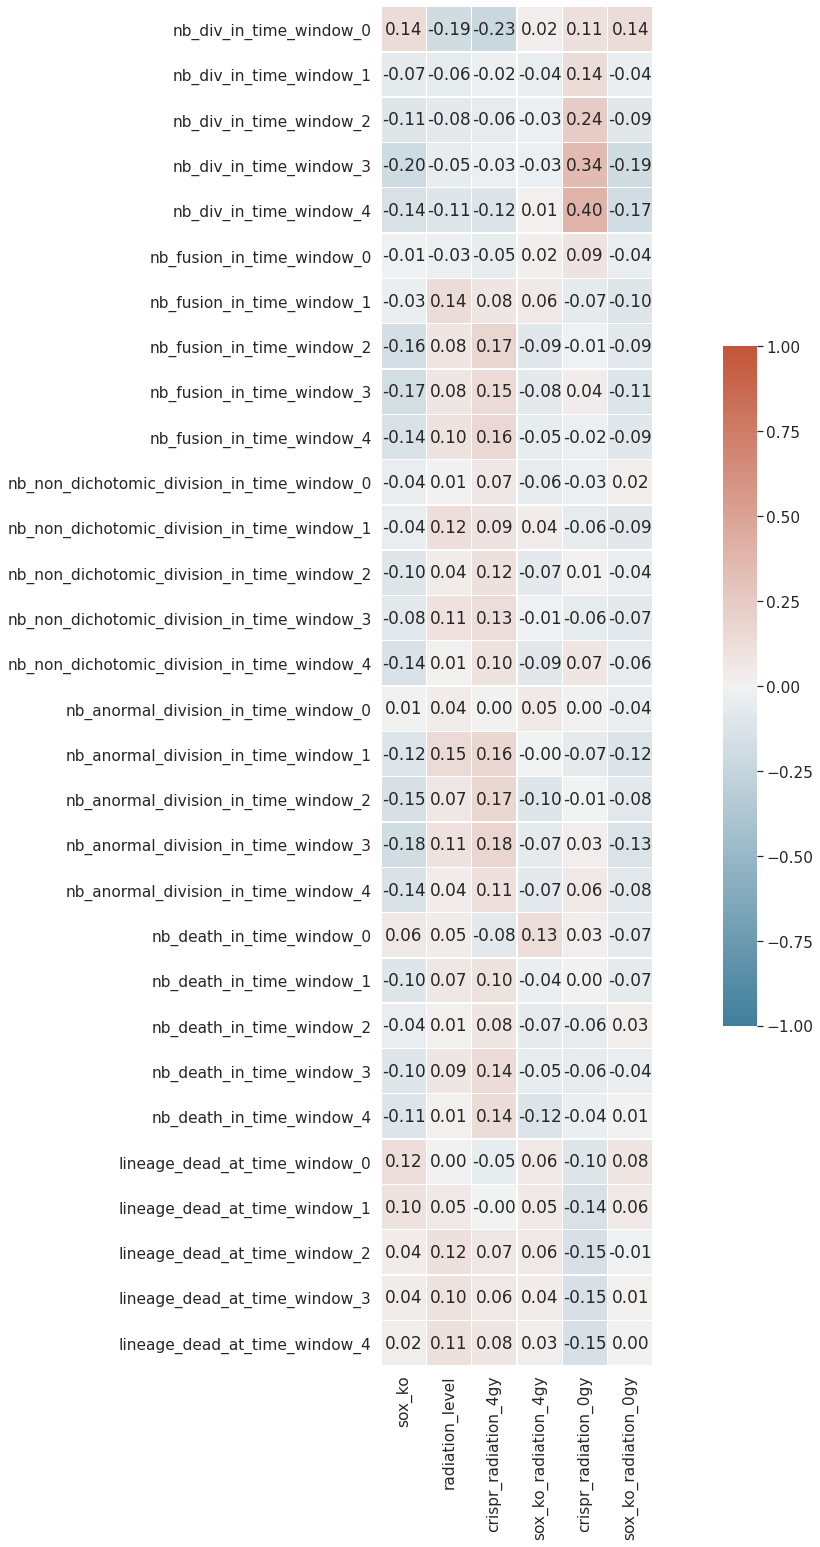

Heatmap of the correlation matrix of cell lineage properties for average of ['n1', 'n2']


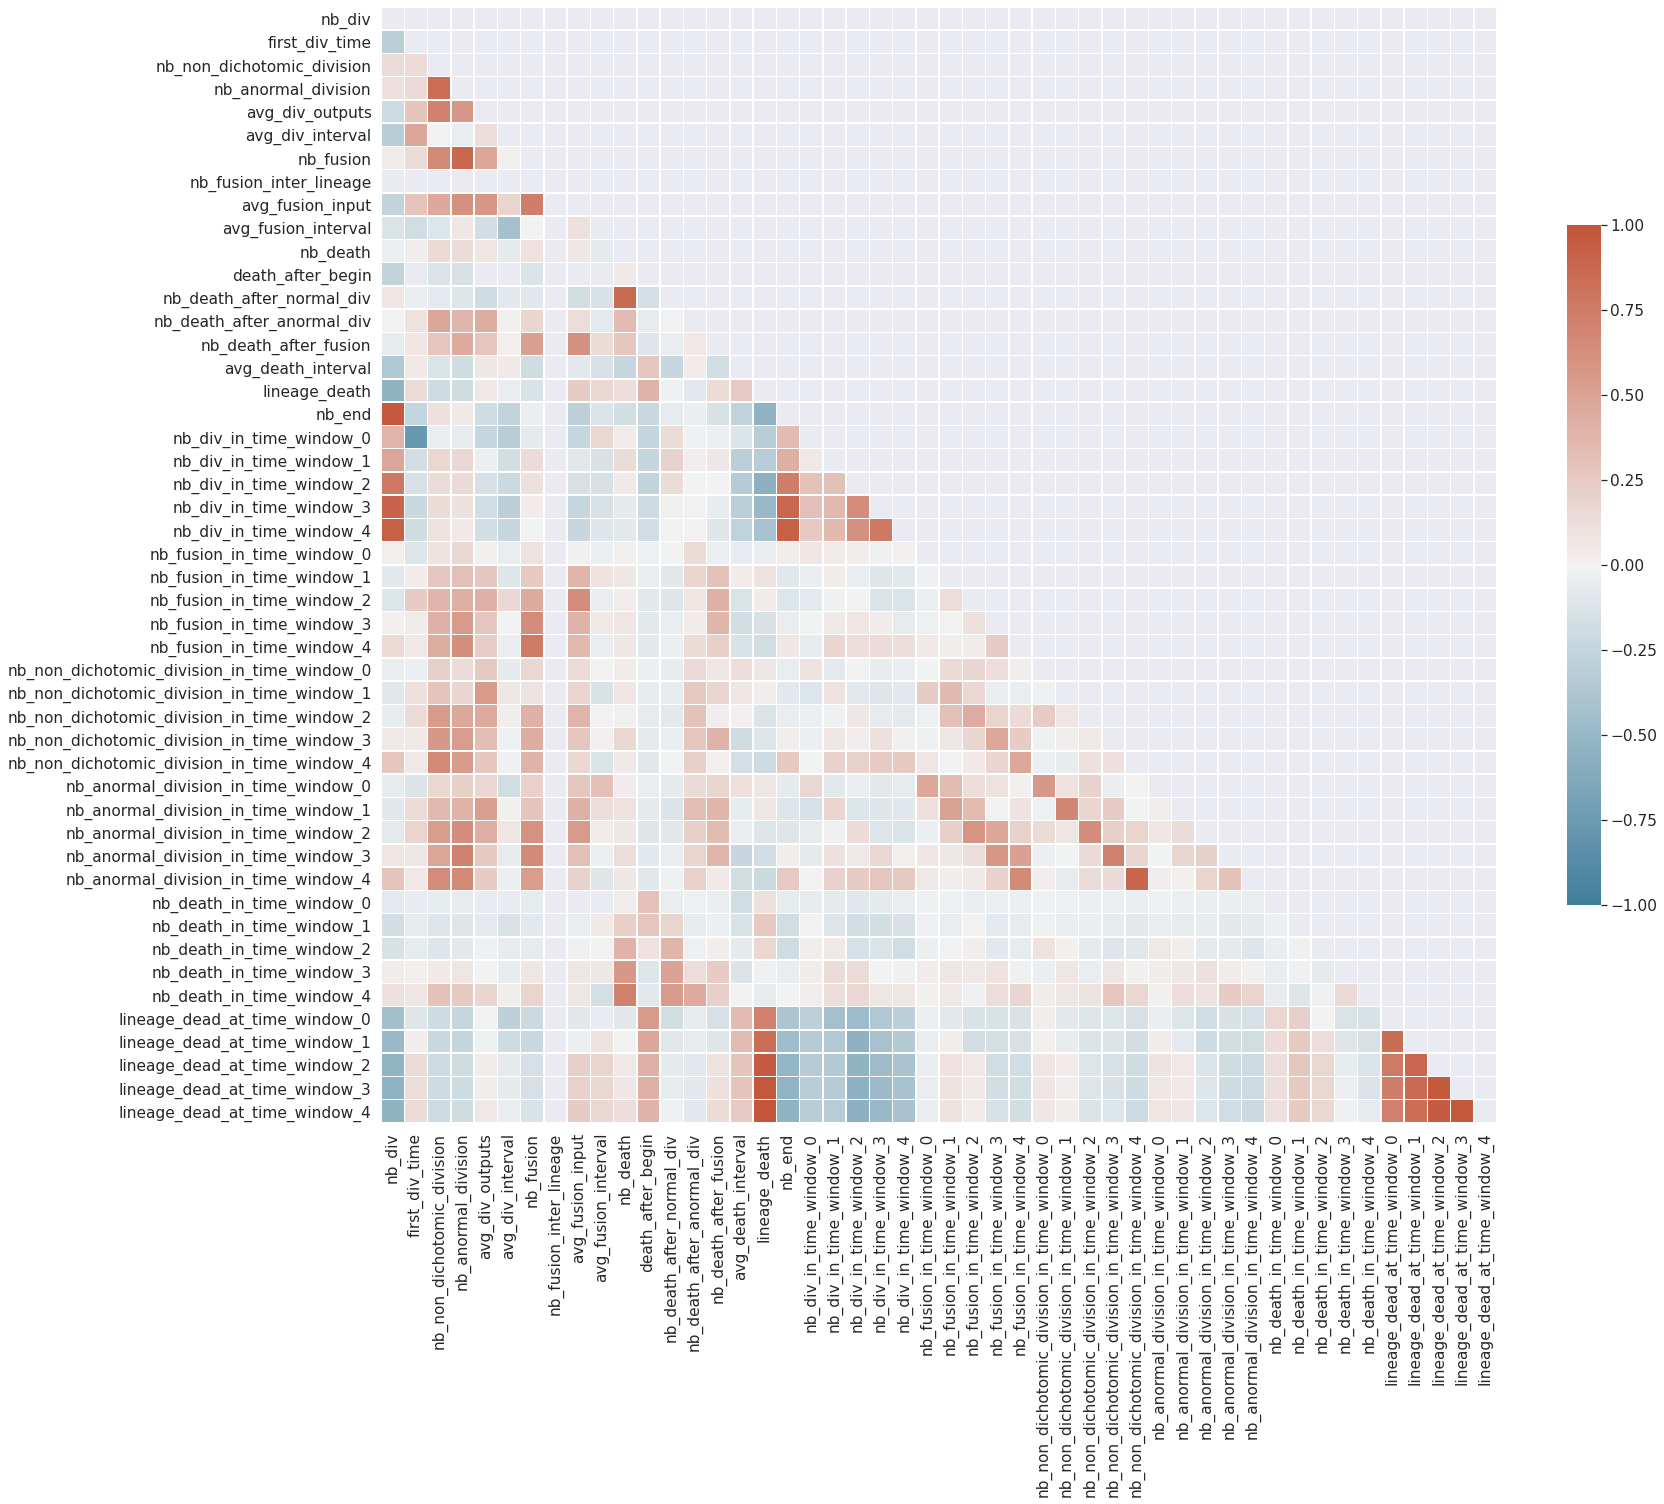

Heatmap of the correlation matrix of cell lineage properties for difference min/max of sox for ['n1', 'n2']


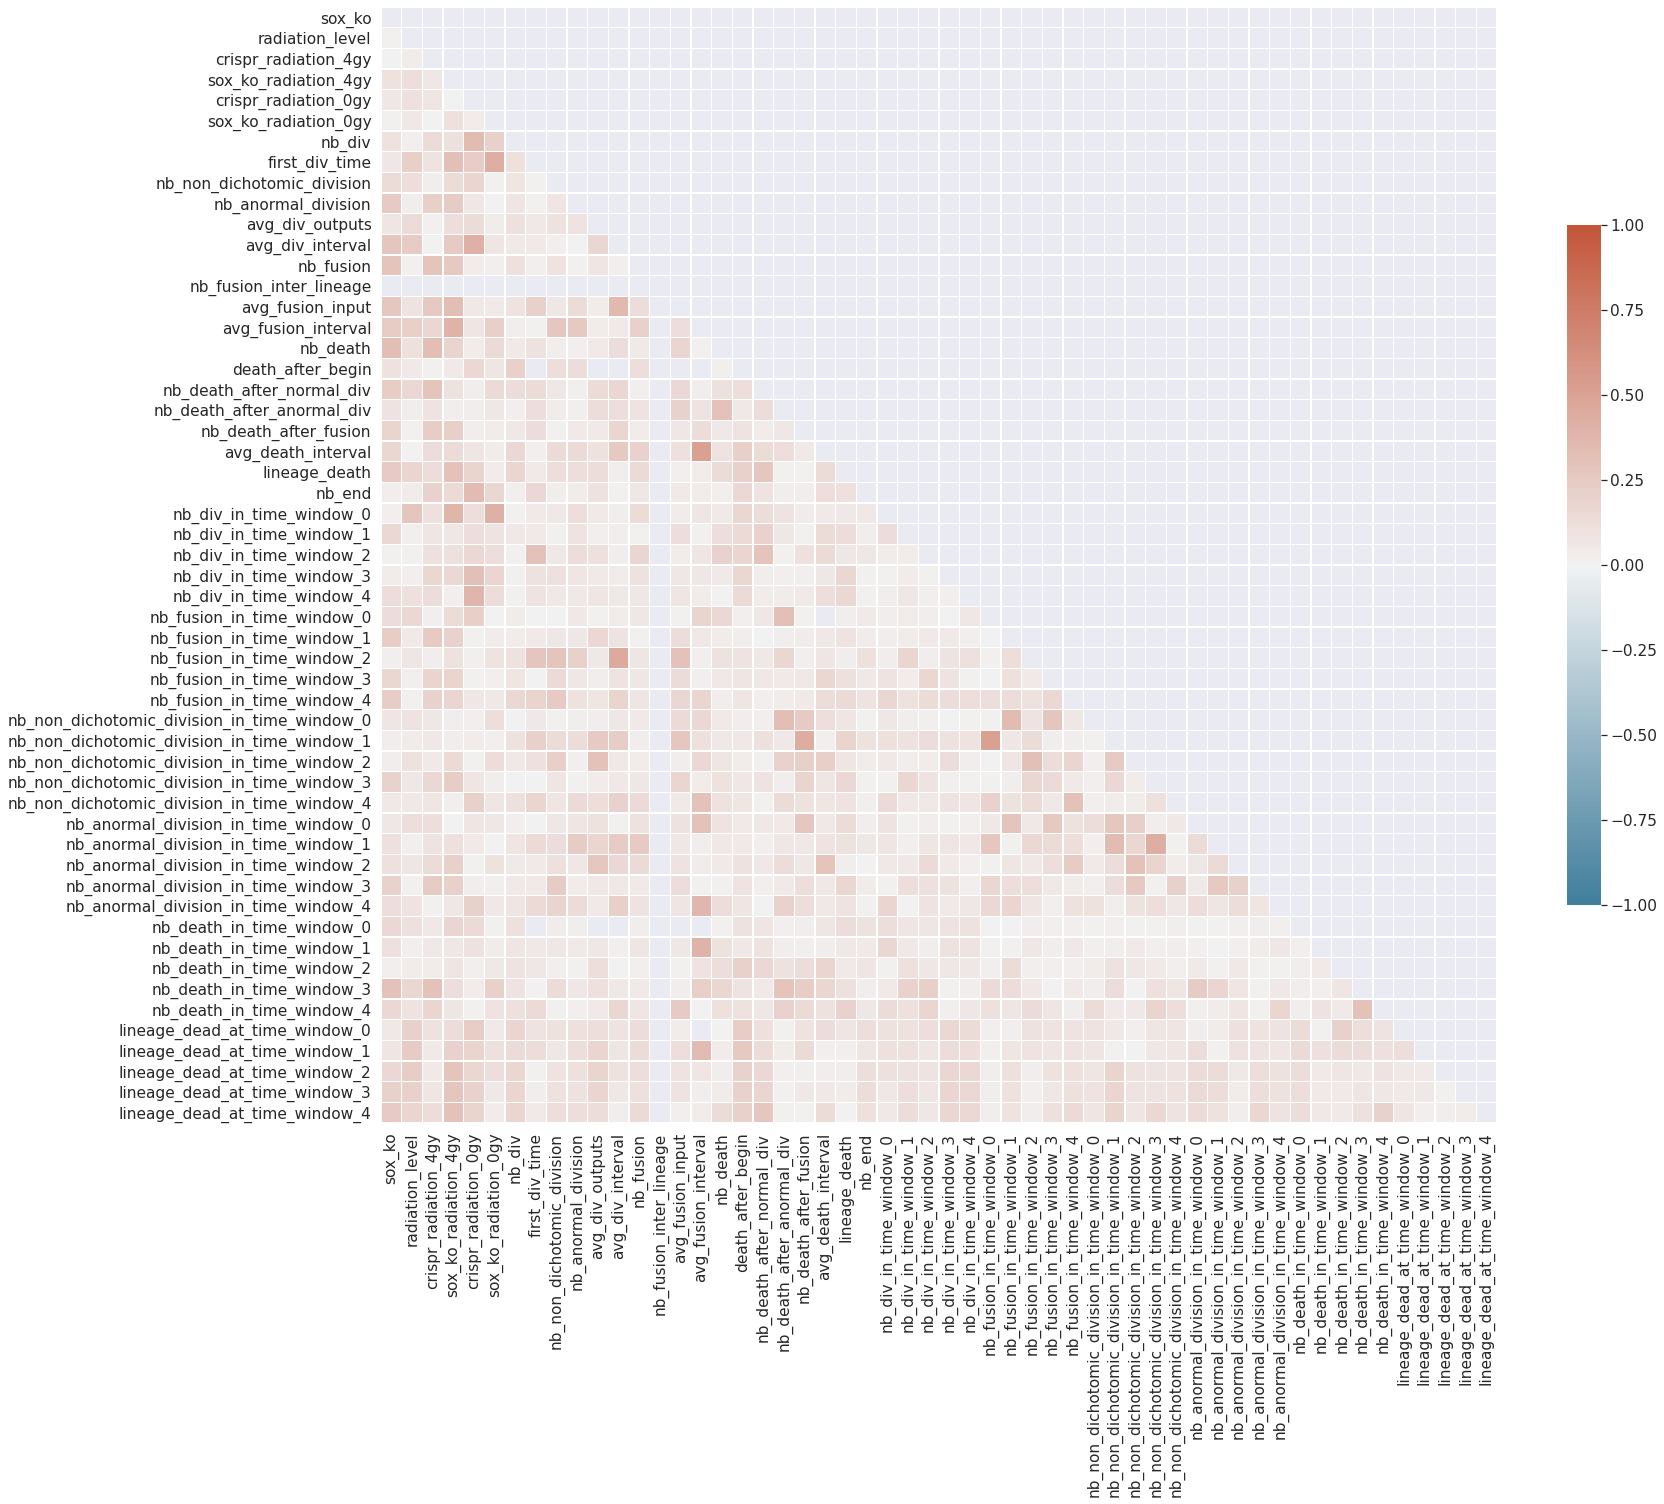

In [25]:
radiation_features = ["sox_ko"] + \
                    ["radiation_level"] + \
                    [exp_type+"_radiation_"+str(i)+"gy" for i in df_copy["radiation_level"].unique() for exp_type in ["crispr", "sox_ko"]]
corr_features = [
    # Div 
    "nb_div",
    "first_div_time",
    "nb_non_dichotomic_division",
    "nb_anormal_division",
    
    "avg_div_outputs", 
    "avg_div_interval",
    
    # Fusion
    "nb_fusion",
    "nb_fusion_inter_lineage",
    
    "avg_fusion_input",
    "avg_fusion_interval",
    
    # Death
    "nb_death",
    "death_after_begin",
    "nb_death_after_normal_div",
    "nb_death_after_anormal_div",
    "nb_death_after_fusion",
    
    "avg_death_interval",
    
    #"nb_simultaneous_event",
    #"sum_input_age",
     
    #"nb_div_in_time_window_0",
    #"nb_div_in_time_window_1",
    #"nb_div_in_time_window_2",
    #"nb_div_in_time_window_3",
    #"nb_div_in_time_window_4",
    
    #"nb_fusion_in_time_window_0",
    #"nb_fusion_in_time_window_1",
    #"nb_fusion_in_time_window_2",
    #"nb_fusion_in_time_window_3",
    #"nb_fusion_in_time_window_4",
    
    #"nb_non_dichotomic_division_in_time_window_0",
    #"nb_non_dichotomic_division_in_time_window_1",
    #"nb_non_dichotomic_division_in_time_window_2",
    #"nb_non_dichotomic_division_in_time_window_3",
    #"nb_non_dichotomic_division_in_time_window_4",
    
    #"nb_anormal_division_in_time_window_0",
    #"nb_anormal_division_in_time_window_1",
    #"nb_anormal_division_in_time_window_2",
    #"nb_anormal_division_in_time_window_3",
    #"nb_anormal_division_in_time_window_4",
    
    #"nb_death_in_time_window_0",
    #"nb_death_in_time_window_1",
    #"nb_death_in_time_window_2",
    #"nb_death_in_time_window_3",
    #"nb_death_in_time_window_4",
    
    "lineage_death",
    
    #"lineage_dead_at_time_window_0", 
    #"lineage_dead_at_time_window_1", 
    #"lineage_dead_at_time_window_2", 
    #"lineage_dead_at_time_window_3", 
    #"lineage_dead_at_time_window_4",
    
    "nb_end",
]

corr_features_time = [
    "nb_div_in_time_window_0",
    "nb_div_in_time_window_1",
    "nb_div_in_time_window_2",
    "nb_div_in_time_window_3",
    "nb_div_in_time_window_4",
    
    "nb_fusion_in_time_window_0",
    "nb_fusion_in_time_window_1",
    "nb_fusion_in_time_window_2",
    "nb_fusion_in_time_window_3",
    "nb_fusion_in_time_window_4",
    
    "nb_non_dichotomic_division_in_time_window_0",
    "nb_non_dichotomic_division_in_time_window_1",
    "nb_non_dichotomic_division_in_time_window_2",
    "nb_non_dichotomic_division_in_time_window_3",
    "nb_non_dichotomic_division_in_time_window_4",
    
    "nb_anormal_division_in_time_window_0",
    "nb_anormal_division_in_time_window_1",
    "nb_anormal_division_in_time_window_2",
    "nb_anormal_division_in_time_window_3",
    "nb_anormal_division_in_time_window_4",
    
    "nb_death_in_time_window_0",
    "nb_death_in_time_window_1",
    "nb_death_in_time_window_2",
    "nb_death_in_time_window_3",
    "nb_death_in_time_window_4",
    
    "lineage_dead_at_time_window_0", 
    "lineage_dead_at_time_window_1", 
    "lineage_dead_at_time_window_2", 
    "lineage_dead_at_time_window_3", 
    "lineage_dead_at_time_window_4",
]

selected_features = radiation_features + corr_features + corr_features_time

def plot_heatmap(corr, experiment_setting, triangle=False, annot=True):
    # Generate a mask for the upper triangle
    mask = None
    if triangle:
        mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(25, 25))
    
    print("Heatmap of the correlation matrix of cell lineage properties for "+experiment_setting)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=annot, fmt=".2f",
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
    plt.show()
    #ax.set_title("Heatmap of the correlation matrix of cell lineage properties for "+experiment_setting)

####
avg_corr = None
min_corr = None
max_corr = None
min_corr_n2_n3 = None
max_corr_n2_n3 = None

settings = ["n1","n2"]
for experiement_group in settings:
    #print(experiment_setting)
    df_ni = df_copy[(~df_copy["experiment_setting"].str.contains("sox")) | (df_copy["experiment_setting"].str.contains(experiement_group))]
    df_ni = df_ni[selected_features]
    #display(df_ni)
    corr = df_ni.corr().round(2)
    
    if avg_corr is None:
        avg_corr = corr.copy()
        min_corr = corr.copy()
        max_corr = corr.copy()
    else:
        avg_corr += corr
        min_corr = np.minimum(min_corr,corr)
        max_corr = np.maximum(max_corr,corr)

avg_corr /= len(settings)

corr_left = avg_corr[radiation_features][(avg_corr.index.isin(corr_features))].round(2)
corr_left_time = avg_corr[radiation_features][(avg_corr.index.isin(corr_features_time))]
corr_right = avg_corr[corr_features+corr_features_time][(avg_corr.index.isin(corr_features+corr_features_time))]
diff_corr = np.subtract(max_corr,min_corr)

sns.set(font_scale=1.4)

plot_heatmap(corr, "average of "+ str(settings), True, False)
plot_heatmap(corr_left, "average of "+str(settings), False, True)
plot_heatmap(corr_left_time, "average of "+str(settings), False, True)
plot_heatmap(corr_right, "average of "+str(settings), True, False)
#plot_heatmap(corr_right_time, "average of n1/n2/n3", True, False)

plot_heatmap(diff_corr, "difference min/max of sox for "+str(settings), True, False)

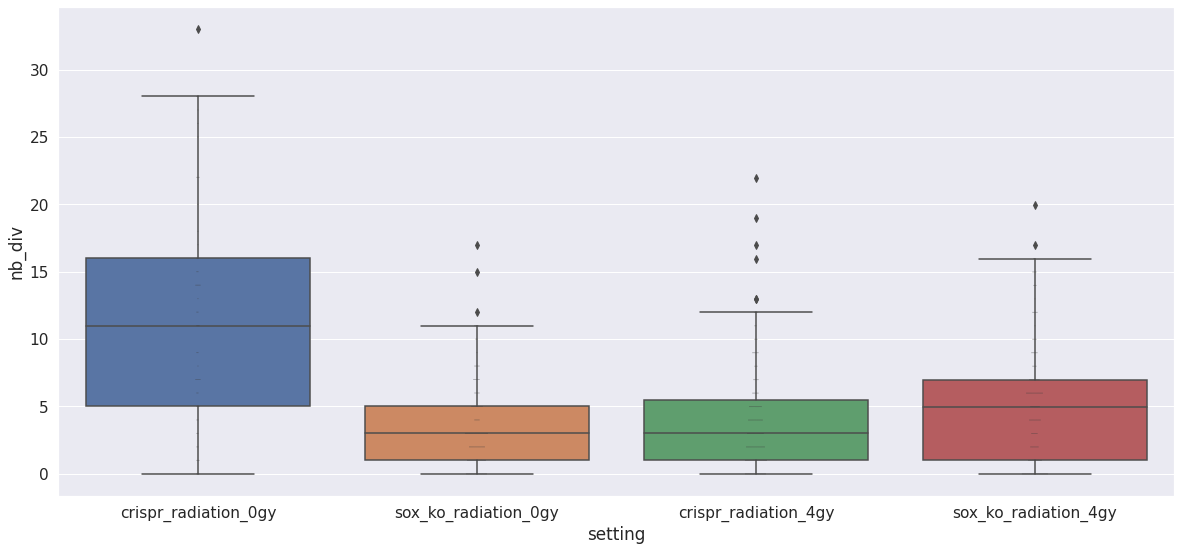

In [26]:
df_cat_plot = df_copy.copy()
setting_columns = ["crispr_radiation_0gy", "sox_ko_radiation_0gy", "crispr_radiation_4gy", "sox_ko_radiation_4gy"]
df_cat_plot[setting_columns] = df_cat_plot[setting_columns].apply(lambda s: [s.name if s.name in setting_columns and v == True else "" for v in s])
df_cat_plot["setting"] = df_cat_plot["crispr_radiation_0gy"] + df_cat_plot["sox_ko_radiation_0gy"] + df_cat_plot["crispr_radiation_4gy"] + df_cat_plot["sox_ko_radiation_4gy"]
df_cat_plot

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 9))

ax = sns.boxplot(x="setting", y="nb_div", data=df_cat_plot, order=setting_columns)
ax = sns.swarmplot(x="setting", y="nb_div", data=df_cat_plot, order=setting_columns, color=".25", alpha=0.5, size=1.0)

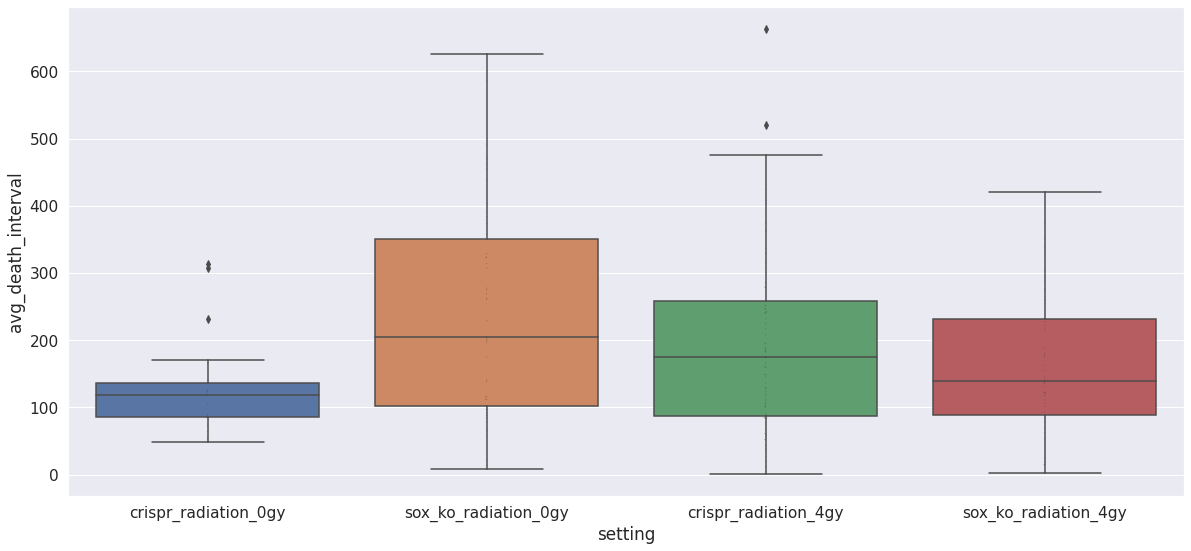

In [27]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 9))

ax = sns.boxplot(x="setting", y="avg_death_interval", data=df_cat_plot, order=setting_columns)
ax = sns.swarmplot(x="setting", y="avg_death_interval", data=df_cat_plot, order=setting_columns, color=".25", alpha=0.5, size=1.0)

In [28]:
selected_features = [i for i in df_copy.columns if i not in [""]]
df_sox_0gy = df_copy[df_copy["radiation_level"] == 0].groupby("sox_ko_radiation_0gy").mean().reset_index()
df_sox_0gy = df_sox_0gy.T
df_sox_0gy = df_sox_0gy.rename(columns={0: "ct_0gy", 1: "sox_0gy"})
df_sox_0gy

df_sox_4gy = df_copy[df_copy["radiation_level"] == 4].groupby("sox_ko_radiation_4gy").mean().reset_index()
df_sox_4gy = df_sox_4gy.T
df_sox_4gy = df_sox_4gy.rename(columns={0: "ct_4gy", 1: "sox_4gy"})
df_sox = df_sox_0gy.join(df_sox_4gy)

df_sox["diff_0gy"] = (df_sox["sox_0gy"] - (df_sox["ct_0gy"]))
df_sox["diff_4gy"] = (df_sox["sox_4gy"] - (df_sox["ct_4gy"]))
df_sox

ct_0gy  sox_0gy   ct_4gy  \
sox_ko_radiation_0gy                           False     True        0   
radiation_level                                    0        0        4   
radiation_0gy                                      1        1        0   
crispr_radiation_0gy                               1        0        0   
radiation_4gy                                      0        0        1   
crispr_radiation_4gy                               0        0        1   
sox_ko_radiation_4gy                               0        0    False   
lineage_death                                   0.12     0.27     0.36   
nb_div                                            12      3.6      4.1   
nb_fusion                                       0.35     0.13      0.7   
nb_death                                        0.56     0.65      1.1   
nb_end                                            12      3.4      3.3   
avg_div_outputs                                    2      2.1      2.2   
avg_fusion_input                                0.11    0.094     0.58   
avg_div_interval                             1.7e+02  1.7e+02  1.9e+02   
avg_fusion_interval                               42       45       62   
avg_death_interval                           1.3e+02  2.4e+02  1.9e+02   
sum_input_age                                  3e+03  1.6e+03  1.5e+03   
nb_simultaneous_event                              0        0        0   
nb_fusion_inter_lineage                            0        0        0   
nb_non_dichotomic_division                      0.25     0.15     0.41   
nb_anormal_division                             0.48      0.2     0.77   
first_div_time                               1.2e+02  1.3e+02  1.7e+02   
death_after_begin                              0.019    0.068    0.074   
nb_death_after_normal_div                       0.48      0.5     0.72   
nb_death_after_anormal_div                         0    0.043     0.13   
nb_death_after_fusion                          0.058    0.034     0.18   
nb_div_in_time_window_0                         0.63     0.54     0.29   
nb_div_in_time_window_1                         0.92     0.61     0.62   
nb_div_in_time_window_2                          1.8     0.91     0.95   
nb_div_in_time_window_3                          3.3     0.71      1.2   
nb_div_in_time_window_4                          4.8      0.8      1.1   
nb_fusion_in_time_window_0                     0.019        0        0   
nb_fusion_in_time_window_1                         0        0    0.059   
nb_fusion_in_time_window_2                     0.077    0.043     0.16   
nb_fusion_in_time_window_3                      0.13    0.034      0.2   
nb_fusion_in_time_window_4                      0.12    0.051     0.27   
nb_anormal_division_in_time_window_0           0.019   0.0085    0.022   
nb_anormal_division_in_time_window_1           0.019   0.0085     0.11   
nb_anormal_division_in_time_window_2            0.12    0.085     0.22   
nb_anormal_division_in_time_window_3            0.13    0.026     0.22   
nb_anormal_division_in_time_window_4            0.19    0.068     0.19   
nb_non_dichotomic_division_in_time_window_0        0   0.0085    0.015   
nb_non_dichotomic_division_in_time_window_1        0        0    0.044   
nb_non_dichotomic_division_in_time_window_2    0.058    0.051    0.096   
nb_non_dichotomic_division_in_time_window_3    0.019    0.026     0.11   
nb_non_dichotomic_division_in_time_window_4     0.17     0.06     0.15   
nb_death_in_time_window_0                      0.019        0        0   
nb_death_in_time_window_1                      0.077    0.034     0.12   
nb_death_in_time_window_2                      0.096      0.2     0.23   
nb_death_in_time_window_3                       0.13     0.15     0.33   
nb_death_in_time_window_4                       0.23     0.27     0.44   
lineage_dead_at_time_window_0                  0.077     0.21     0.15   
lineage_dead_at_time_window_1                  0.0

## Number of division until day 3

In [29]:
df_copy = df.copy()
df_copy["nb_div_until_day_3"] = df_copy["nb_div_in_time_window_0"] + df_copy["nb_div_in_time_window_1"] + df_copy["nb_div_in_time_window_2"]
df_copy["nb_anormal_division_until_day_3"] = df_copy["nb_anormal_division_in_time_window_0"] + df_copy["nb_anormal_division_in_time_window_1"] + df_copy["nb_anormal_division_in_time_window_2"]
df_copy["nb_fusion_until_day_3"] = df_copy["nb_fusion_in_time_window_0"] + df_copy["nb_fusion_in_time_window_1"] + df_copy["nb_fusion_in_time_window_2"]
df_copy["nb_death_until_day_3"] = df_copy["nb_death_in_time_window_0"] + df_copy["nb_death_in_time_window_1"] + df_copy["nb_death_in_time_window_2"]
df_copy["nb_non_dichotomic_div_until_day_3"] = df_copy["nb_non_dichotomic_division_in_time_window_0"] + df_copy["nb_non_dichotomic_division_in_time_window_1"] + df_copy["nb_non_dichotomic_division_in_time_window_2"]
df_copy.head()

cell_line_id  radiation_level experiment_setting  lineage_death  \
0  160930.nd2u2514gyp3_C1                4          normal,n1          False   
1  160930.nd2u2514gyp3_C2                4          normal,n1           True   
2  160930.nd2u2514gyp3_C3                4          normal,n1           True   
3  160930.nd2u2514gyp3_C4                4          normal,n1           True   
4  160930.nd2u2514gyp3_C5                4          normal,n1          False   

   nb_div  nb_fusion  nb_death  nb_end  avg_div_outputs  avg_fusion_input  \
0     1.0        1.0       1.0     1.0              3.0               2.0   
1     0.0        0.0       0.0     0.0              NaN               NaN   
2     0.0        0.0       1.0     0.0              NaN               NaN   
3     0.0        0.0       0.0     0.0              NaN               NaN   
4     1.0        0.0       1.0     2.0              3.0               0.0   

   ...  lineage_dead_at_time_window_2  lineage_dead_at_time_window_3  \
0  ...                          False                          False   
1  ...                           True                           True   
2  ...                           True                           True   
3  ...                           True                           True   
4  ...                          False                          False   

   lineage_dead_at_time_window_4  sox_ko  version  nb_div_until_day_3  \
0                          False   False  default                   0   
1                           True   False  default                   0   
2                           True   False  default                   0   
3                           True   False  default                   0   
4                          False   False  default                   1   

   nb_anormal_division_until_day_3  nb_fusion_until_day_3  \
0                                0                      0   
1                                0                      0   
2                                0                      0   
3                                0                      0   
4                                1                      0   

   nb_death_until_day_3  nb_non_dichotomic_div_until_day_3  
0                     0                                  0  
1                     0                                  0  
2                     0                                  0  
3                     0                                  0  
4                     0                                  1  

[5 rows x 60 columns]

In [30]:
# DBG
df_copy[(df_copy["nb_anormal_division_until_day_3"] != df_copy["nb_non_dichotomic_div_until_day_3"]) & (df_copy["nb_non_dichotomic_div_until_day_3"] > 0)]

cell_line_id  radiation_level experiment_setting  \
95                 2020 16 10 4Gy 2B2_C4                4          normal,n3   
122                2020 16 10 4Gy 2B2_C4                4          normal,n3   
155               2020 16 10 4Gy 1A2_C10                4          normal,n3   
177               2020 16 10 4Gy 1A2_C10                4          normal,n3   
245              2020 16 10 4Gy  1B2_C18                4          normal,n3   
270              2020 16 10 4Gy  1B2_C18                4          normal,n3   
473   20210305u251.nd2crisprsox24GYp2_C6                4          sox,n1,ko   
487   20210305u251.nd2crisprsox24GYp2_C6                4          sox,n1,ko   
504   20210305u251.nd2crisprsox24GYp3_C9                4          sox,n1,ko   
518   20210305u251.nd2crisprsox24GYp3_C9                4          sox,n1,ko   
569     20210305u251.nd2crisprCT4GYp4_C6                4          sox,n1,ct   
584     20210305u251.nd2crisprCT4GYp4_C6                4          sox,n1,ct   
711               2021-n2-SOX2-4Gy-5b_C8                4          sox,n2,ko   
720               2021-n2-SOX2-4Gy-5b_C8                4          sox,n2,ko   
828         2021-04-23-crisprCT4gy-8B_C5                4          sox,n2,ct   
840         2021-04-23-crisprCT4gy-8B_C5                4          sox,n2,ct   
888         2021-04-23-crisprCT4gy-8C_C9                4          sox,n2,ct   
901         2021-04-23-crisprCT4gy-8C_C9                4          sox,n2,ct   
963              201104.nd2u2510GyA3A_C2                0          normal,n1   
972              201104.nd2u2510GyA3A_C2                0          normal,n1   
981                 2020 11 04 0Gy 1A_C2                0          normal,n1   
990                 2020 11 04 0Gy 1A_C2                0          normal,n1   
999               201104.nd2u2510Gy1A_C2                0          normal,n1   
1008              201104.nd2u2510Gy1A_C2                0          normal,n1   
1045               2020 11 04 0Gy A3A_C2                0          normal,n1   
1054               2020 11 04 0Gy A3A_C2                0          normal,n1   
1520             2021-n2-SOX2-0Gy-10B_C5                0          sox,n2,ko   
1527             2021-n2-SOX2-0Gy-10B_C5                0          sox,n2,ko   
1575                2021-n2-CT-0Gy-3B_C4                0          sox,n2,ct   
1581                2021-n2-CT-0Gy-3B_C4                0          sox,n2,ct   
1599                2021-n2-CT-0Gy-3C_C2                0          sox,n2,ct   
1611                2021-n2-CT-0Gy-3C_C2                0          sox,n2,ct   
1688                   2021-04-2Gy-1A_C4                2          normal,n3   
1790                   2021-04-2Gy-6B_C8                2          normal,n3   
1798                   2021-04-2Gy-3B_C6                2          normal,n3   
1803                   2021-04-2Gy-5C_C3                2          normal,n3   
2017               2021 11 11 8Gy A3B_C8                8          normal,n3   
2094              2021 11 11 8Gy A3A_C15                8          normal,n3   
2114             2021 11 11  8Gy B3A_C12                8          normal,n3   
2135               2021 11 11 8Gy C4C_C4                8          normal,n3   
2176               2021 11 11 8Gy B3C_C3                8          normal,n3   
2204              2020 04 11 B3A  8gy_C5                8          normal,n2   
2206              2020 04 11 B3A  8gy_C8                8          normal,n2   
2244              2020 04 11 B4A  8gy_C4                8          normal,n2   
2247              2020 04 11 B4A  8gy_C7                8          normal,n2   
2346              2020 04 11 C4A  8gy_C3                8          normal,n2   
2376             160930.nd2u25110gyp3_C6               10          normal,n1   
2403         07-06-2021-10Gy-u251-3B_C18               10          normal,n3   
2406          07-06-2021-10Gy-u251-6B_C2               10          normal,n3   
2510          07-06-2021-10G

In [31]:
!rm *.xlsx
!rm nb_div_until_day_3.zip

rm: impossible de supprimer '*.xlsx': Aucun fichier ou dossier de ce type
rm: impossible de supprimer 'nb_div_until_day_3.zip': Aucun fichier ou dossier de ce type


In [32]:
from IPython.display import FileLink, FileLinks

for experiment_setting in df_copy["experiment_setting"].unique():
    for radiation_level in df_copy[df_copy["experiment_setting"] == experiment_setting]["radiation_level"].unique():
        print("Extracting nb_div_until_day_3 for "+experiment_setting+" "+str(radiation_level)+"gy")
        df_output = df_copy[(df_copy["experiment_setting"] == experiment_setting) & (df_copy["radiation_level"] == radiation_level)][
            ["cell_line_id", 
             "nb_div_until_day_3", 
             "nb_anormal_division_until_day_3", 
             "nb_fusion_until_day_3",
             "nb_death_until_day_3",
             "nb_non_dichotomic_div_until_day_3"
            ]]
        df_output = df_output.set_index('cell_line_id').transpose()
        filename = experiment_setting+"_"+str(radiation_level)+"GY.xlsx"
        df_output.to_excel(filename)
!zip "features_until_day_3.zip" *.xlsx
!rm *.xlsx
FileLink("features_until_day_3.zip")

Extracting nb_div_until_day_3 for normal,n1 4gy
Extracting nb_div_until_day_3 for normal,n1 0gy
Extracting nb_div_until_day_3 for normal,n1 2gy
Extracting nb_div_until_day_3 for normal,n1 8gy
Extracting nb_div_until_day_3 for normal,n1 10gy
Extracting nb_div_until_day_3 for normal,n1 15gy
Extracting nb_div_until_day_3 for normal,n3 4gy
Extracting nb_div_until_day_3 for normal,n3 0gy
Extracting nb_div_until_day_3 for normal,n3 2gy
Extracting nb_div_until_day_3 for normal,n3 8gy
Extracting nb_div_until_day_3 for normal,n3 10gy
Extracting nb_div_until_day_3 for normal,n3 15gy
Extracting nb_div_until_day_3 for normal,n2 4gy
Extracting nb_div_until_day_3 for normal,n2 0gy
Extracting nb_div_until_day_3 for normal,n2 2gy
Extracting nb_div_until_day_3 for normal,n2 8gy
Extracting nb_div_until_day_3 for normal,n2 10gy
Extracting nb_div_until_day_3 for normal,n2 15gy
Extracting nb_div_until_day_3 for sox,n1,ko 4gy
Extracting nb_div_until_day_3 for sox,n1,ko 0gy
Extracting nb_div_until_day_3 for 

/home/keijuro/Bureau/epicea/features_until_day_3.zip

In [33]:
df.groupby("radiation_level").mean()

lineage_death  nb_div  nb_fusion  nb_death  nb_end  \
radiation_level                                                       
0                         0.37    4.15       0.09      0.31    3.86   
2                         0.16    7.29       0.34      0.68    7.53   
4                         0.68    3.09       0.31      0.53    1.95   
8                         0.58    1.79       0.68      0.89    1.28   
10                        0.73    1.16       0.79      0.98    0.43   
15                        0.83    0.68       0.72      0.85    0.20   

                 avg_div_outputs  avg_fusion_input  avg_div_interval  \
radiation_level                                                        
0                           2.05              0.09            162.09   
2                           1.68              0.21            159.22   
4                           2.14              0.37            185.82   
8                           2.46              1.35            237.78   
10                          2.62              1.87            243.01   
15                          2.98              2.55            305.08   

                 avg_fusion_interval  avg_death_interval  ...  \
radiation_level                                           ...   
0                              36.42              181.18  ...   
2                              56.88              147.80  ...   
4                              64.34              180.74  ...   
8                              67.38              203.15  ...   
10                             71.99              215.73  ...   
15                             49.89              208.58  ...   

                 nb_death_in_time_window_1  nb_death_in_time_window_2  \
radiation_level                                                         
0                                     0.05                       0.15   
2                                     0.07                       0.23   
4                                     0.07                       0.18   
8                                     0.07                       0.19   
10                                    0.06                       0.22   
15                                    0.05                       0.21   

                 nb_death_in_time_window_3  nb_death_in_time_window_4  \
radiation_level                                                         
0                                     0.04                       0.07   
2                                     0.23                       0.00   
4                                     0.12                       0.14   
8                                     0.30                       0.30   
10                                    0.39                       0.29   
15                                    0.36                       0.21   

                 lineage_dead_at_time_window_0  lineage_dead_at_time_window_1  \
radiation_level                                                                 
0                                         0.15                           0.20   
2                                         0.12                           0.15   
4                                         0.23                           0.34   
8                                         0.32                           0.43   
10                                        0.33                           0.43   
15                                        0.43                           0.50   

                 lineage_dead_at_time_window_2  lineage_dead_at_time_window_3  \
radiation_level                                                                 
0                                         0.37                           0.37   
2                                         0.16                           0.16   
4                                         0.67                           0.67   
8                                         0.52                           0.56   
10                                        0.6

In [34]:
df_copy = df.copy()
df_copy = df_copy.groupby("radiation_level").sum()
df_copy.reset_index()
df_copy[["nb_death", "death_after_begin","nb_death_after_fusion", "nb_death_after_normal_div", "nb_death_after_anormal_div"]].astype(int)

nb_death  death_after_begin  nb_death_after_fusion  \
radiation_level                                                       
0                     208                 25                     19   
2                     173                 15                     16   
4                     508                 71                     74   
8                     424                 62                     95   
10                    577                 86                    202   
15                    512                110                    187   

                 nb_death_after_normal_div  nb_death_after_anormal_div  
radiation_level                                                         
0                                      152                          12  
2                                      122                          20  
4                                      301                          59  
8                                      173                          94  
10                                     172                         117  
15                                      93                         122

In [35]:
df_copy = df.copy()
df_copy = df_copy.groupby("radiation_level").sum()
df_copy.reset_index()
df_copy = df_copy[['death_after_begin','nb_death_after_fusion', 'nb_death_after_normal_div', 'nb_death_after_anormal_div']].div(df_copy.nb_death, axis=0)
df_copy.applymap(lambda x: str(round(x*100))+"%")
#ax = sns.countplot(x="radiation_level", data=df_copy)

death_after_begin nb_death_after_fusion  \
radiation_level                                           
0                             12%                    9%   
2                              9%                    9%   
4                             14%                   15%   
8                             15%                   22%   
10                            15%                   35%   
15                            21%                   37%   

                nb_death_after_normal_div nb_death_after_anormal_div  
radiation_level                                                       
0                                     73%                         6%  
2                                     71%                        12%  
4                                     59%                        12%  
8                                     41%                        22%  
10                                    30%                        20%  
15                                    18%                        24%